# ATLAS OmniFold - Technical Closure and Stress Tests
In this notebook, we use a single a sample to perform a technical closure test (unfolding the sample against itself) and stress tests (unfolding the sample with artificial "stress" weights).

### Standard Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from __future__ import absolute_import, division, print_function

from ntupleanalysis import *
import math

import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

import energyflow as ef
from energyflow.archs import PFN

Using TensorFlow backend.


In [4]:
plot_setup()

In [5]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [6]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'histtype': 'stepfilled','alpha': 0.5, 'density': True}

### Utilities

In [7]:
# from NN (DCTR)
def reweight(model, events):
    f = model.predict(events, batch_size=1000)
    weights = f / (1. - f)
    return np.squeeze(weights)

In [8]:
def sigmoid(x):
    return 1./(1. + np.exp(-x)) 

### Load ROOT file

In [9]:
zmumu_0 = uproot.open(
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Oct5_PowhegPythia_mc16e.root"
)['EventTree']

In [10]:
zmumu_0.show()

CutFlow                    (no streamer)              asdtype('>i4')
EventNumber                (no streamer)              asdtype('>i4')
RunNumber                  (no streamer)              asdtype('>i4')
LumiBlock                  (no streamer)              asdtype('>i4')
BCID                       (no streamer)              asdtype('>i4')
NPV                        (no streamer)              asdtype('>i4')
pass                       (no streamer)              asdtype('>i4')
truth_pass                 (no streamer)              asdtype('>i4')
initialWeight              (no streamer)              asdtype('>f4')
pileupWeight               (no streamer)              asdtype('>f4')
genWeight                  (no streamer)              asdtype('>f4')
weight                     (no streamer)              asdtype('>f4')
mu_recoSF                  (no streamer)              asdtype('>f4')
mu_isoSF                   (no streamer)              asdtype('>f4')
mu_TTVASF                  (no str

In [11]:
mybranches_0 = []
for mykey in zmumu_0.keys():
    mybranches_0 += [mykey.decode("utf-8")]

In [12]:
Events_0 = prepare_dataset_table([
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Oct5_PowhegPythia_mc16e.root"
],
                               "EventTree",
                               branch_list=mybranches_0,
                               col_names=mybranches_0,
                               entrysteps=10000000,
                               outputype=Event_table)

Total number of events:  666677
Events in returned Object:  666677
Loading the data took  78.29675340652466  seconds


### Unpack data

In [13]:
# Event selection

# we should eventually properly account for events that fail one of Gen or Sim.  For now, just ignore them.

mypass_0 = (Events_0.events['m_ll'] > 0) & (Events_0.events['m_ll'] < 200) & (
    Events_0.events['truth_m_ll'] > 0) & (Events_0.events['truth_m_ll'] < 200)

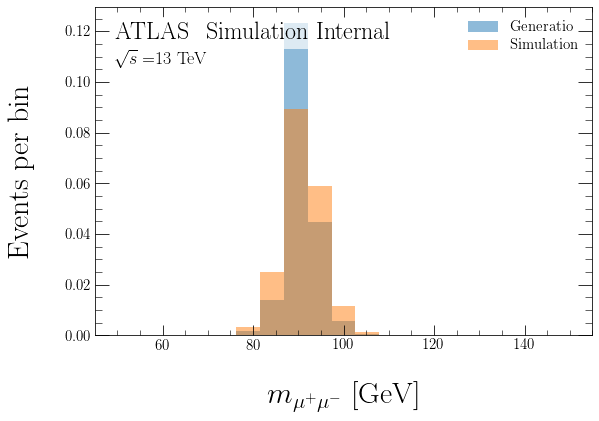

In [14]:
plt.figure()
hG, _, _ = plt.hist(Events_0.events['truth_m_ll'][mypass_0],
                    label="Generatio",
                    bins=np.linspace(50, 150, 20),
                    alpha=0.5, density=True)
hS, _, _ = plt.hist(Events_0.events['m_ll'][mypass_0],
                    label="Simulation",
                    bins=np.linspace(50, 150, 20),
                    alpha=0.5, density=True)

plt.xlabel("$m_{\mu^+\mu^-}$ [GeV]")
plt.ylabel("Events per bin")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.legend()
# plt.ylim([0, 1.5 * max(max(hG), max(hS))])
plt.show()

In [15]:
mytracks_0 = Events_0.events['truth_pT_Tracks'][mypass_0]
ntrack_0_Gen = [len(mytracks_0[i]) for i in range(len(mytracks_0))]

In [16]:
mytracks_0 = Events_0.events['pT_Tracks'][mypass_0]
ntrack_0_Sim = [len(mytracks_0[i]) for i in range(len(mytracks_0))]

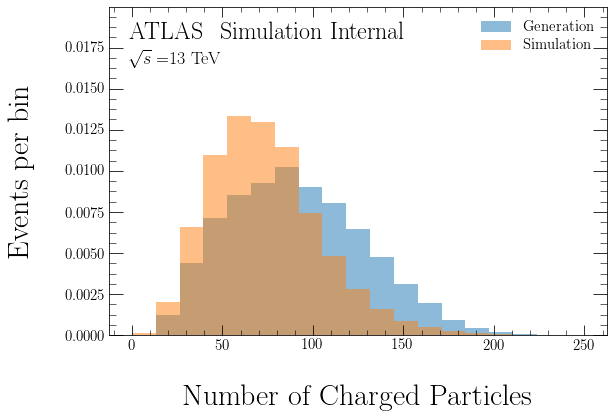

In [17]:
hG, _, _ = plt.hist(ntrack_0_Gen,
                    label="Generation",
                    alpha=0.5,
                    density=True,
                    bins=np.linspace(0, 250, 20))
hS, _, _ = plt.hist(ntrack_0_Sim,
                    label="Simulation",
                    alpha=0.5,
                    density=True,
                    bins=np.linspace(0, 250, 20))
plt.xlabel("Number of Charged Particles")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.ylabel("Events per bin")
plt.legend()
plt.ylim([0, 1.5 * max(max(hG), max(hS))])
plt.show()

### Define UniFold Algorithm

In [18]:
"""    Arguments:
                            
        iterations: number of iterations (integer)
        
        theta_0_G: synthetic generation-level observable as Numpy array
                    
        theta_0_S: synthetic simulation-level observable as Numpy array
                    
        theta_unknown_S: "natural" (unknown) simulation-level observable 
                            to be unfolded as Numpy arrays
                            
        weightsMC_0: (optional) initial MC generator weights for synthetic sample
        
        weightsMC_unknown: (optional) initial MC generator weights for natural sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    theta_0_G to the unfolded distribution of theta_unknown_S
        
        model: The model used to calculate those weights
"""


def unifold(iterations,
            theta_0_G,
            theta_0_S,
            theta_unknown_S,
            weightsMC_0=None,
            weightsMC_unknown=None):
    
    if weightsMC_0 is None:
        weightsMC_0 = np.ones(len(theta_0_G)) 
        
    if weightsMC_unknown is None:
        weightsMC_unknown = np.ones(len(theta_unknown_S))

    labels_0 = np.zeros(len(theta_0_G))
    labels_unknown = np.ones(len(theta_unknown_S))

    xvals_1 = np.concatenate((theta_0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((theta_0_G, theta_0_G))
    yvals_2 = np.concatenate((labels_0, (labels_0+1.)))

    weights = np.empty(shape=(iterations, 2, len(theta_0_G)))
    # shape = (iteration, step, event)

    weights_pull = weightsMC_0
    weights_push = weightsMC_0

    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, weightsMC_unknown))
        # actual weights for Sim., ones for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, theta_0_S)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((weightsMC_0, weights_pull))
        # ones for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = weightsMC_0 * reweight(model, theta_0_G)
        weights[i, 1:2, :] = weights_push

    return weights, model

### Define MultiFold Algorithm

In [19]:
# Input multiple observables as tuple or list (i.e. theta_0_G = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        theta_0_G: tuple or list of synthetic 
                    generation-level observables as Numpy arrays
                    
        theta_0_S: tuple or list of synthetic 
                    simulation-level observables as Numpy arrays
                    
        theta_unknown_S: tuple or list of "natural" 
                            (unknown) simulation-level observables 
                            to be unfolded as Numpy arrays
        
        weightsMC_0: (optional) initial MC generator weights for synthetic sample
        
        weightsMC_unknown: (optional) initial MC generator weights for natural sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    theta_0_G to the unfolded distribution of theta_unknown_S
        
        model: The model used to calculate those weights
"""


def multifold(num_observables,
              iterations,
              theta_0_G,
              theta_0_S,
              theta_unknown_S,
              weightsMC_0=None,
              weightsMC_unknown=None):

    theta_0_G = np.stack(theta_0_G, axis=1)
    theta_0_S = np.stack(theta_0_S, axis=1)
    theta_unknown_S = np.stack(theta_unknown_S, axis=1)
    
    if weightsMC_0 is None:
        weightsMC_0 = np.ones(len(theta_0_G)) 
        
    if weightsMC_unknown is None:
        weightsMC_unknown = np.ones(len(theta_unknown_S))

    labels_0 = np.zeros(len(theta_0_G))
    labels_unknown = np.ones(len(theta_unknown_S))

    xvals_1 = np.concatenate((theta_0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((theta_0_G, theta_0_G))
    yvals_2 = np.concatenate((labels_0, (labels_0+1.)))

    weights = np.empty(shape=(iterations, 2, len(theta_0_G)))
    # shape = (iteration, step, event)

    weights_pull = weightsMC_0
    weights_push = weightsMC_0

    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate(
            (weights_push, weightsMC_unknown))
        # actual weights for Sim., ones for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, theta_0_S)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((weightsMC_0, weights_pull))
        # ones for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = weightsMC_0 * reweight(model, theta_0_G)
        weights[i, 1:2, :] = weights_push

    return weights, model

# Technical Closure Test
We split the existing sample in half and unfold it against itself.

## UniFold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles separately.

### Setup Datasets

In [20]:
m_ll_0_G, m_ll_unknown_G, m_ll_0_S, m_ll_unknown_S = train_test_split(Events_0.events['truth_m_ll'][mypass_0],
                                                                      Events_0.events['m_ll'][mypass_0], 
                                                                      test_size=0.5)

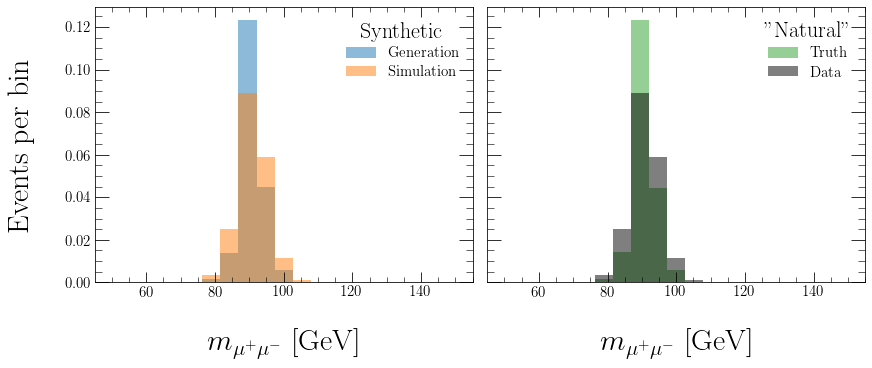

In [21]:
bins = np.linspace(50, 150, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Events per bin')
hG0, _, _ = ax[0].hist(m_ll_0_G,
                       bins=bins,
                       label='Generation',
                       **plot_style_2,
                       color='C0')
hS0, _, _ = ax[0].hist(m_ll_0_S,
                       bins=bins,
                       label='Simulation',
                       **plot_style_2,
                       color='C1')
legend = ax[0].legend(title='Synthetic', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[1].hist(m_ll_unknown_G,
                       bins=bins,
                       label='Truth',
                       **plot_style_2,
                       color='C2')
hS1, _, _ = ax[1].hist(m_ll_unknown_S,
                       bins=bins,
                       label='Data',
                       **plot_style_2,
                       color='k')
legend = ax[1].legend(title='"Natural"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-TechnicalClosureTest-UniFold-m_ll-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

In [22]:
nTracks_0_G, nTracks_unknown_G, nTracks_0_S, nTracks_unknown_S = train_test_split(np.array(ntrack_0_Gen),
                                                                      np.array(ntrack_0_Sim), 
                                                                      test_size=0.5)

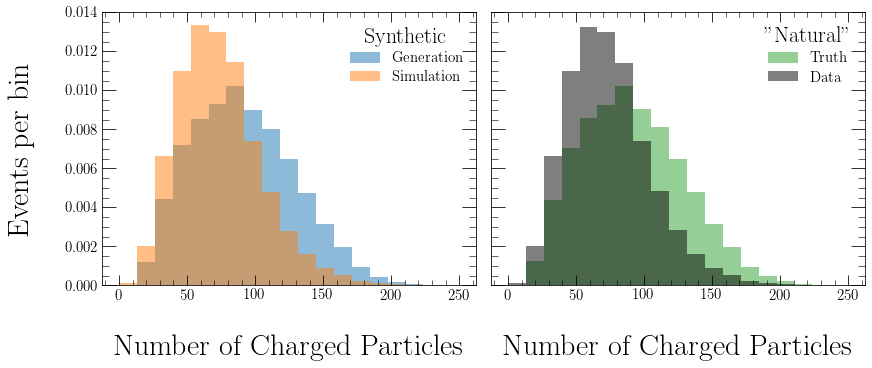

In [23]:
bins = np.linspace(0, 250, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Events per bin')
hG0, _, _ = ax[0].hist(nTracks_0_G,
                       bins=bins,
                       label='Generation',
                       **plot_style_2,
                       color='C0')
hS0, _, _ = ax[0].hist(nTracks_0_S,
                       bins=bins,
                       label='Simulation',
                       **plot_style_2,
                       color='C1')
legend = ax[0].legend(title='Synthetic', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1].hist(nTracks_unknown_G,
                       bins=bins,
                       label='Truth',
                       **plot_style_2,
                       color='C2')
hS1, _, _ = ax[1].hist(nTracks_unknown_S,
                       bins=bins,
                       label='Data',
                       **plot_style_2,
                       color='k')
legend = ax[1].legend(title='"Natural"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-TechnicalClosureTest-UniFold-nTracks-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

### Unfold $m_{\mu^+\mu^-}$

In [24]:
# z-score standardization of data

scaler_G = preprocessing.StandardScaler()
scaler_S = preprocessing.StandardScaler()

scaler_G.fit(m_ll_0_G.reshape(-1,1))
scaler_S.fit(np.concatenate((m_ll_0_S, m_ll_unknown_S)).reshape(-1,1))

theta_0_G = np.squeeze(scaler_G.transform(m_ll_0_G.reshape(-1,1)))
theta_0_S = np.squeeze(scaler_S.transform(m_ll_0_S.reshape(-1,1)))
theta_unknown_S = np.squeeze(scaler_S.transform(m_ll_unknown_S.reshape(-1,1)))

In [25]:
weights, _ = unifold(iterations=3,
                     theta_0_G=theta_0_G,
                     theta_0_S=theta_0_S,
                     theta_unknown_S=theta_unknown_S)





ITERATION: 1

STEP 1



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 466582 samples, validate on 155528 samples
Epoch 1/200





466582/466582 [==============================] - 2s 4us/step - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.5004
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5009 - val_loss: 0.6932 - val_acc: 0.4991
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6932 - val_acc: 0.4999
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5022 - val_loss: 0.6932 - val_acc: 0.4979
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6932 - val_acc: 0.4999
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6932 - 

466582/466582 [==============================] - 1s 2us/step - loss: 0.6900 - acc: 0.4993 - val_loss: 0.6900 - val_acc: 0.4987
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6900 - acc: 0.4999 - val_loss: 0.6900 - val_acc: 0.4990
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6900 - acc: 0.5001 - val_loss: 0.6900 - val_acc: 0.4995
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6900 - acc: 0.4995 - val_loss: 0.6900 - val_acc: 0.4987
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6900 - acc: 0.4999 - val_loss: 0.6900 - val_acc: 0.4991
Epoch 13/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6900 - acc: 0.5001 - val_loss: 0.6900 - val_acc: 0.4983
Epoch 14/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6900 - acc: 0.4996 - val_loss: 0.6900 - val_acc: 0.4996
Epoch 15/200
466582/466582 [======

466582/466582 [==============================] - 1s 2us/step - loss: 0.6912 - acc: 0.4993 - val_loss: 0.6912 - val_acc: 0.5019
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6912 - acc: 0.4989 - val_loss: 0.6912 - val_acc: 0.5009
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6912 - acc: 0.4990 - val_loss: 0.6912 - val_acc: 0.5017
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6912 - acc: 0.4987 - val_loss: 0.6912 - val_acc: 0.5006
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6912 - acc: 0.4994 - val_loss: 0.6912 - val_acc: 0.5018
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6912 - acc: 0.4998 - val_loss: 0.6912 - val_acc: 0.5013
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6912 - acc: 0.4993 - val_loss: 0.6912 - val_acc: 0.5022
Epoch 13/200
466582/466582 [========

#### Results

ITERATION 1:


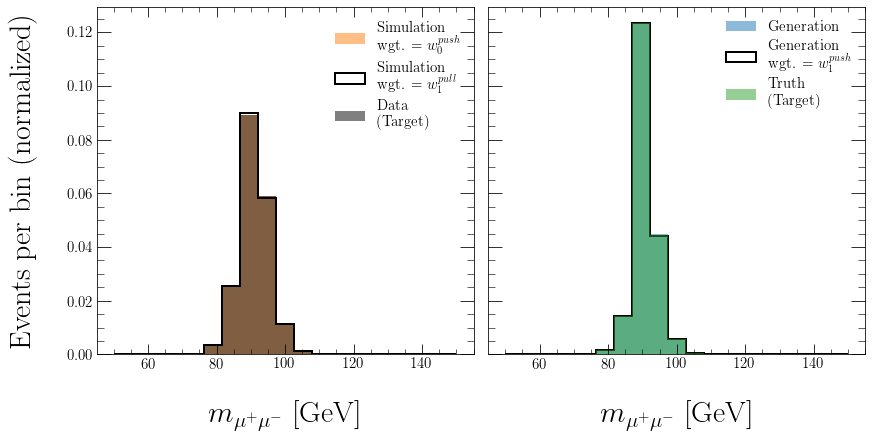

ITERATION 2:


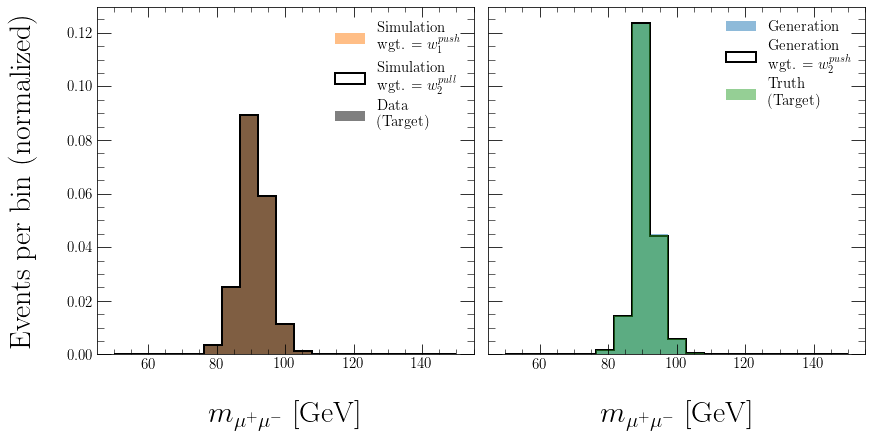

ITERATION 3:


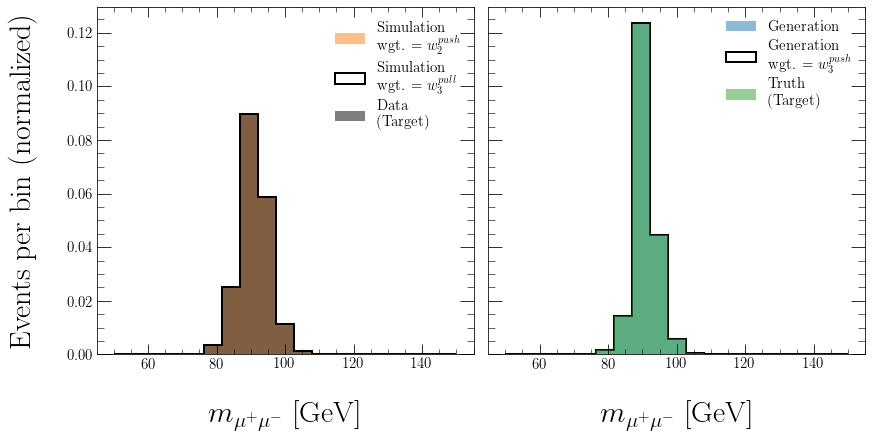

In [26]:
bins = np.linspace(50, 150, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = np.ones(len(m_ll_0_S))
    else:
        weights_init = weights[i - 1, 1, :]

    ax[0].hist(m_ll_0_S,
               weights=weights_init,
               bins=bins,
               label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) +
                                                                 '}'),
               **plot_style_2,
               color='C1')

    ax[0].hist(
        m_ll_0_S,
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        weights=weights[i, 0, :],
        **plot_style_1)
    ax[0].hist(m_ll_unknown_S,
               bins=bins,
               label='Data\n(Target)',
               **plot_style_2,
               color='k')
    ax[0].set_xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend()
    ax[1].hist(m_ll_0_G, bins=bins, label=r'Generation', **plot_style_2)

    ax[1].hist(
        m_ll_0_G,
        bins=bins,
        label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
        weights=weights[i, 1, :],
        **plot_style_1)
    ax[1].hist(m_ll_unknown_G,
               bins=bins,
               label='Truth\n(Target)',
               **plot_style_2,
               color='C2')
    ax[1].legend()
    ax[1].set_xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")

    fig.show()
#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-TechnicalClosureTest-UniFold-m_ll-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    plt.show()

### Unfold Number of Charged Particles

In [27]:
# z-score standardization of data

scaler_G = preprocessing.StandardScaler()
scaler_S = preprocessing.StandardScaler()

scaler_G.fit(nTracks_0_G.reshape(-1,1))
scaler_S.fit(np.concatenate((nTracks_0_S, nTracks_unknown_S)).reshape(-1,1))

theta_0_G = np.squeeze(scaler_G.transform(nTracks_0_G.reshape(-1,1)))
theta_0_S = np.squeeze(scaler_S.transform(nTracks_0_S.reshape(-1,1)))
theta_unknown_S = np.squeeze(scaler_S.transform(nTracks_unknown_S.reshape(-1,1)))

In [28]:
weights, _ = unifold(iterations=3,
                     theta_0_G=theta_0_G,
                     theta_0_S=theta_0_S,
                     theta_unknown_S=theta_unknown_S)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6932 - acc: 0.4993 - val_loss: 0.6932 - val_acc: 0.5007
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5006 - val_loss: 0.6932 - val_acc: 0.4987
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.4999
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5003 - val_loss: 0.6932 - val_acc: 0.4989
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5009
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5011 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - a

466582/466582 [==============================] - 1s 2us/step - loss: 0.6931 - acc: 0.4998 - val_loss: 0.6931 - val_acc: 0.5017
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6931 - acc: 0.4990 - val_loss: 0.6931 - val_acc: 0.5017
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6931 - acc: 0.4993 - val_loss: 0.6931 - val_acc: 0.5008
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6931 - acc: 0.4994 - val_loss: 0.6931 - val_acc: 0.5012
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6931 - acc: 0.4987 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6931 - acc: 0.5004 - val_loss: 0.6931 - val_acc: 0.5023
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6931 - acc: 0.4998 - val_loss: 0.6931 - val_acc: 0.4995
Epoch 12/200
466582/466582 [=========

#### Results

ITERATION 1:


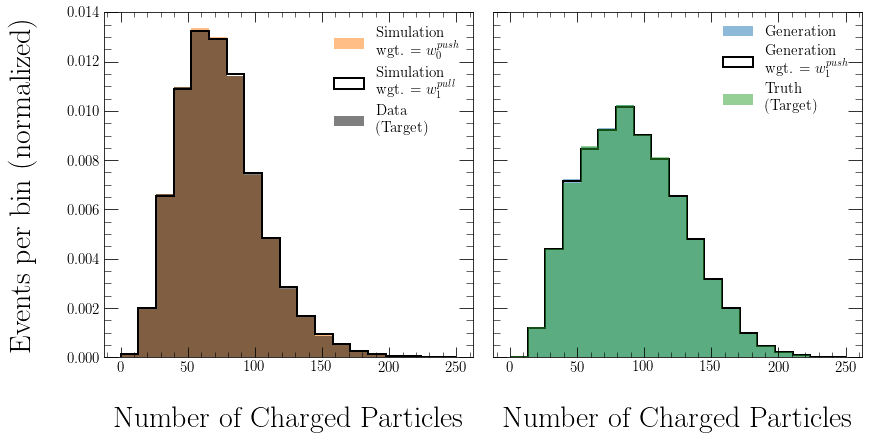

ITERATION 2:


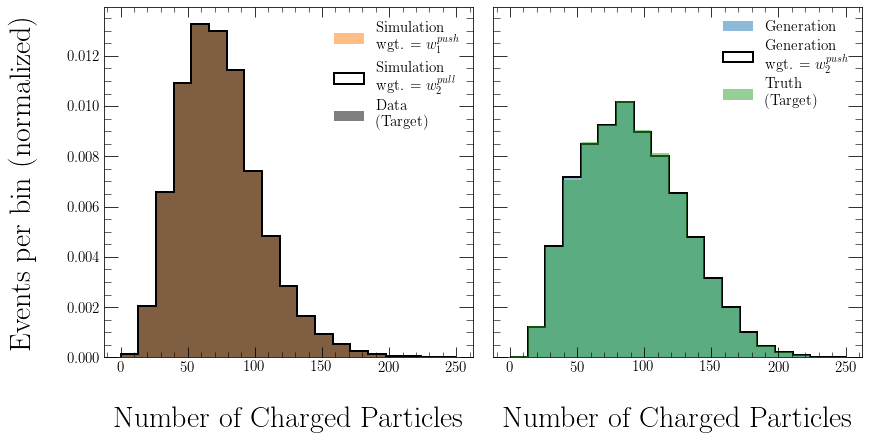

ITERATION 3:


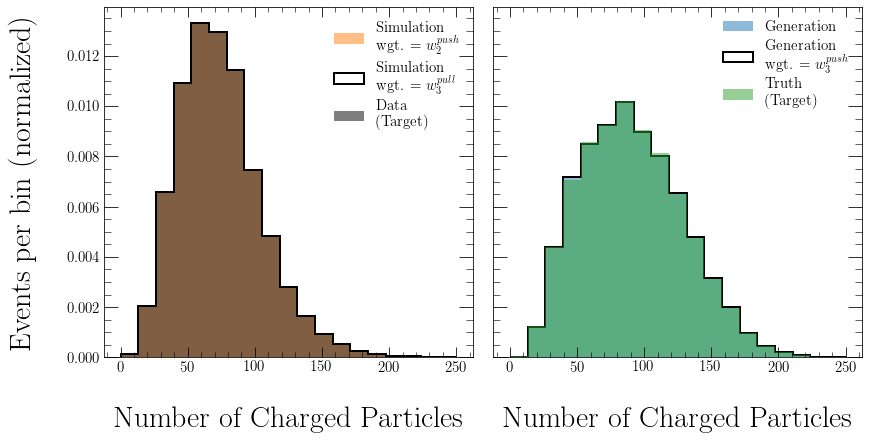

In [29]:
bins = np.linspace(0, 250, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = np.ones(len(nTracks_0_S))
    else:
        weights_init = weights[i - 1, 1, :]

    ax[0].hist(nTracks_0_S,
               weights=weights_init,
               bins=bins,
               label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) +
                                                                 '}'),
               **plot_style_2,
               color='C1')

    ax[0].hist(
        nTracks_0_S,
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        weights=weights[i, 0, :],
        **plot_style_1)
    ax[0].hist(nTracks_unknown_S,
               bins=bins,
               label='Data\n(Target)',
               **plot_style_2,
               color='k')
    ax[0].set_xlabel(r"Number of Charged Particles")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend()
    ax[1].hist(nTracks_0_G, bins=bins, label=r'Generation', **plot_style_2)

    ax[1].hist(
        nTracks_0_G,
        bins=bins,
        label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
        weights=weights[i, 1, :],
        **plot_style_1)
    ax[1].hist(nTracks_unknown_G,
               bins=bins,
               label='Truth\n(Target)',
               **plot_style_2,
               color='C2')
    ax[1].legend()
    ax[1].set_xlabel(r"Number of Charged Particles")

    fig.show()
#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-TechnicalClosureTest-UniFold-nTracks-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    plt.show()

## Multifold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles simultaneously.

In [30]:
K.clear_session()

### Setup datasets

In [31]:
m_ll_0_G, m_ll_unknown_G, m_ll_0_S, m_ll_unknown_S, nTracks_0_G, nTracks_unknown_G, nTracks_0_S, nTracks_unknown_S = train_test_split(
    Events_0.events['truth_m_ll'][mypass_0],
    Events_0.events['m_ll'][mypass_0],
    np.array(ntrack_0_Gen),
    np.array(ntrack_0_Sim),
    test_size=0.5)

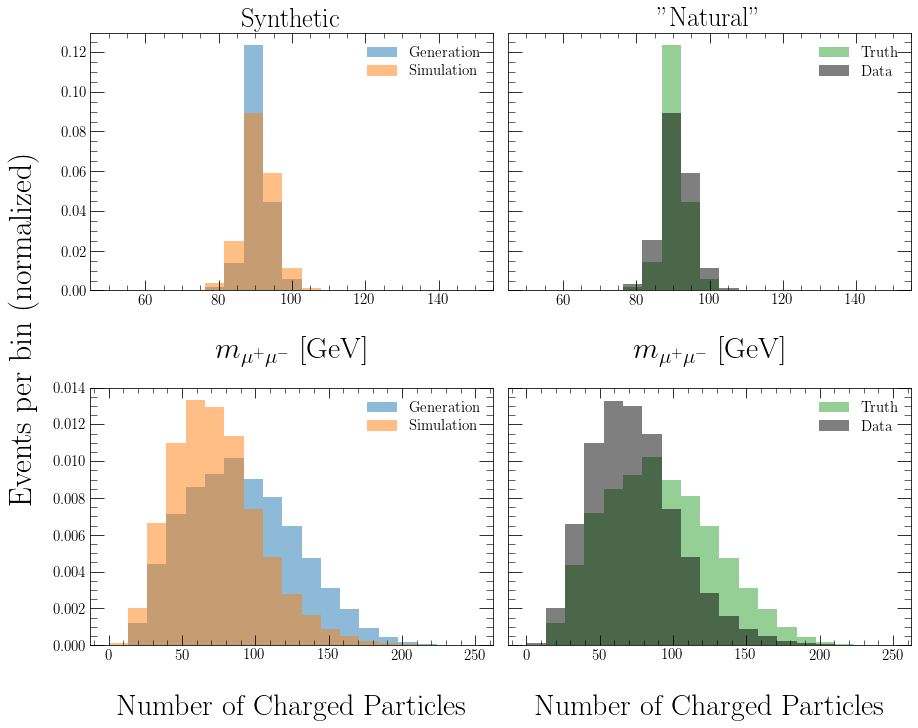

In [32]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 10),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(50, 150, 20)

ax[0, 0].set_title('Synthetic')
ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG0, _, _ = ax[0, 0].hist(m_ll_0_G,
                          bins=bins,
                          label='Generation',
                          **plot_style_2,
                          color='C0')
hS0, _, _ = ax[0, 0].hist(m_ll_0_S,
                          bins=bins,
                          label='Simulation',
                          **plot_style_2,
                          color='C1')
legend = ax[0, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Natural"')
ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[0, 1].hist(m_ll_unknown_G,
                          bins=bins,
                          label='Truth',
                          **plot_style_2,
                          color='C2')
hS1, _, _ = ax[0, 1].hist(m_ll_unknown_S,
                          bins=bins,
                          label='Data',
                          **plot_style_2,
                          color='k')
legend = ax[0, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

bins = np.linspace(0, 250, 20)

ax[1, 0].set_xlabel('Number of Charged Particles')
hG0, _, _ = ax[1, 0].hist(nTracks_0_G,
                          bins=bins,
                          label='Generation',
                          **plot_style_2,
                          color='C0')
hS0, _, _ = ax[1, 0].hist(nTracks_0_S,
                          bins=bins,
                          label='Simulation',
                          **plot_style_2,
                          color='C1')
legend = ax[1, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1, 1].hist(nTracks_unknown_G,
                          bins=bins,
                          label='Truth',
                          **plot_style_2,
                          color='C2')
hS1, _, _ = ax[1, 1].hist(nTracks_unknown_S,
                          bins=bins,
                          label='Data',
                          **plot_style_2,
                          color='k')
legend = ax[1, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.text(-0.05,
         0.55,
         'Events per bin (normalized)',
         va='center',
         rotation='vertical',
         fontsize='x-large')
# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-TechnicalClosureTest-MultiFold-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

### Unfold $m_{\mu^+\mu^-}$ and Number of Charged Particles Simultaneously

In [33]:
num_observables = 2

# z-score standardization

scaler_m_ll_G = preprocessing.StandardScaler()
scaler_m_ll_S = preprocessing.StandardScaler()

scaler_m_ll_G.fit(m_ll_0_G.reshape(-1,1))
scaler_m_ll_S.fit(np.concatenate((m_ll_0_S, m_ll_unknown_S)).reshape(-1,1))

scaler_nTracks_G = preprocessing.StandardScaler()
scaler_nTracks_S = preprocessing.StandardScaler()

scaler_nTracks_G.fit(nTracks_0_G.reshape(-1,1))
scaler_nTracks_S.fit(np.concatenate((nTracks_0_S, nTracks_unknown_S)).reshape(-1,1))

theta_0_G = (np.squeeze(scaler_m_ll_G.transform(m_ll_0_G.reshape(-1,1))),
             np.squeeze(scaler_nTracks_G.transform(nTracks_0_G.reshape(-1,1))))

theta_0_S = (np.squeeze(scaler_m_ll_S.transform(m_ll_0_S.reshape(-1,1))),
             np.squeeze(scaler_nTracks_S.transform(nTracks_0_S.reshape(-1,1))))

theta_unknown_S = (np.squeeze(scaler_m_ll_S.transform(m_ll_unknown_S.reshape(-1,1))),
                   np.squeeze(scaler_nTracks_S.transform(nTracks_unknown_S.reshape(-1,1))))

In [34]:
weights, _ = multifold(num_observables=num_observables,
                       iterations=3,
                       theta_0_G=theta_0_G,
                       theta_0_S=theta_0_S,
                       theta_unknown_S=theta_unknown_S)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 2s 4us/step - loss: 0.6933 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.5009
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5011 - val_loss: 0.6932 - val_acc: 0.4987
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5020 - val_loss: 0.6932 - val_acc: 0.4997
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6932 - val_acc: 0.4999
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5009 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.5019 - val_loss: 0.6933 - val_acc: 0.4992
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - a

466582/466582 [==============================] - 1s 2us/step - loss: 0.6925 - acc: 0.5000 - val_loss: 0.6925 - val_acc: 0.4979
Epoch 16/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6925 - acc: 0.5002 - val_loss: 0.6925 - val_acc: 0.4979
Epoch 17/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6925 - acc: 0.4998 - val_loss: 0.6925 - val_acc: 0.4975
Epoch 18/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6925 - acc: 0.4994 - val_loss: 0.6925 - val_acc: 0.4989
Epoch 19/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6925 - acc: 0.5000 - val_loss: 0.6925 - val_acc: 0.4976
Restoring model weights from the end of the best epoch
Epoch 00019: early stopping

ITERATION: 3

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6934 - acc: 0.4999 - val_loss: 0.6934 - val_acc: 0.4998
Epoch 2/200
4665

#### Results

ITERATION: 1


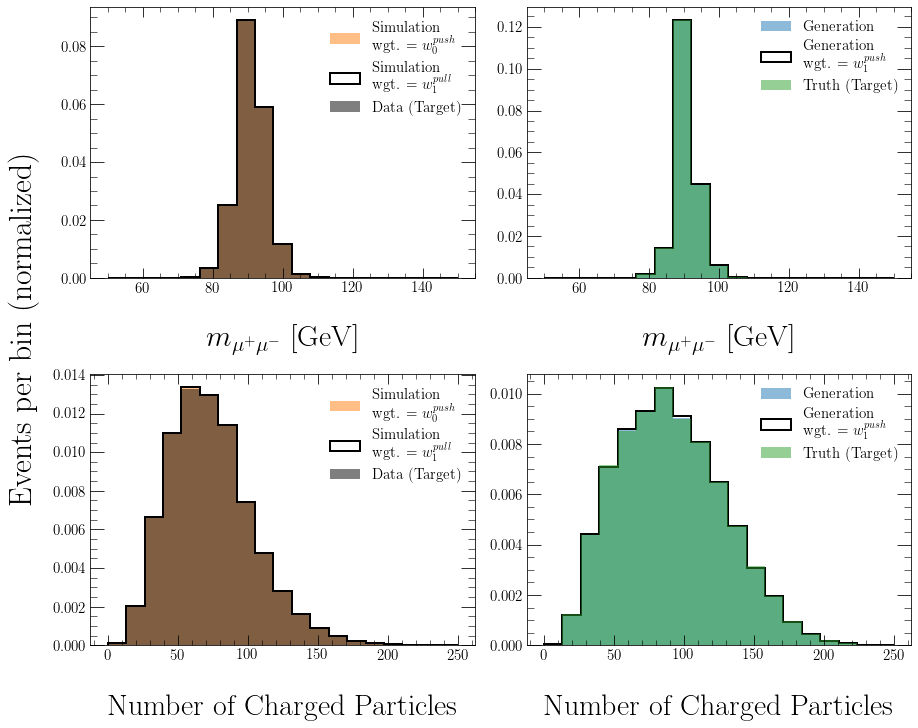

ITERATION: 2


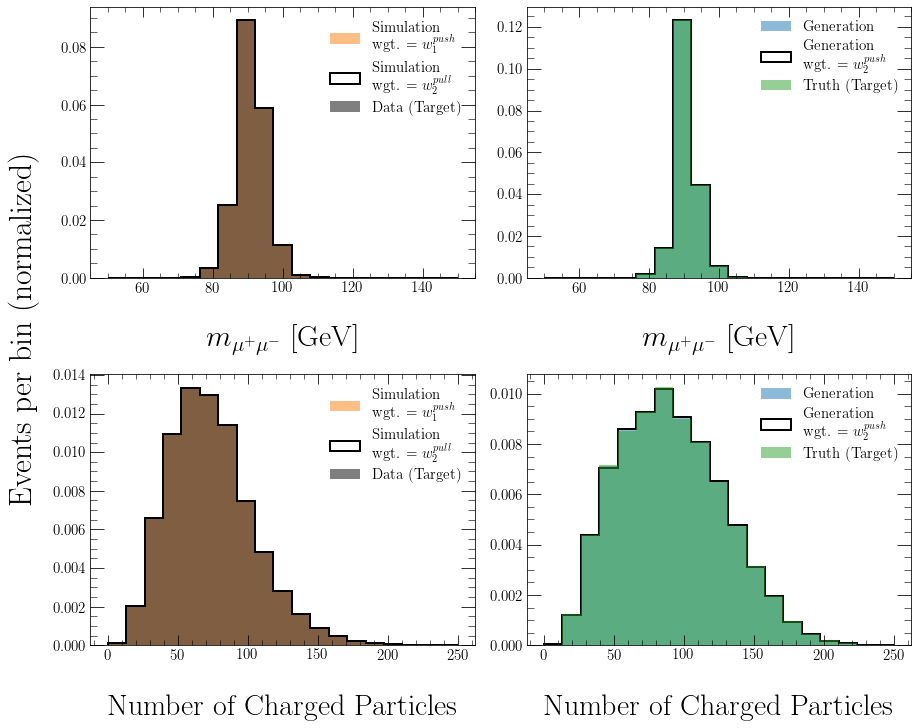

ITERATION: 3


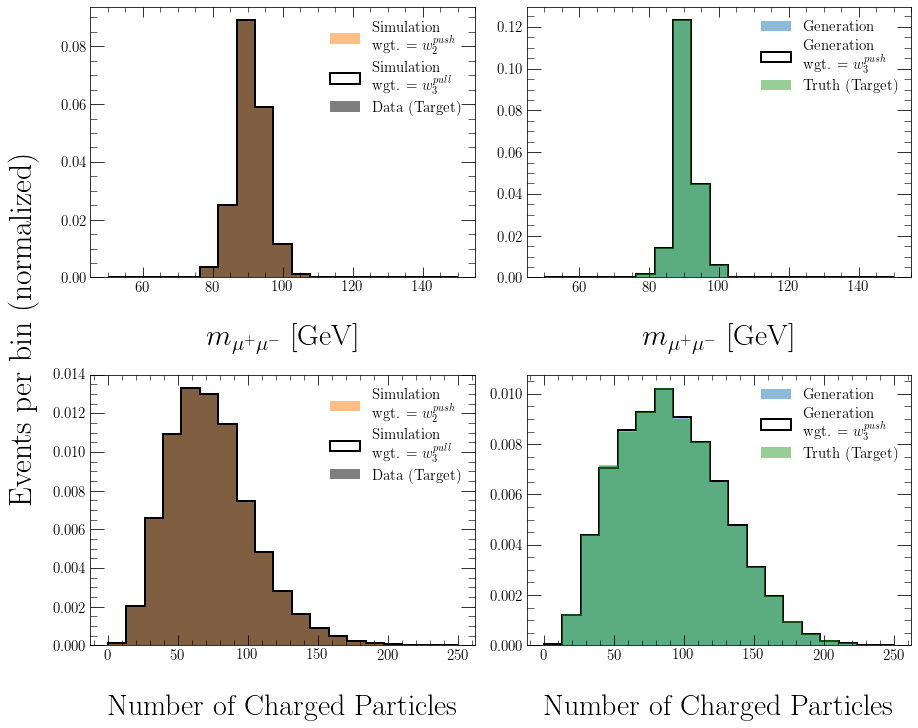

In [35]:
for i in range(len(weights)):
    if i == 0:
        weights_init = np.ones(len(weights[i - 1, 1, :]))
    else:
        weights_init = weights[i - 1, 1, :]

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(50, 150, 20)

    fig, ax = plt.subplots(num_observables,
                           2,
                           figsize=(12, 10),
                           constrained_layout=True)

    ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0, 0].hist(
        m_ll_0_S,
        weights=weights_init,
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) + '}'),
        **plot_style_2,
        color='C1')
    ax[0, 0].hist(
        m_ll_0_S,
        bins=bins,
        weights=weights[i, 0, :],
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)

    ax[0, 0].hist(m_ll_unknown_S,
                  bins=bins,
                  label=r'Data (Target)',
                  **plot_style_2,
                  color='k')
    ax[0, 0].legend(frameon=False)

    ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0, 1].hist(m_ll_0_G,
                  bins=bins,
                  label=r'Generation',
                  **plot_style_2,
                  color='C0')
    ax[0, 1].hist(
        m_ll_0_G,
        bins=bins,
        weights=weights[i, 1, :],
        label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)

    ax[0, 1].hist(m_ll_unknown_G,
                  bins=bins,
                  label=r'Truth (Target)',
                  **plot_style_2,
                  color='C2')
    ax[0, 1].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1, 0].set_xlabel('Number of Charged Particles')
    ax[1, 0].hist(
        nTracks_0_S,
        weights=weights_init,
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) + '}'),
        **plot_style_2,
        color='C1')
    ax[1, 0].hist(
        nTracks_0_S,
        bins=bins,
        weights=weights[i, 1, :],
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)
    ax[1, 0].hist(nTracks_unknown_S,
                  bins=bins,
                  label=r'Data (Target)',
                  **plot_style_2,
                  color='k')
    ax[1, 0].legend(frameon=False)

    ax[1, 1].set_xlabel('Number of Charged Particles')
    ax[1, 1].hist(nTracks_0_G,
                  bins=bins,
                  label=r'Generation',
                  **plot_style_2,
                  color='C0')
    ax[1, 1].hist(
        nTracks_0_G,
        bins=bins,
        weights=weights[i, 1, :],
        label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)
    ax[1, 1].hist(nTracks_unknown_G,
                  bins=bins,
                  label=r'Truth (Target)',
                  **plot_style_2,
                  color='C2')
    ax[1, 1].legend(frameon=False)

    fig.text(-0.05,
             0.55,
             'Events per bin (normalized)',
             va='center',
             rotation='vertical',
             fontsize='x-large')

#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-TechnicalClosureTest-MultiFold-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    fig.show()
    plt.show()

# Stress Test A

Stress weights are nonrandom.

For each observable $x$ in the "unknown" sample, the weight is given roughly by $w \propto x^n$ for some $n$.

## UniFold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles separately.

### Setup Datasets

In [36]:
m_ll_0_G, m_ll_unknown_G, m_ll_0_S, m_ll_unknown_S = train_test_split(Events_0.events['truth_m_ll'][mypass_0],
                                                                      Events_0.events['m_ll'][mypass_0], 
                                                                      test_size=0.5)

In [37]:
scaler_m_ll = preprocessing.StandardScaler()

scaler_m_ll.fit(np.concatenate((m_ll_0_G, m_ll_unknown_G)).reshape(-1,1))

weight_m_ll_seed = np.squeeze(scaler_m_ll.transform(m_ll_unknown_G.reshape(-1,1)))

In [38]:
weights_m_ll_stress = -np.min(weight_m_ll_seed) + weight_m_ll_seed
weights_m_ll_stress = (weights_m_ll_stress)**2
weights_m_ll_stress = weights_m_ll_stress/np.mean(weights_m_ll_stress)

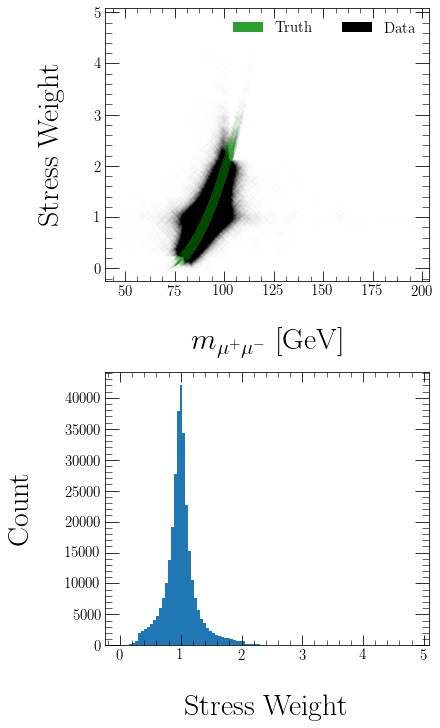

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10), constrained_layout=True)

ax[0].plot(m_ll_unknown_S,
           weights_m_ll_stress,
           'x',
           alpha=0.01,
           label='Data',
           color='k')
ax[0].plot(m_ll_unknown_G,
           weights_m_ll_stress,
           'x',
           alpha=0.01,
           label='Truth',
           color='C2')

ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Stress Weight')
handles = [Patch(facecolor='C2'), Patch(facecolor='k')]
labels = ['Truth', 'Data']
ax[0].legend(handles, labels, ncol=2)

ax[1].hist(weights_m_ll_stress,
           bins=np.linspace(np.min(weights_m_ll_stress),
                            np.max(weights_m_ll_stress), 100))
ax[1].set_xlabel('Stress Weight')
ax[1].set_ylabel('Count')

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-UniFold-m_ll-StressWeights.png',
#     bbox_inches='tight')

fig.show()

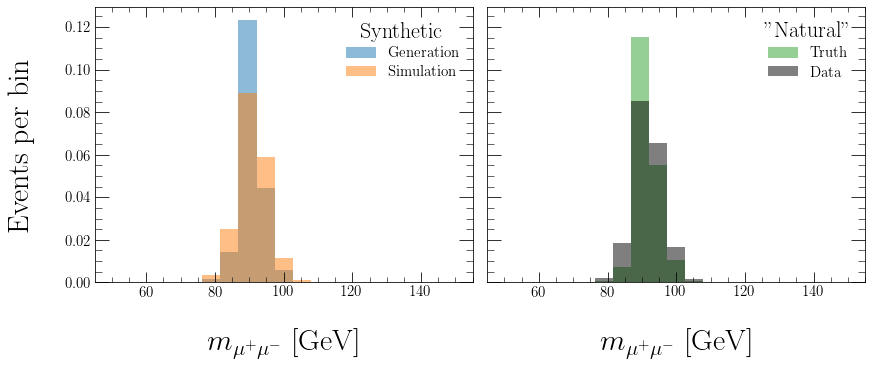

In [40]:
bins = np.linspace(50, 150, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Events per bin')
hG0, _, _ = ax[0].hist(m_ll_0_G,
                       bins=bins,
                       label='Generation',
                       **plot_style_2,
                       color='C0')
hS0, _, _ = ax[0].hist(m_ll_0_S,
                       bins=bins,
                       label='Simulation',
                       **plot_style_2,
                       color='C1')
legend = ax[0].legend(title='Synthetic', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[1].hist(m_ll_unknown_G,
                       weights=weights_m_ll_stress,
                       bins=bins,
                       label='Truth',
                       **plot_style_2,
                       color='C2')
hS1, _, _ = ax[1].hist(m_ll_unknown_S,
                       weights=weights_m_ll_stress,
                       bins=bins,
                       label='Data',
                       **plot_style_2,
                       color='k')
legend = ax[1].legend(title='"Natural"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-UniFold-m_ll-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

In [41]:
nTracks_0_G, nTracks_unknown_G, nTracks_0_S, nTracks_unknown_S = train_test_split(np.array(ntrack_0_Gen),
                                                                      np.array(ntrack_0_Sim), 
                                                                      test_size=0.5)

In [42]:
scaler_nTracks = preprocessing.StandardScaler()

scaler_nTracks.fit(np.concatenate((nTracks_0_G, nTracks_unknown_G)).reshape(-1,1))

weight_nTracks_seed = np.squeeze(scaler_nTracks.transform(nTracks_unknown_G.reshape(-1,1)))

In [43]:
weights_nTracks_stress = -np.min(weight_nTracks_seed) + weight_nTracks_seed
weights_nTracks_stress = (weights_nTracks_stress)**2
weights_nTracks_stress = weights_nTracks_stress/np.mean(weights_nTracks_stress)

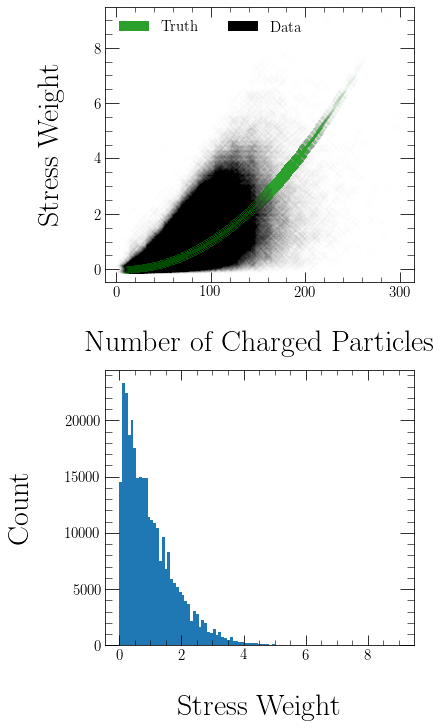

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10), constrained_layout=True)

ax[0].plot(nTracks_unknown_S, weights_nTracks_stress,
           'x',
           alpha=0.01,
           label='Data',
           color='k')
ax[0].plot(nTracks_unknown_G, weights_nTracks_stress,
           'x',
           alpha=0.01,
           label='Truth',
           color='C2')

ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Stress Weight')
handles = [Patch(facecolor='C2'), Patch(facecolor='k')]
labels = ['Truth', 'Data']
ax[0].legend(handles, labels, ncol=2)

ax[1].hist(weights_nTracks_stress,
           bins=np.linspace(np.min(weights_nTracks_stress),
                            np.max(weights_nTracks_stress), 100))
ax[1].set_xlabel('Stress Weight')
ax[1].set_ylabel('Count')

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-UniFold-nTracks-StressWeights.png',
#     bbox_inches='tight')

fig.show()

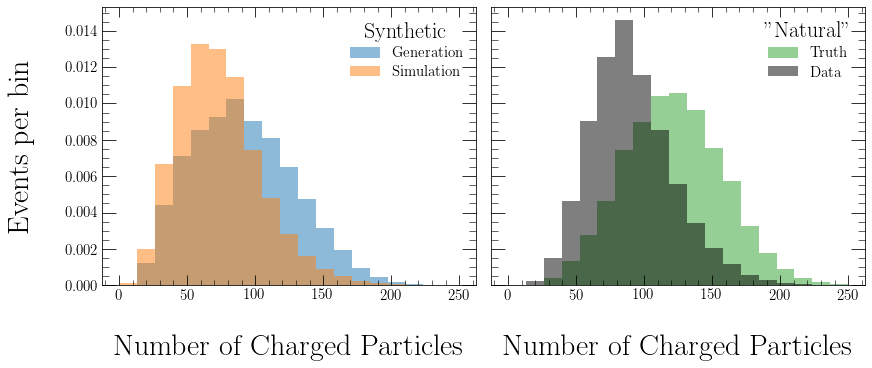

In [45]:
bins = np.linspace(0, 250, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Events per bin')
hG0, _, _ = ax[0].hist(nTracks_0_G,
                       bins=bins,
                       label='Generation',
                       **plot_style_2,
                       color='C0')
hS0, _, _ = ax[0].hist(nTracks_0_S,
                       bins=bins,
                       label='Simulation',
                       **plot_style_2,
                       color='C1')
legend = ax[0].legend(title='Synthetic', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1].hist(nTracks_unknown_G,
                       weights=weights_nTracks_stress,
                       bins=bins,
                       label='Truth',
                       **plot_style_2,
                       color='C2')
hS1, _, _ = ax[1].hist(nTracks_unknown_S,
                       weights=weights_nTracks_stress,
                       bins=bins,
                       label='Data',
                       **plot_style_2,
                       color='k')
legend = ax[1].legend(title='"Natural"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-UniFold-nTracks-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

### Unfold $m_{\mu^+\mu^-}$

In [46]:
# z-score standardization

scaler_G = preprocessing.StandardScaler()
scaler_S = preprocessing.StandardScaler()

scaler_G.fit(m_ll_0_G.reshape(-1,1))
scaler_S.fit(np.concatenate((m_ll_0_S, m_ll_unknown_S)).reshape(-1,1))

theta_0_G = np.squeeze(scaler_G.transform(m_ll_0_G.reshape(-1,1)))
theta_0_S = np.squeeze(scaler_S.transform(m_ll_0_S.reshape(-1,1)))
theta_unknown_S = np.squeeze(scaler_S.transform(m_ll_unknown_S.reshape(-1,1)))

In [47]:
weights, _ = unifold(iterations=10,
                     theta_0_G=theta_0_G,
                     theta_0_S=theta_0_S,
                     theta_unknown_S=theta_unknown_S,
                     weightsMC_unknown=weights_m_ll_stress)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6890 - acc: 0.4998 - val_loss: 0.6889 - val_acc: 0.5005
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6888 - acc: 0.5002 - val_loss: 0.6890 - val_acc: 0.5014
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6888 - acc: 0.5002 - val_loss: 0.6889 - val_acc: 0.5002
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6888 - acc: 0.5003 - val_loss: 0.6890 - val_acc: 0.5004
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6887 - acc: 0.5002 - val_loss: 0.6889 - val_acc: 0.5004
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6887 - acc: 0.5001 - val_loss: 0.6889 - val_acc: 0.5006
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6887 - a

466582/466582 [==============================] - 2s 5us/step - loss: 0.6900 - acc: 0.5001 - val_loss: 0.6902 - val_acc: 0.4990
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6900 - acc: 0.5000 - val_loss: 0.6902 - val_acc: 0.5005
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6900 - acc: 0.5000 - val_loss: 0.6902 - val_acc: 0.5004
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6900 - acc: 0.5003 - val_loss: 0.6902 - val_acc: 0.5002
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6900 - acc: 0.4995 - val_loss: 0.6902 - val_acc: 0.4990
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6900 - acc: 0.5003 - val_loss: 0.6902 - val_acc: 0.5003
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6900 - acc: 0.5003 - val_loss: 0.6902 - val_acc: 0.4991
Epoch 8/200
466582/466582 [============

466582/466582 [==============================] - 1s 2us/step - loss: 0.6913 - acc: 0.5012 - val_loss: 0.6908 - val_acc: 0.4994
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6913 - acc: 0.5009 - val_loss: 0.6908 - val_acc: 0.4990
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6913 - acc: 0.5006 - val_loss: 0.6908 - val_acc: 0.4999
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6913 - acc: 0.5008 - val_loss: 0.6908 - val_acc: 0.4993
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6913 - acc: 0.5008 - val_loss: 0.6908 - val_acc: 0.4992
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6913 - acc: 0.5007 - val_loss: 0.6908 - val_acc: 0.5004
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6912 - acc: 0.5009 - val_loss: 0.6908 - val_acc: 0.5001
Epoch 10/200
466582/466582 [===========

466582/466582 [==============================] - 1s 2us/step - loss: 0.6857 - acc: 0.4997 - val_loss: 0.6859 - val_acc: 0.5005
Epoch 13/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6857 - acc: 0.4998 - val_loss: 0.6859 - val_acc: 0.5004
Epoch 14/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6857 - acc: 0.4999 - val_loss: 0.6859 - val_acc: 0.5004
Epoch 15/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6857 - acc: 0.4998 - val_loss: 0.6859 - val_acc: 0.5004
Epoch 16/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6857 - acc: 0.4997 - val_loss: 0.6859 - val_acc: 0.5004
Epoch 17/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6857 - acc: 0.4998 - val_loss: 0.6859 - val_acc: 0.5004
Epoch 18/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6857 - acc: 0.5000 - val_loss: 0.6859 - val_acc: 0.5003
Restoring model weights from the 

466582/466582 [==============================] - 1s 2us/step - loss: 0.6926 - acc: 0.5006 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 17/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6926 - acc: 0.5003 - val_loss: 0.6935 - val_acc: 0.5004
Restoring model weights from the end of the best epoch
Epoch 00017: early stopping

STEP 2

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6873 - acc: 0.5000 - val_loss: 0.6847 - val_acc: 0.5001
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6850 - acc: 0.4998 - val_loss: 0.6847 - val_acc: 0.5002
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6850 - acc: 0.5000 - val_loss: 0.6847 - val_acc: 0.5001
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6849 - acc: 0.5000 - val_loss: 0.6847 - val_acc: 0.5002
Epoch 5/200
466582/466582 [======

466582/466582 [==============================] - 1s 2us/step - loss: 0.6833 - acc: 0.5000 - val_loss: 0.6832 - val_acc: 0.5000
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6833 - acc: 0.5000 - val_loss: 0.6832 - val_acc: 0.5002
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6833 - acc: 0.4999 - val_loss: 0.6832 - val_acc: 0.5002
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6833 - acc: 0.4999 - val_loss: 0.6832 - val_acc: 0.4999
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6833 - acc: 0.4999 - val_loss: 0.6832 - val_acc: 0.5000
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6833 - acc: 0.5000 - val_loss: 0.6832 - val_acc: 0.5002
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6833 - acc: 0.5000 - val_loss: 0.6832 - val_acc: 0.4999
Epoch 11/200
466582/466582 [==========

466582/466582 [==============================] - 1s 2us/step - loss: 0.6923 - acc: 0.5009 - val_loss: 0.6927 - val_acc: 0.5000
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6923 - acc: 0.5005 - val_loss: 0.6927 - val_acc: 0.5002
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6923 - acc: 0.5009 - val_loss: 0.6927 - val_acc: 0.4994
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6923 - acc: 0.5009 - val_loss: 0.6927 - val_acc: 0.5000
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6923 - acc: 0.5005 - val_loss: 0.6927 - val_acc: 0.5003
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6923 - acc: 0.5019 - val_loss: 0.6927 - val_acc: 0.5004
Epoch 13/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6923 - acc: 0.5009 - val_loss: 0.6927 - val_acc: 0.4997
Epoch 14/200
466582/466582 [=======

#### Results 

ITERATION 1:


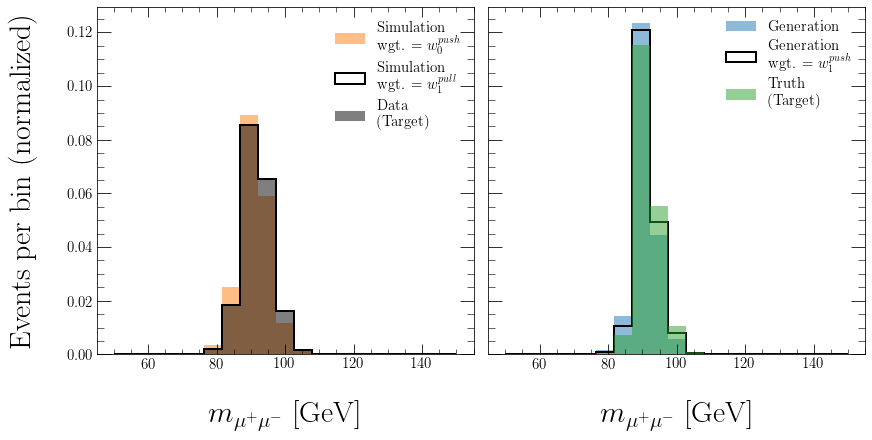

ITERATION 2:


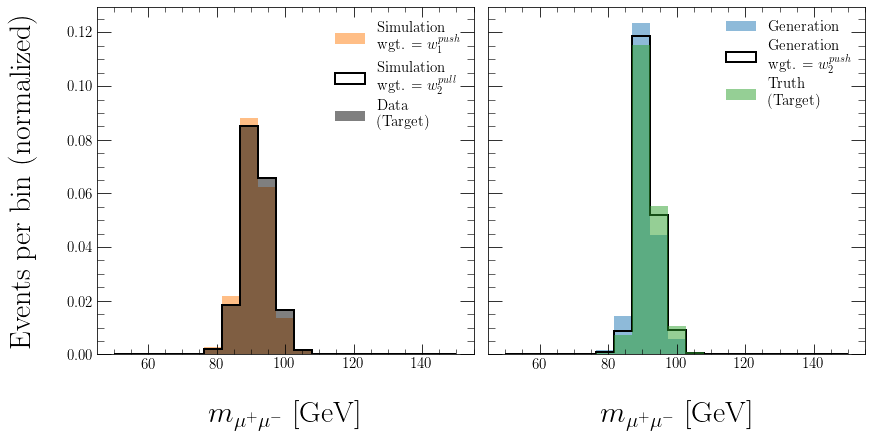

ITERATION 3:


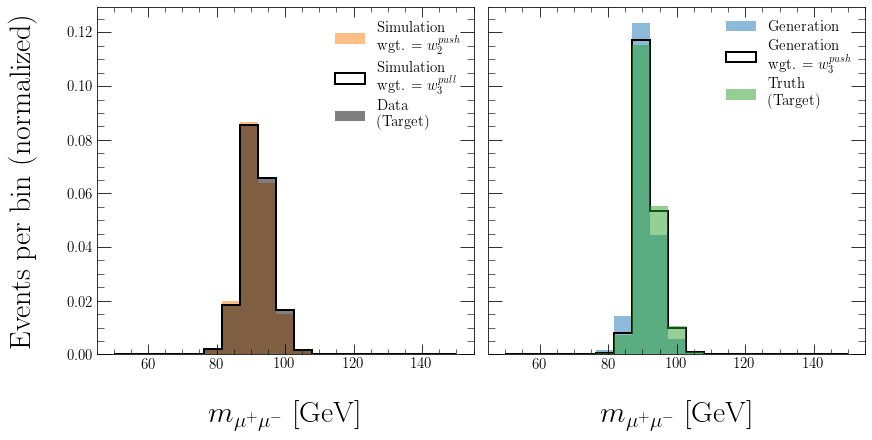

ITERATION 4:


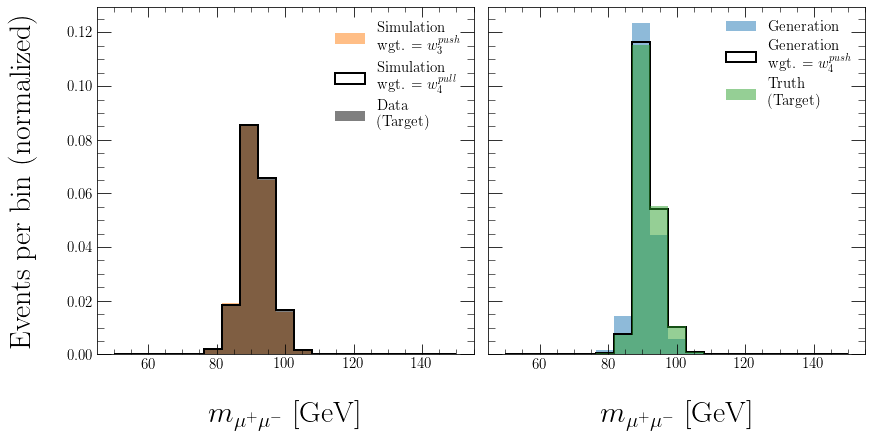

ITERATION 5:


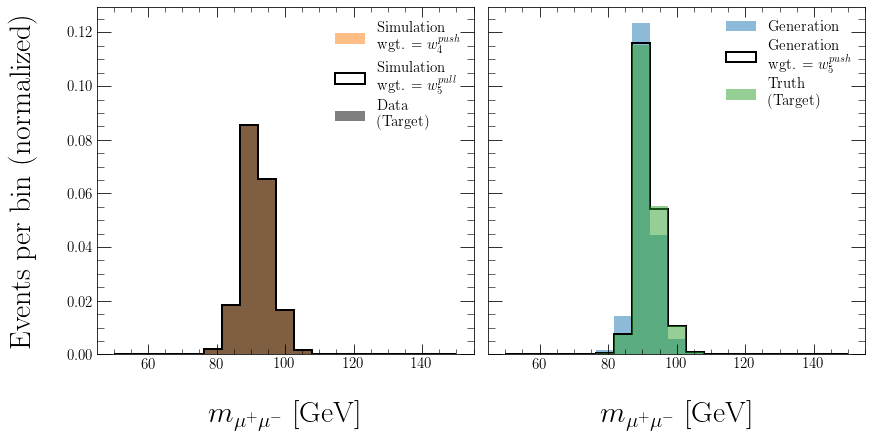

ITERATION 6:


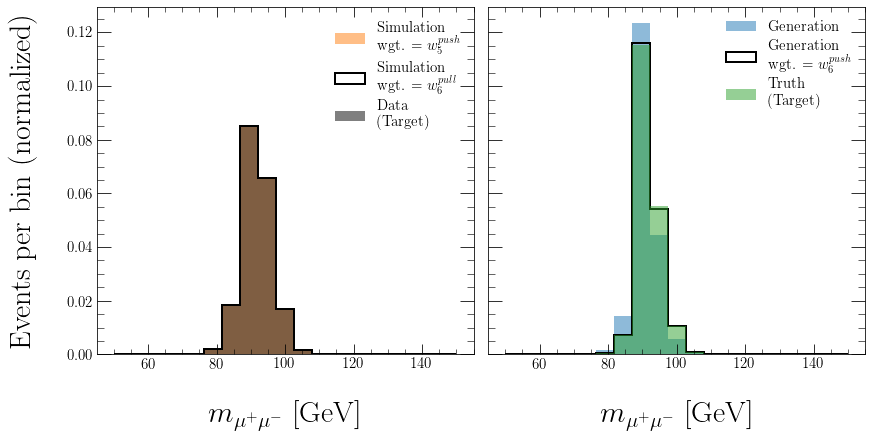

ITERATION 7:


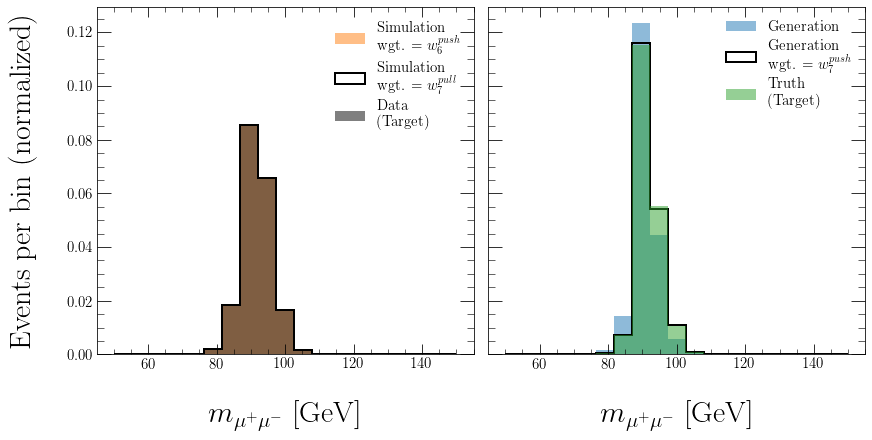

ITERATION 8:


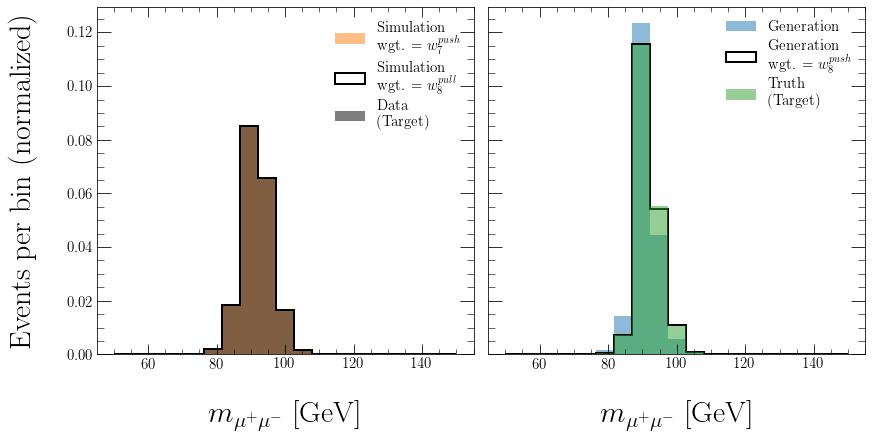

ITERATION 9:


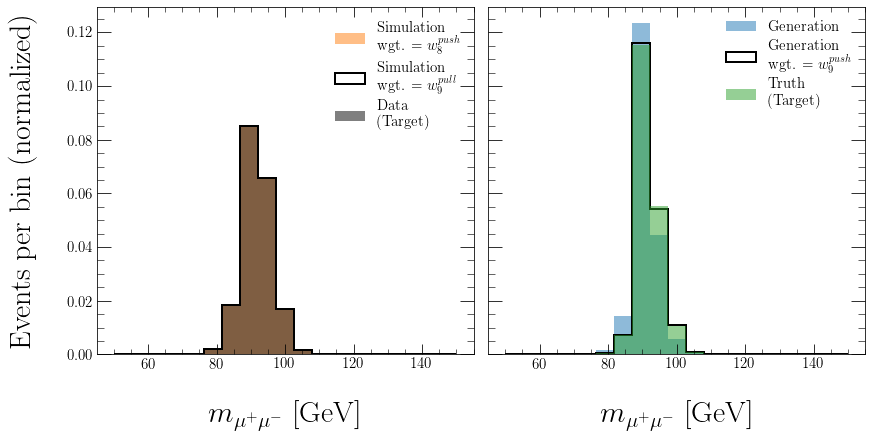

ITERATION 10:


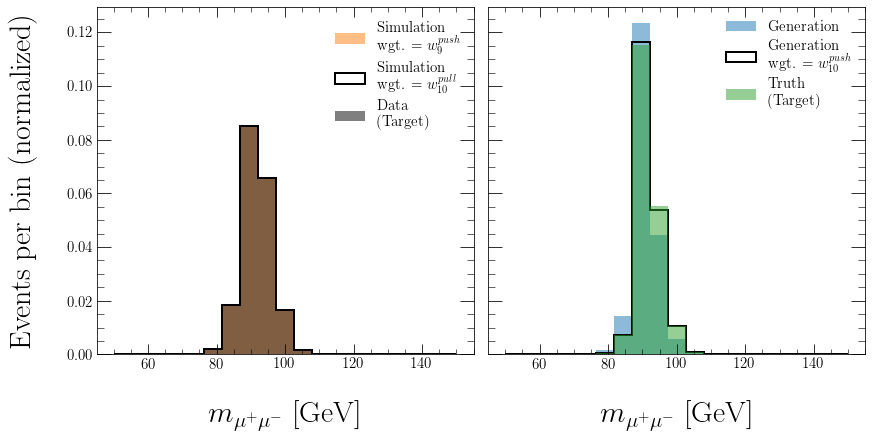

In [48]:
bins = np.linspace(50, 150, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = np.ones(len(m_ll_0_S))
    else:
        weights_init = weights[i - 1, 1, :]

    ax[0].hist(m_ll_0_S,
               weights=weights_init,
               bins=bins,
               label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) +
                                                                 '}'),
               **plot_style_2,
               color='C1')

    ax[0].hist(
        m_ll_0_S,
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        weights=weights[i, 0, :],
        **plot_style_1)
    ax[0].hist(m_ll_unknown_S,
               weights=weights_m_ll_stress,
               bins=bins,
               label='Data\n(Target)',
               **plot_style_2,
               color='k')
    ax[0].set_xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend()
    ax[1].hist(m_ll_0_G, bins=bins, label=r'Generation', **plot_style_2)

    ax[1].hist(
        m_ll_0_G,
        bins=bins,
        label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
        weights=weights[i, 1, :],
        **plot_style_1)
    ax[1].hist(m_ll_unknown_G,
               weights=weights_m_ll_stress,
               bins=bins,
               label='Truth\n(Target)',
               **plot_style_2,
               color='C2')
    ax[1].legend()
    ax[1].set_xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")

    fig.show()
#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-UniFold-m_ll-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    plt.show()

### Unfold Number of Charged Particles

In [49]:
# z-score standardization

scaler_G = preprocessing.StandardScaler()
scaler_S = preprocessing.StandardScaler()

scaler_G.fit(nTracks_0_G.reshape(-1,1))
scaler_S.fit(np.concatenate((nTracks_0_S, nTracks_unknown_S)).reshape(-1,1))

theta_0_G = np.squeeze(scaler_G.transform(nTracks_0_G.reshape(-1,1)))
theta_0_S = np.squeeze(scaler_S.transform(nTracks_0_S.reshape(-1,1)))
theta_unknown_S = np.squeeze(scaler_S.transform(nTracks_unknown_S.reshape(-1,1)))

In [50]:
weights, _ = unifold(iterations=10,
                     theta_0_G=theta_0_G,
                     theta_0_S=theta_0_S,
                     theta_unknown_S=theta_unknown_S,
                     weightsMC_unknown=weights_nTracks_stress)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6623 - acc: 0.5006 - val_loss: 0.6498 - val_acc: 0.4996
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6481 - acc: 0.5001 - val_loss: 0.6484 - val_acc: 0.5002
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6476 - acc: 0.5002 - val_loss: 0.6482 - val_acc: 0.5003
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6475 - acc: 0.5002 - val_loss: 0.6483 - val_acc: 0.4998
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6474 - acc: 0.5004 - val_loss: 0.6481 - val_acc: 0.4998
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6474 - acc: 0.5004 - val_loss: 0.6481 - val_acc: 0.4998
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6474 - a

466582/466582 [==============================] - 1s 2us/step - loss: 0.6436 - acc: 0.5001 - val_loss: 0.6439 - val_acc: 0.4996
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6436 - acc: 0.5001 - val_loss: 0.6439 - val_acc: 0.4996
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6436 - acc: 0.5002 - val_loss: 0.6439 - val_acc: 0.4996
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6436 - acc: 0.5002 - val_loss: 0.6439 - val_acc: 0.4996
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6436 - acc: 0.5002 - val_loss: 0.6440 - val_acc: 0.4996
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6436 - acc: 0.5002 - val_loss: 0.6439 - val_acc: 0.4996
Epoch 13/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6436 - acc: 0.5001 - val_loss: 0.6439 - val_acc: 0.4996
Epoch 14/200
466582/466582 [=======

466582/466582 [==============================] - 1s 2us/step - loss: 0.6276 - acc: 0.5005 - val_loss: 0.6276 - val_acc: 0.4987
Restoring model weights from the end of the best epoch
Epoch 00017: early stopping

ITERATION: 4

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6981 - acc: 0.4998 - val_loss: 0.6906 - val_acc: 0.5013
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6900 - acc: 0.4992 - val_loss: 0.6905 - val_acc: 0.5008
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6900 - acc: 0.4995 - val_loss: 0.6906 - val_acc: 0.5005
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6900 - acc: 0.4993 - val_loss: 0.6906 - val_acc: 0.5015
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6900 - acc: 0.4994 - val_loss: 0.6905 - val_acc: 0.5008
Epoch 6/200
466582/4

466582/466582 [==============================] - 1s 2us/step - loss: 0.6087 - acc: 0.4997 - val_loss: 0.6093 - val_acc: 0.5006
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6086 - acc: 0.4997 - val_loss: 0.6093 - val_acc: 0.5009
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6086 - acc: 0.4995 - val_loss: 0.6093 - val_acc: 0.5009
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6086 - acc: 0.4997 - val_loss: 0.6093 - val_acc: 0.5009
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6086 - acc: 0.4997 - val_loss: 0.6093 - val_acc: 0.5006
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6086 - acc: 0.4998 - val_loss: 0.6093 - val_acc: 0.5009
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6087 - acc: 0.4999 - val_loss: 0.6093 - val_acc: 0.5009
Epoch 13/200
466582/466582 [========

466582/466582 [==============================] - 1s 2us/step - loss: 0.6921 - acc: 0.5012 - val_loss: 0.6924 - val_acc: 0.4999
Epoch 17/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6921 - acc: 0.4999 - val_loss: 0.6924 - val_acc: 0.4988
Epoch 18/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6921 - acc: 0.5010 - val_loss: 0.6924 - val_acc: 0.4986
Epoch 19/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6921 - acc: 0.4998 - val_loss: 0.6924 - val_acc: 0.4996
Epoch 20/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6921 - acc: 0.5002 - val_loss: 0.6924 - val_acc: 0.4982
Epoch 21/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6921 - acc: 0.5003 - val_loss: 0.6924 - val_acc: 0.4998
Epoch 22/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6921 - acc: 0.5010 - val_loss: 0.6924 - val_acc: 0.5003
Epoch 23/200
466582/466582 [=====

466582/466582 [==============================] - 1s 2us/step - loss: 0.6108 - acc: 0.4995 - val_loss: 0.6092 - val_acc: 0.5017
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6108 - acc: 0.4993 - val_loss: 0.6091 - val_acc: 0.5015
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6108 - acc: 0.4995 - val_loss: 0.6092 - val_acc: 0.5017
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6108 - acc: 0.4994 - val_loss: 0.6091 - val_acc: 0.5015
Epoch 13/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6108 - acc: 0.4996 - val_loss: 0.6092 - val_acc: 0.5017
Epoch 14/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6108 - acc: 0.4993 - val_loss: 0.6092 - val_acc: 0.5015
Epoch 15/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6108 - acc: 0.4996 - val_loss: 0.6092 - val_acc: 0.5015
Epoch 16/200
466582/466582 [=====

466582/466582 [==============================] - 1s 2us/step - loss: 0.6960 - acc: 0.4996 - val_loss: 0.6969 - val_acc: 0.5006
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6959 - acc: 0.4989 - val_loss: 0.6969 - val_acc: 0.4996
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6959 - acc: 0.4992 - val_loss: 0.6969 - val_acc: 0.5001
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6959 - acc: 0.4998 - val_loss: 0.6969 - val_acc: 0.5001
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6959 - acc: 0.4997 - val_loss: 0.6970 - val_acc: 0.5007
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6959 - acc: 0.4997 - val_loss: 0.6969 - val_acc: 0.5004
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6959 - acc: 0.5008 - val_loss: 0.6969 - val_acc: 0.4997
Epoch 9/200
466582/466582 [============

#### Results

ITERATION 1:


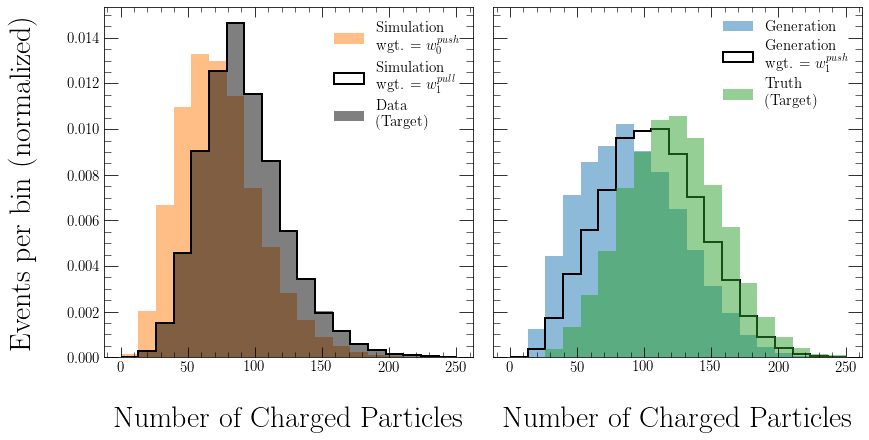

ITERATION 2:


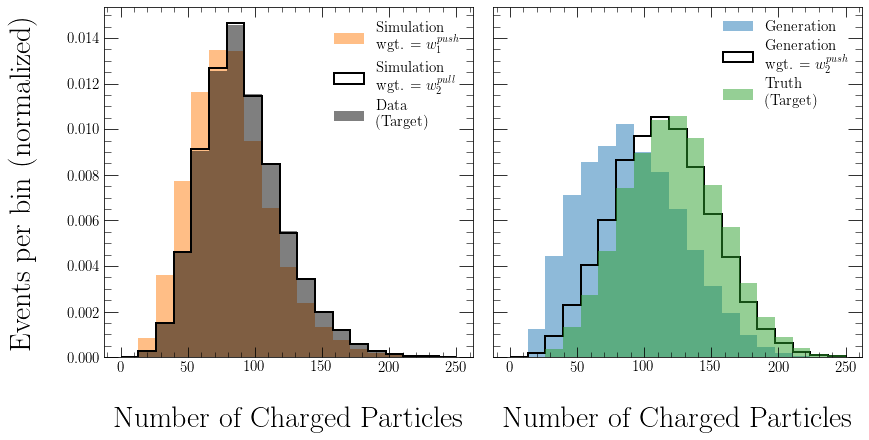

ITERATION 3:


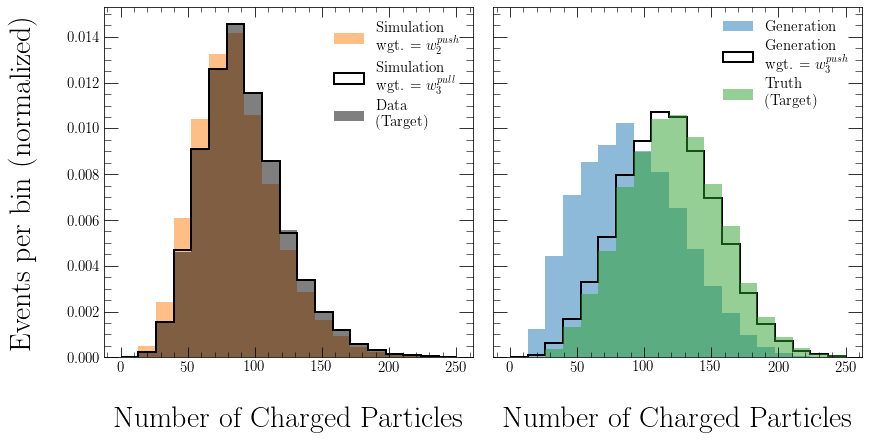

ITERATION 4:


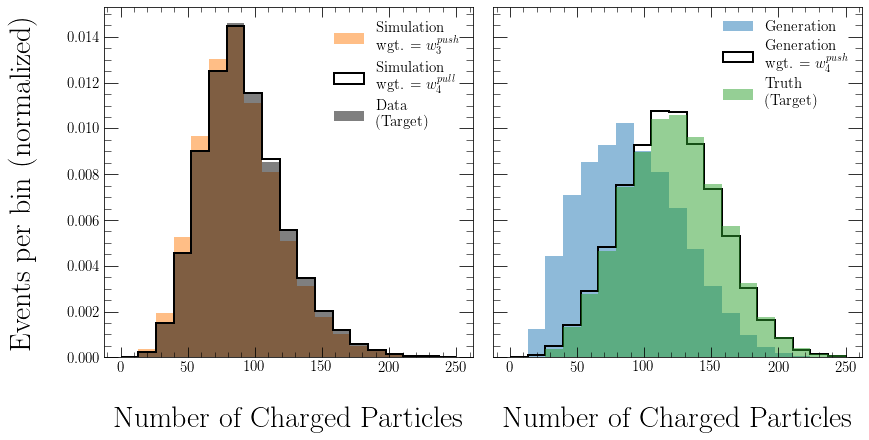

ITERATION 5:


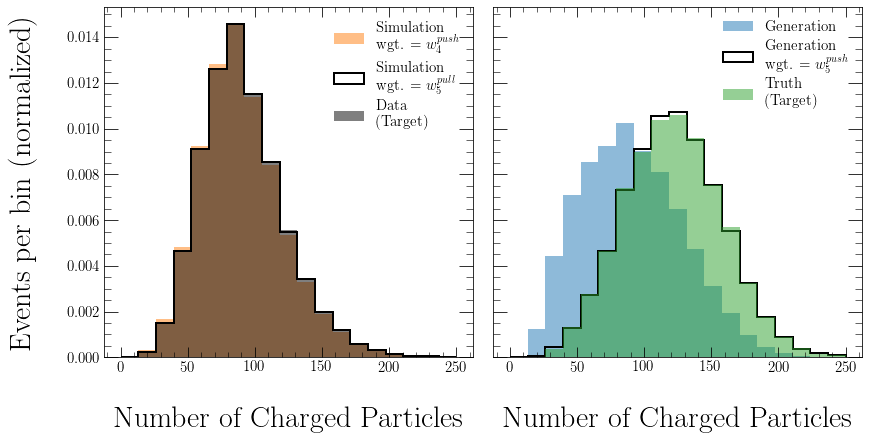

ITERATION 6:


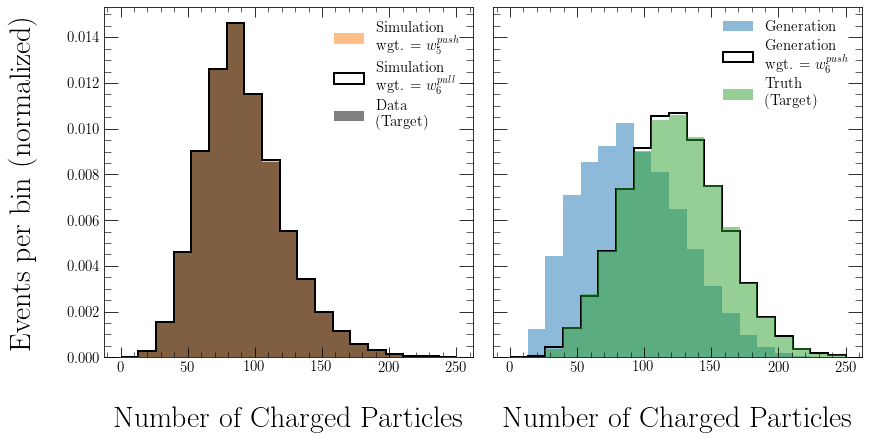

ITERATION 7:


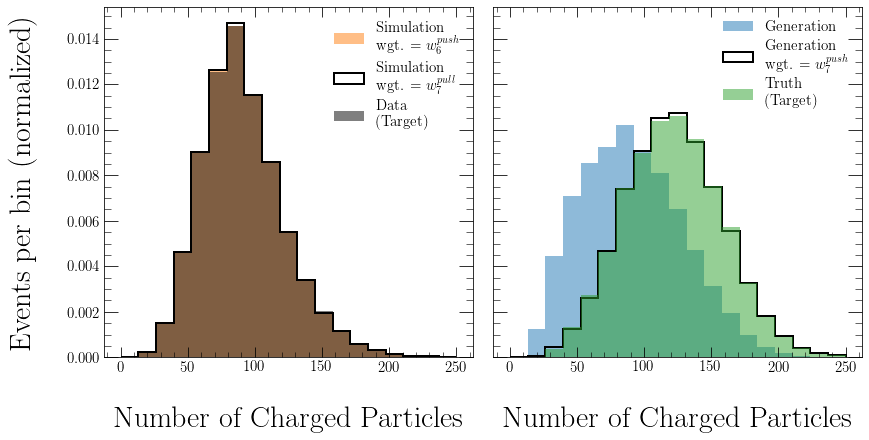

ITERATION 8:


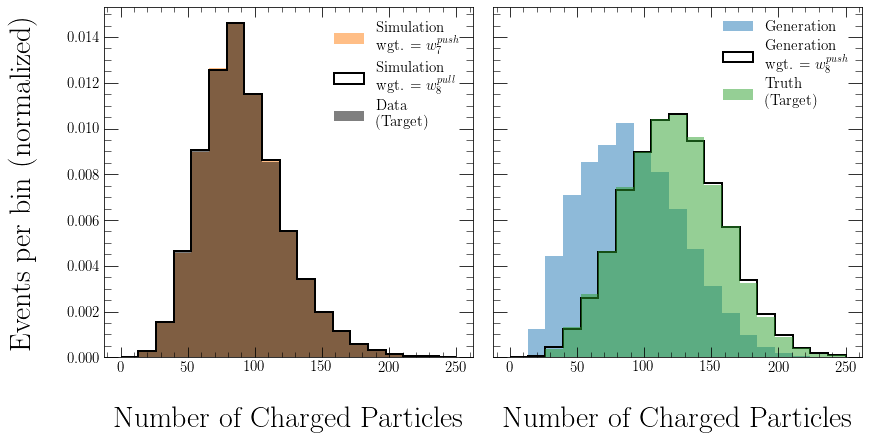

ITERATION 9:


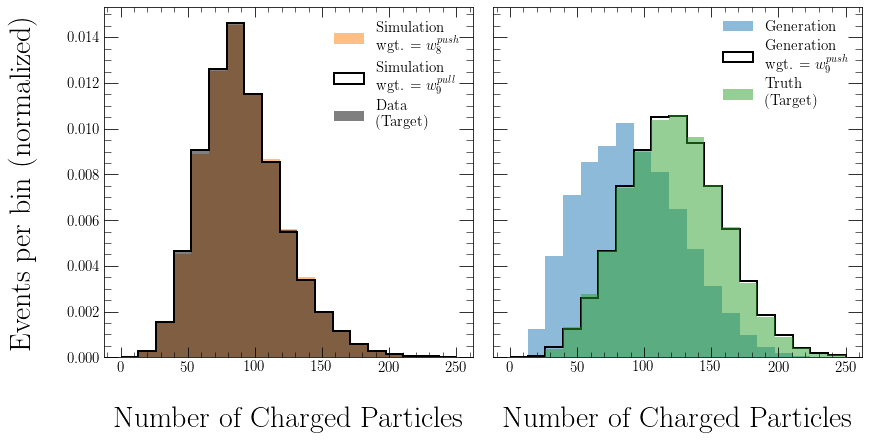

ITERATION 10:


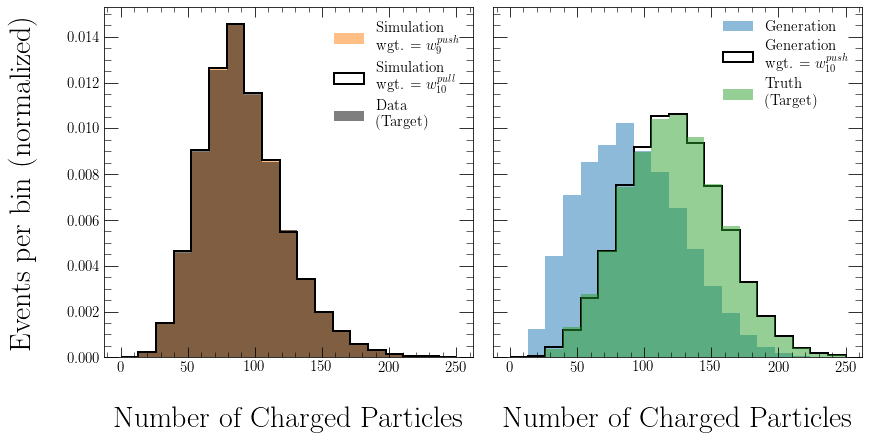

In [51]:
bins = np.linspace(0, 250, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = np.ones(len(nTracks_0_S))
    else:
        weights_init = weights[i - 1, 1, :]

    ax[0].hist(nTracks_0_S,
               weights=weights_init,
               bins=bins,
               label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) +
                                                                 '}'),
               **plot_style_2,
               color='C1')

    ax[0].hist(
        nTracks_0_S,
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        weights=weights[i, 0, :],
        **plot_style_1)
    ax[0].hist(nTracks_unknown_S,
               weights=weights_nTracks_stress,
               bins=bins,
               label='Data\n(Target)',
               **plot_style_2,
               color='k')
    ax[0].set_xlabel(r"Number of Charged Particles")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend()
    ax[1].hist(nTracks_0_G, bins=bins, label=r'Generation', **plot_style_2)

    ax[1].hist(
        nTracks_0_G,
        bins=bins,
        label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
        weights=weights[i, 1, :],
        **plot_style_1)
    ax[1].hist(nTracks_unknown_G,
               weights=weights_nTracks_stress,
               bins=bins,
               label='Truth\n(Target)',
               **plot_style_2,
               color='C2')
    ax[1].legend()
    ax[1].set_xlabel(r"Number of Charged Particles")

    fig.show()
#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-UniFold-nTracks-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    plt.show()

## Multifold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles simultaneously.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the synthetic dataset, and the other half as the unknown "natural" dataset.

In [52]:
K.clear_session()

### Setup datasets

In [53]:
m_ll_0_G, m_ll_unknown_G, m_ll_0_S, m_ll_unknown_S, nTracks_0_G, nTracks_unknown_G, nTracks_0_S, nTracks_unknown_S = train_test_split(
    Events_0.events['truth_m_ll'][mypass_0],
    Events_0.events['m_ll'][mypass_0],
    np.array(ntrack_0_Gen),
    np.array(ntrack_0_Sim),
    test_size=0.5)

In [54]:
scaler_m_ll = preprocessing.StandardScaler()
scaler_m_ll.fit(np.concatenate((m_ll_0_G, m_ll_unknown_G)).reshape(-1,1))

scaler_nTracks = preprocessing.StandardScaler()
scaler_nTracks.fit(np.concatenate((nTracks_0_G, nTracks_unknown_G)).reshape(-1,1))

weight_m_ll_seed = np.squeeze(scaler_m_ll.transform(m_ll_unknown_G.reshape(-1,1)))
weight_nTracks_seed = np.squeeze(scaler_nTracks.transform(nTracks_unknown_G.reshape(-1,1)))

weight_seed = weight_m_ll_seed + weight_nTracks_seed

In [55]:
weights_stress = -np.min(weight_seed) + weight_seed
weights_stress = (weights_stress)**3
weights_stress = weights_stress/np.mean(weights_stress)

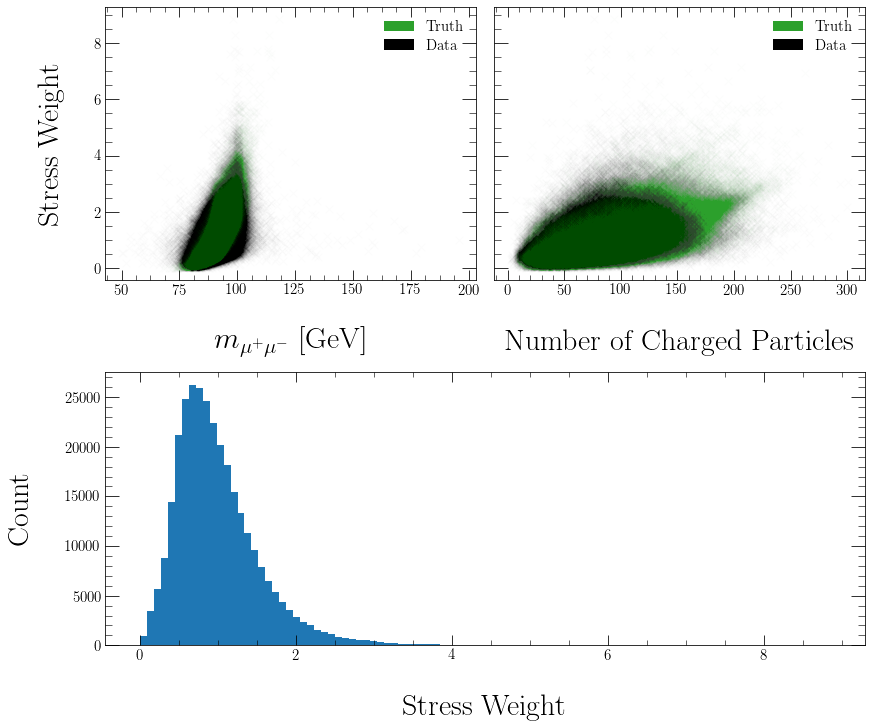

In [56]:
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(m_ll_unknown_S,
         weights_stress,
         'x',
         alpha=0.01,
         color='k',
         label='Data')
ax0.plot(m_ll_unknown_G,
         weights_stress,
         'x',
         alpha=0.01,
         color='C2',
         label='Truth')
ax0.set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax0.set_ylabel('Stress Weight')

ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
plt.setp(ax1.get_yticklabels(), visible=False)
ax1.plot(nTracks_unknown_S,
         weights_stress,
         'x',
         alpha=0.01,
         color='k',
         label='Data')
ax1.plot(nTracks_unknown_G,
         weights_stress,
         'x',
         alpha=0.01,
         color='C2',
         label='Truth')
ax1.set_xlabel('Number of Charged Particles')

handles = [Patch(facecolor='C2'), Patch(facecolor='k')]
labels = ['Truth', 'Data']
ax0.legend(handles, labels)
ax1.legend(handles, labels)

ax2 = fig.add_subplot(gs[1, :])
ax2.hist(weights_stress,
         bins=np.linspace(np.min(weights_stress), np.max(weights_stress), 100))
ax2.set_xlabel('Stress Weight')
ax2.set_ylabel('Count')

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-MultiFold-StressWeights.png',
#     bbox_inches='tight')

fig.show()

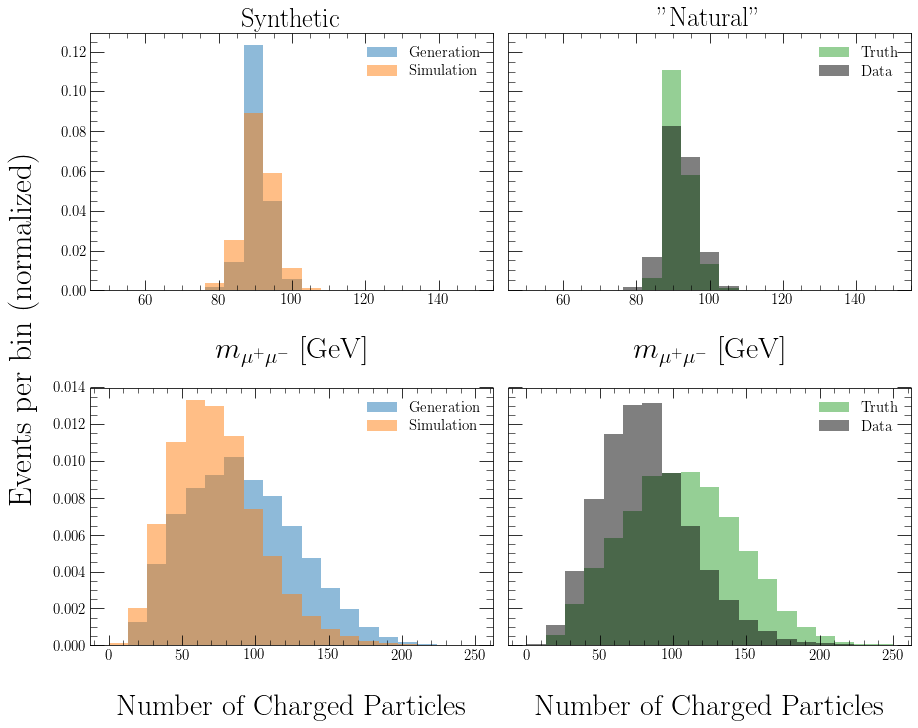

In [57]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 10),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(50, 150, 20)

ax[0, 0].set_title('Synthetic')
ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG0, _, _ = ax[0, 0].hist(m_ll_0_G,
                          bins=bins,
                          label='Generation',
                          **plot_style_2, color='C0')
hS0, _, _ = ax[0, 0].hist(m_ll_0_S,
                          bins=bins,
                          label='Simulation',
                          **plot_style_2, color='C1')
legend = ax[0, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Natural"')
ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[0, 1].hist(m_ll_unknown_G,
                          weights=weights_stress,
                          bins=bins,
                          label='Truth',
                          **plot_style_2, color='C2')
hS1, _, _ = ax[0, 1].hist(m_ll_unknown_S,
                          weights=weights_stress,
                          bins=bins,
                          label='Data',
                          **plot_style_2, color='k')
legend = ax[0, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

bins = np.linspace(0, 250, 20)

ax[1, 0].set_xlabel('Number of Charged Particles')
hG0, _, _ = ax[1, 0].hist(nTracks_0_G,
                          bins=bins,
                          label='Generation',
                          **plot_style_2, color='C0')
hS0, _, _ = ax[1, 0].hist(nTracks_0_S,
                          bins=bins,
                          label='Simulation',
                          **plot_style_2, color='C1')
legend = ax[1, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1, 1].hist(nTracks_unknown_G,
                          weights=weights_stress,
                          bins=bins,
                          label='Truth',
                          **plot_style_2, color='C2')
hS1, _, _ = ax[1, 1].hist(nTracks_unknown_S,
                          weights=weights_stress,
                          bins=bins,
                          label='Data',
                          **plot_style_2, color='k')
legend = ax[1, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.text(-0.05, 0.55,'Events per bin (normalized)', va='center', rotation='vertical', fontsize='x-large')
# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-MultiFold-Distributions.pdf', 
#     bbox_inches='tight')
fig.show()

### Unfold $m_{\mu^+\mu^-}$ and Number of Charged Particles Simultaneously

In [58]:
# z-score standardization

num_observables = 2

scaler_m_ll_G = preprocessing.StandardScaler()
scaler_m_ll_S = preprocessing.StandardScaler()

scaler_m_ll_G.fit(m_ll_0_G.reshape(-1,1))
scaler_m_ll_S.fit(np.concatenate((m_ll_0_S, m_ll_unknown_S)).reshape(-1,1))

scaler_nTracks_G = preprocessing.StandardScaler()
scaler_nTracks_S = preprocessing.StandardScaler()

scaler_nTracks_G.fit(nTracks_0_G.reshape(-1,1))
scaler_nTracks_S.fit(np.concatenate((nTracks_0_S, nTracks_unknown_S)).reshape(-1,1))

theta_0_G = (np.squeeze(scaler_m_ll_G.transform(m_ll_0_G.reshape(-1,1))),
             np.squeeze(scaler_nTracks_G.transform(nTracks_0_G.reshape(-1,1))))

theta_0_S = (np.squeeze(scaler_m_ll_S.transform(m_ll_0_S.reshape(-1,1))),
             np.squeeze(scaler_nTracks_S.transform(nTracks_0_S.reshape(-1,1))))

theta_unknown_S = (np.squeeze(scaler_m_ll_S.transform(m_ll_unknown_S.reshape(-1,1))),
                   np.squeeze(scaler_nTracks_S.transform(nTracks_unknown_S.reshape(-1,1))))

In [59]:
weights, _ = multifold(num_observables=num_observables,
                       iterations=10,
                       theta_0_G=theta_0_G,
                       theta_0_S=theta_0_S,
                       theta_unknown_S=theta_unknown_S,
                       weightsMC_unknown=weights_stress)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 2s 4us/step - loss: 0.6799 - acc: 0.4999 - val_loss: 0.6762 - val_acc: 0.5006
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6764 - acc: 0.4996 - val_loss: 0.6761 - val_acc: 0.5008
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6764 - acc: 0.4999 - val_loss: 0.6759 - val_acc: 0.5008
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6763 - acc: 0.4998 - val_loss: 0.6759 - val_acc: 0.5008
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6763 - acc: 0.4997 - val_loss: 0.6759 - val_acc: 0.5011
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6763 - acc: 0.4997 - val_loss: 0.6759 - val_acc: 0.5006
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6763 - a

466582/466582 [==============================] - 1s 2us/step - loss: 0.6857 - acc: 0.4995 - val_loss: 0.6870 - val_acc: 0.5008
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6857 - acc: 0.4998 - val_loss: 0.6870 - val_acc: 0.5006
Epoch 13/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6857 - acc: 0.4998 - val_loss: 0.6870 - val_acc: 0.5011
Epoch 14/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6858 - acc: 0.4997 - val_loss: 0.6869 - val_acc: 0.5008
Restoring model weights from the end of the best epoch
Epoch 00014: early stopping

ITERATION: 2

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6911 - acc: 0.5002 - val_loss: 0.6923 - val_acc: 0.4982
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6910 - acc: 0.5002 - val_loss: 0.6923 - val_acc: 0.4985
Epoch 3/200
46658


STEP 2

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6719 - acc: 0.5004 - val_loss: 0.6689 - val_acc: 0.4991
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6683 - acc: 0.5003 - val_loss: 0.6689 - val_acc: 0.4988
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6683 - acc: 0.5003 - val_loss: 0.6689 - val_acc: 0.4988
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6683 - acc: 0.5003 - val_loss: 0.6689 - val_acc: 0.4988
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6683 - acc: 0.5004 - val_loss: 0.6689 - val_acc: 0.4986
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6683 - acc: 0.5006 - val_loss: 0.6689 - val_acc: 0.4987
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6683 - acc: 0.5004 - v

466582/466582 [==============================] - 1s 2us/step - loss: 0.6609 - acc: 0.4999 - val_loss: 0.6606 - val_acc: 0.5003
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6609 - acc: 0.4999 - val_loss: 0.6605 - val_acc: 0.4999
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6609 - acc: 0.4998 - val_loss: 0.6605 - val_acc: 0.5003
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6609 - acc: 0.4998 - val_loss: 0.6606 - val_acc: 0.5002
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6609 - acc: 0.4999 - val_loss: 0.6605 - val_acc: 0.5001
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6609 - acc: 0.4999 - val_loss: 0.6606 - val_acc: 0.5001
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6609 - acc: 0.5000 - val_loss: 0.6605 - val_acc: 0.5001
Epoch 9/200
466582/466582 [============


STEP 2

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6696 - acc: 0.4998 - val_loss: 0.6601 - val_acc: 0.5009
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6601 - acc: 0.4998 - val_loss: 0.6600 - val_acc: 0.5008
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6601 - acc: 0.4997 - val_loss: 0.6601 - val_acc: 0.5010
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6601 - acc: 0.4997 - val_loss: 0.6601 - val_acc: 0.5006
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6601 - acc: 0.4996 - val_loss: 0.6601 - val_acc: 0.5009
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6601 - acc: 0.4997 - val_loss: 0.6601 - val_acc: 0.5007
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6601 - acc: 0.4998 - v

466582/466582 [==============================] - 1s 2us/step - loss: 0.6975 - acc: 0.5025 - val_loss: 0.6977 - val_acc: 0.5003
Epoch 20/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6975 - acc: 0.5025 - val_loss: 0.6977 - val_acc: 0.4997
Epoch 21/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6975 - acc: 0.5025 - val_loss: 0.6977 - val_acc: 0.5001
Restoring model weights from the end of the best epoch
Epoch 00021: early stopping

STEP 2

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6682 - acc: 0.5005 - val_loss: 0.6580 - val_acc: 0.5002
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6580 - acc: 0.5000 - val_loss: 0.6578 - val_acc: 0.4999
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6579 - acc: 0.5000 - val_loss: 0.6577 - val_acc: 0.4997
Epoch 4/200
466582/466582 [=====

#### Results

ITERATION: 1


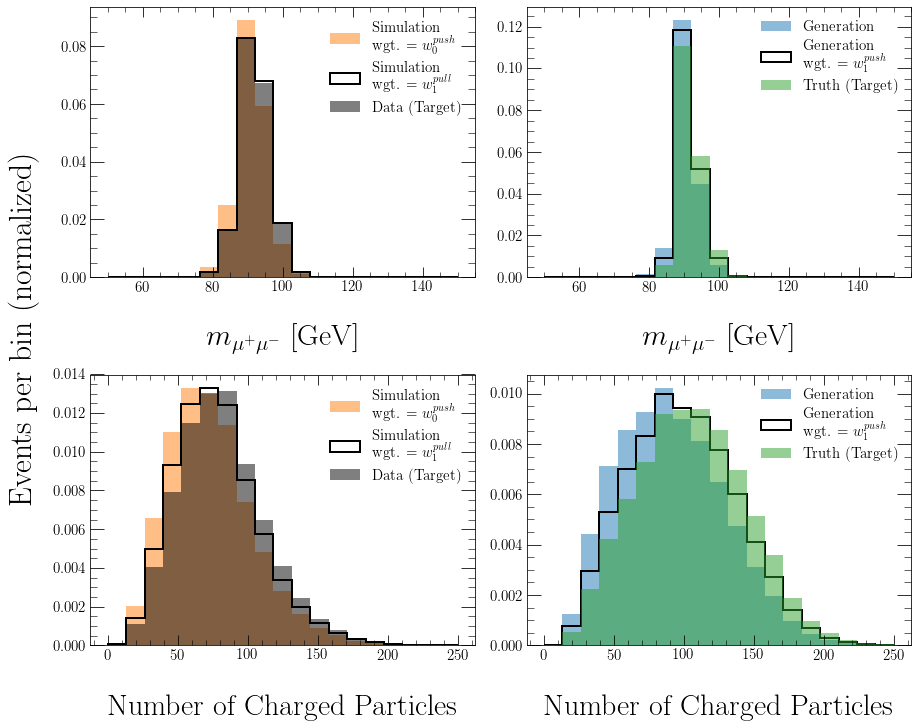

ITERATION: 2


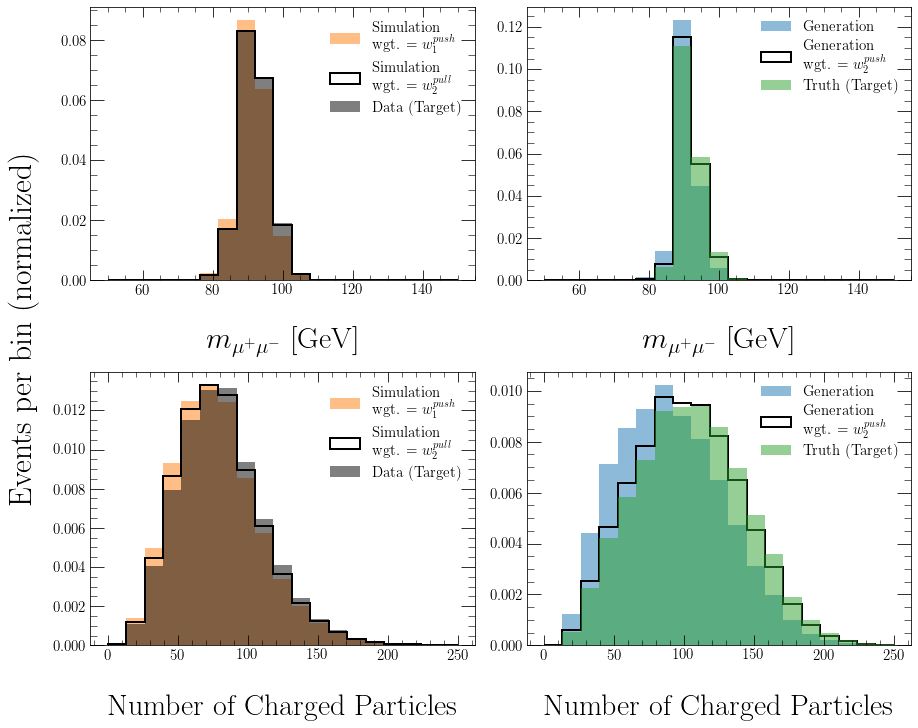

ITERATION: 3


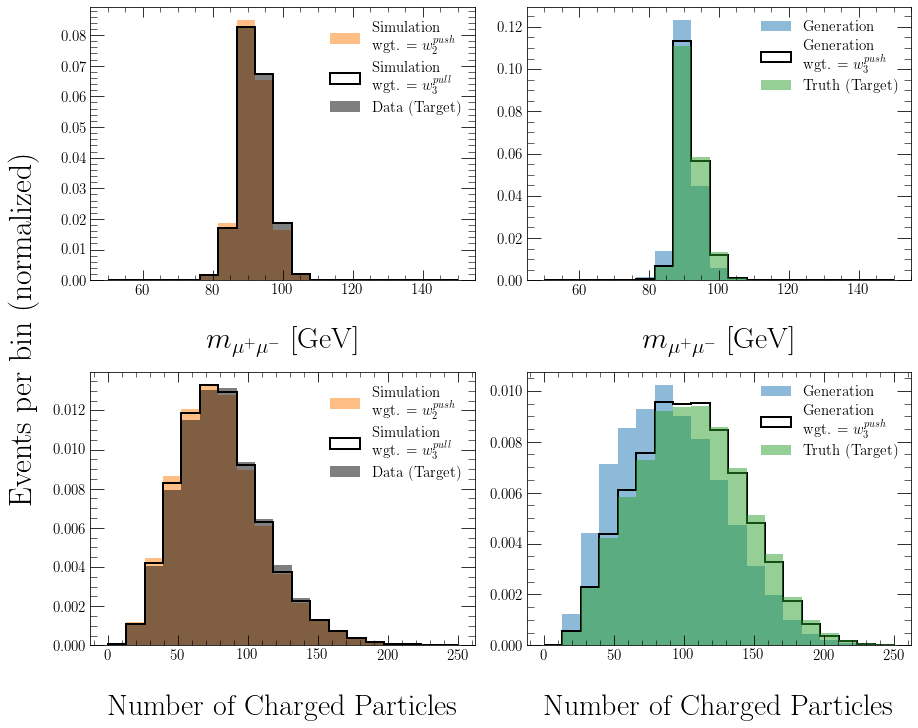

ITERATION: 4


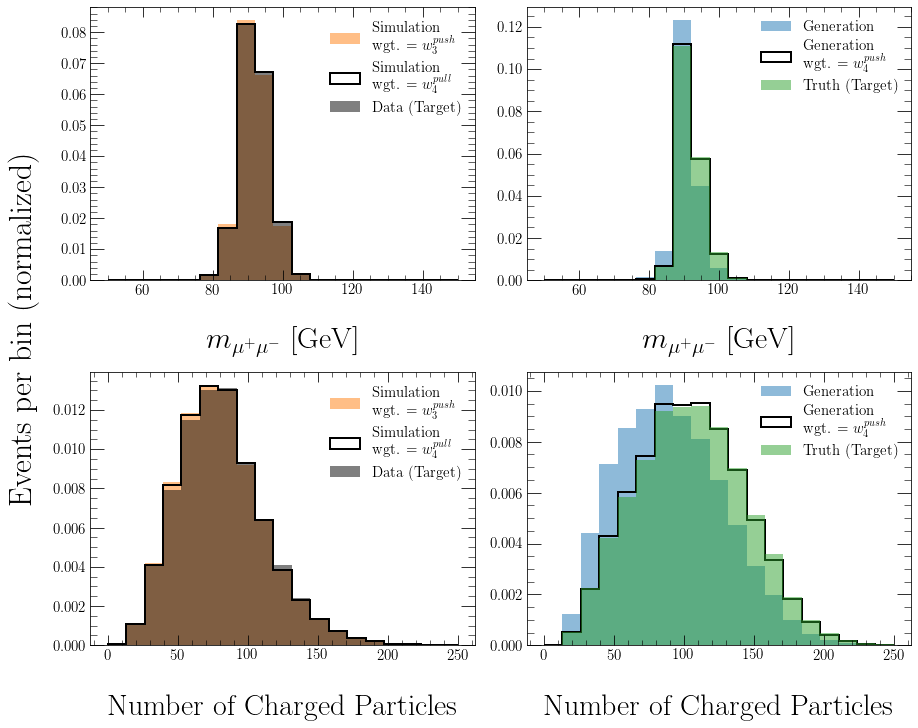

ITERATION: 5


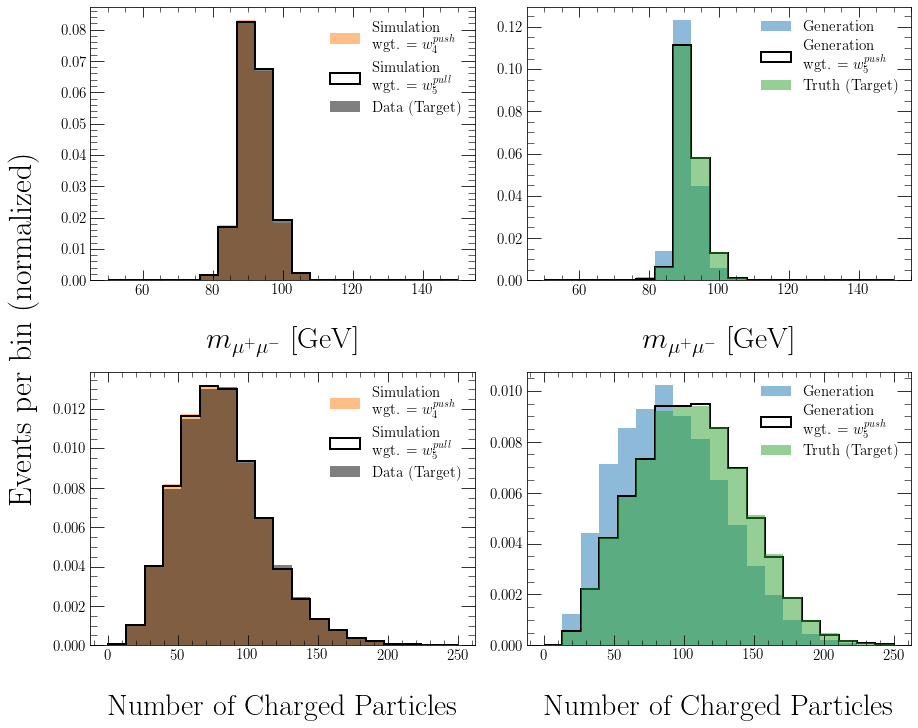

ITERATION: 6


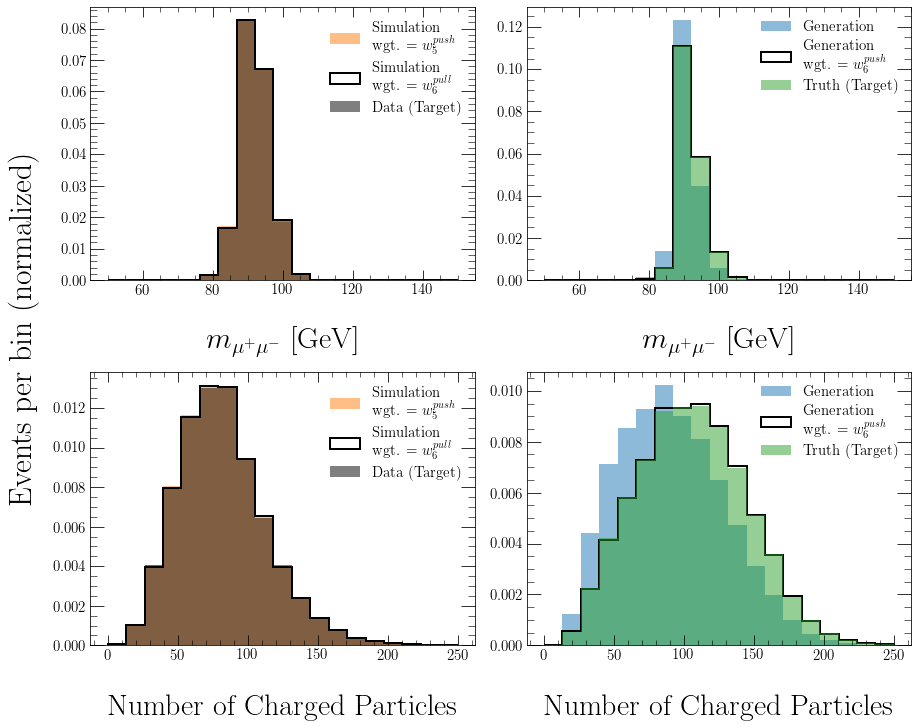

ITERATION: 7


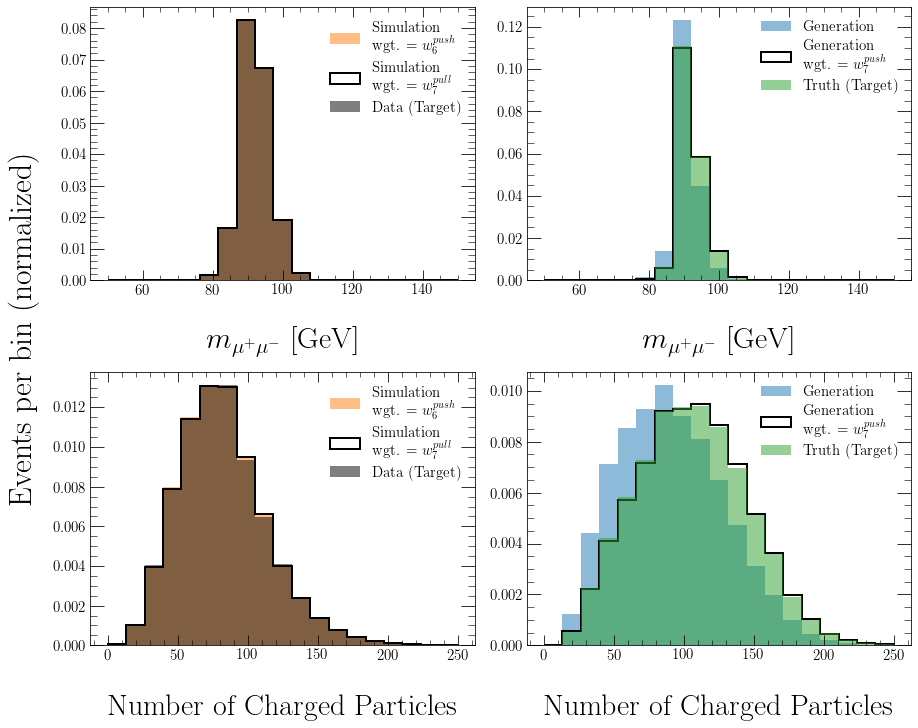

ITERATION: 8


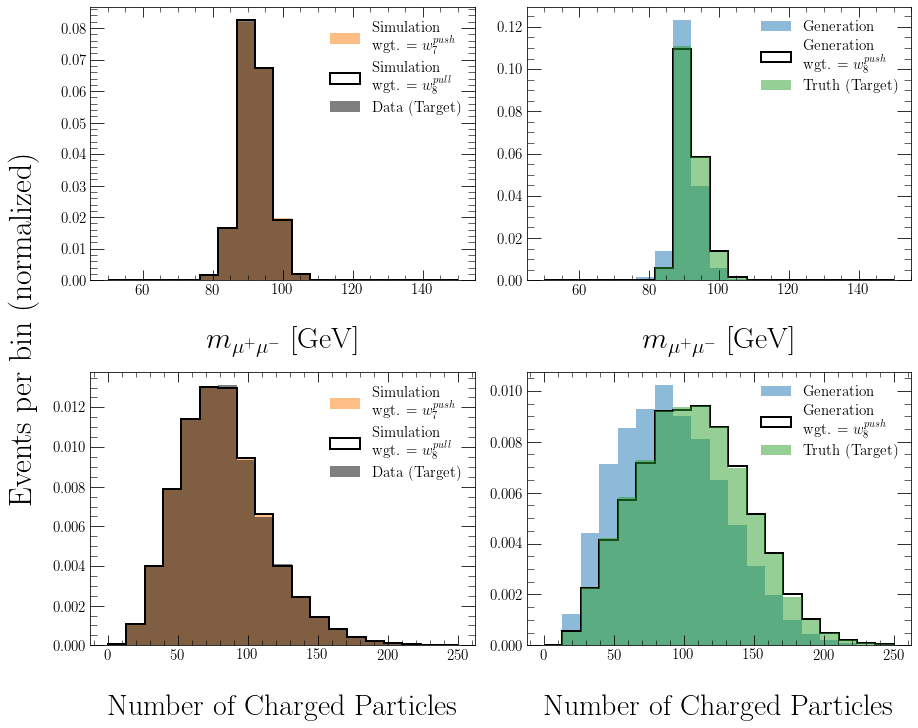

ITERATION: 9


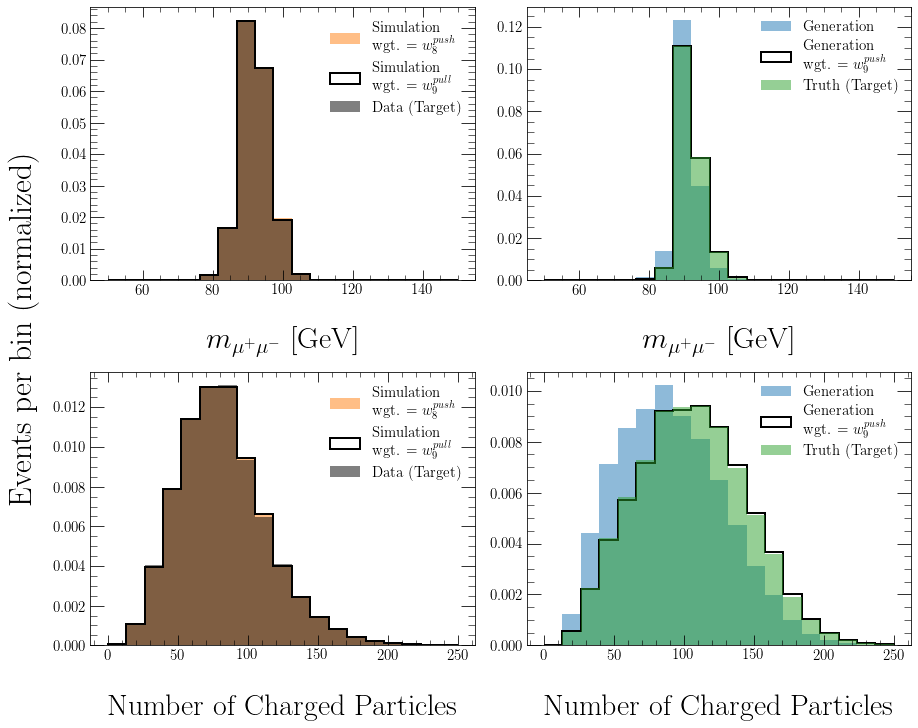

ITERATION: 10


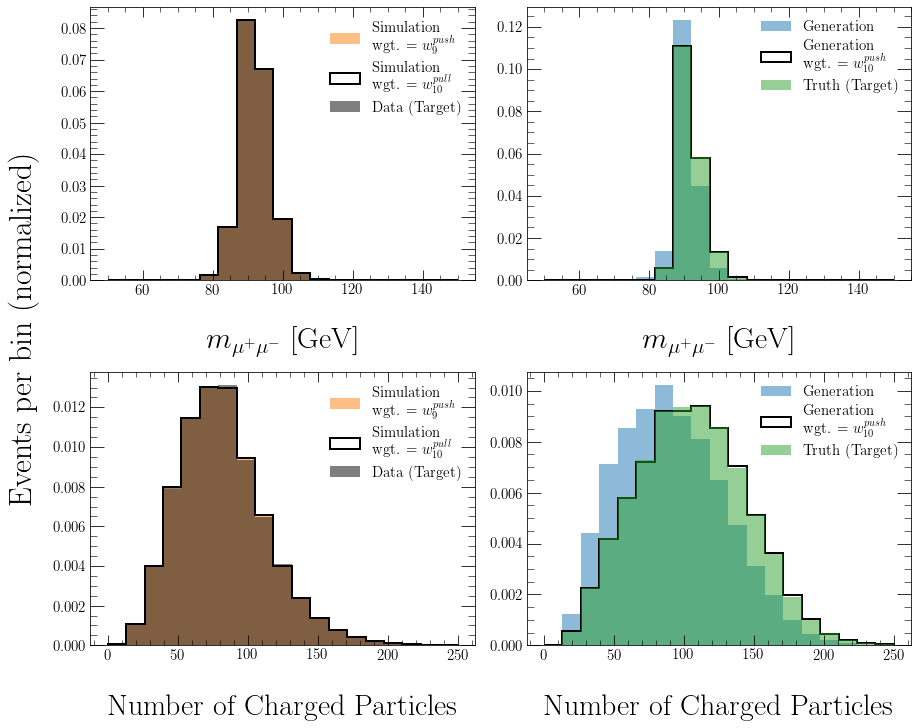

In [60]:
for i in range(len(weights)):
    if i == 0:
        weights_init = np.ones(len(weights[i - 1, 1, :]))
    else:
        weights_init = weights[i - 1, 1, :]

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(50, 150, 20)

    fig, ax = plt.subplots(num_observables,
                           2,
                           figsize=(12, 10),
                           constrained_layout=True)

    ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0, 0].hist(
        m_ll_0_S,
        weights=weights_init,
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) + '}'),
        **plot_style_2,
        color='C1')
    ax[0, 0].hist(
        m_ll_0_S,
        bins=bins,
        weights=weights[i, 0, :],
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)

    ax[0, 0].hist(m_ll_unknown_S,
                  weights=weights_stress,
                  bins=bins,
                  label=r'Data (Target)',
                  **plot_style_2,
                  color='k')
    ax[0, 0].legend(frameon=False)

    ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0, 1].hist(m_ll_0_G,
                  bins=bins,
                  label=r'Generation',
                  **plot_style_2,
                  color='C0')
    ax[0, 1].hist(
        m_ll_0_G,
        bins=bins,
        weights=weights[i, 1, :],
        label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)

    ax[0, 1].hist(m_ll_unknown_G,
                  bins=bins,
                  weights=weights_stress,
                  label=r'Truth (Target)',
                  **plot_style_2,
                  color='C2')
    ax[0, 1].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1, 0].set_xlabel('Number of Charged Particles')
    ax[1, 0].hist(
        nTracks_0_S,
        weights=weights_init,
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) + '}'),
        **plot_style_2,
        color='C1')
    ax[1, 0].hist(
        nTracks_0_S,
        bins=bins,
        weights=weights[i, 1, :],
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)
    ax[1, 0].hist(nTracks_unknown_S,
                  weights=weights_stress,
                  bins=bins,
                  label=r'Data (Target)',
                  **plot_style_2,
                  color='k')
    ax[1, 0].legend(frameon=False)

    ax[1, 1].set_xlabel('Number of Charged Particles')
    ax[1, 1].hist(nTracks_0_G,
                  bins=bins,
                  label=r'Generation',
                  **plot_style_2,
                  color='C0')
    ax[1, 1].hist(
        nTracks_0_G,
        bins=bins,
        weights=weights[i, 1, :],
        label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)
    ax[1, 1].hist(nTracks_unknown_G,
                  weights=weights_stress,
                  bins=bins,
                  label=r'Truth (Target)',
                  **plot_style_2,
                  color='C2')
    ax[1, 1].legend(frameon=False)

    fig.text(-0.05,
             0.55,
             'Events per bin (normalized)',
             va='center',
             rotation='vertical',
             fontsize='x-large')

#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-MultiFold-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    fig.show()
    plt.show()

# Stress Test B
Stress weights are based on a random variable.
After standardizing (z-score) each observable $x$ to $x'$, the weights are given by $w\sim  \mathcal{N}(0, \text{sigmoid}(x'))$.

## UniFold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles separately.

### Setup Datasets

In [61]:
m_ll_0_G, m_ll_unknown_G, m_ll_0_S, m_ll_unknown_S = train_test_split(Events_0.events['truth_m_ll'][mypass_0],
                                                                      Events_0.events['m_ll'][mypass_0], 
                                                                      test_size=0.5)

In [62]:
scaler_m_ll = preprocessing.StandardScaler()

scaler_m_ll.fit(np.concatenate((m_ll_0_G, m_ll_unknown_G)).reshape(-1,1))

weight_m_ll_seed = np.squeeze(scaler_m_ll.transform(m_ll_unknown_G.reshape(-1,1)))

In [63]:
weights_m_ll_stress = [
    abs(np.random.normal(0, sigmoid(std))) for std in weight_m_ll_seed
]
weights_m_ll_stress = np.array(weights_m_ll_stress)
weights_m_ll_stress = weights_m_ll_stress / np.mean(weights_m_ll_stress)

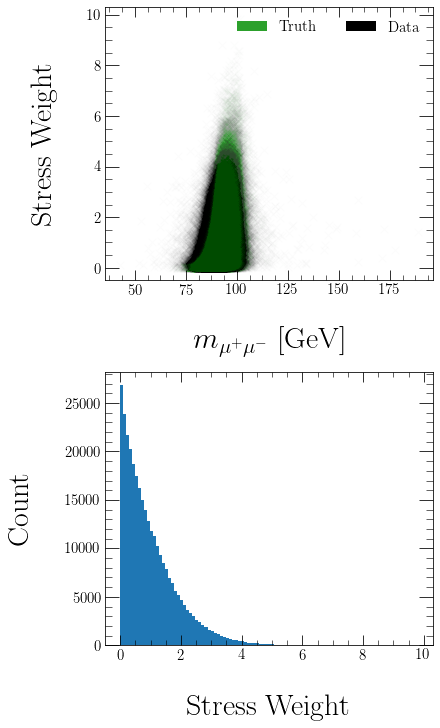

In [64]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10), constrained_layout=True)

ax[0].plot(m_ll_unknown_S,
           weights_m_ll_stress,
           'x',
           alpha=0.01,
           label='Data',
           color='k')
ax[0].plot(m_ll_unknown_G,
           weights_m_ll_stress,
           'x',
           alpha=0.01,
           label='Truth',
           color='C2')

ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Stress Weight')
handles = [Patch(facecolor='C2'), Patch(facecolor='k')]
labels = ['Truth', 'Data']
ax[0].legend(handles, labels, ncol=2)

ax[1].hist(weights_m_ll_stress,
           bins=np.linspace(np.min(weights_m_ll_stress),
                            np.max(weights_m_ll_stress), 100))
ax[1].set_xlabel('Stress Weight')
ax[1].set_ylabel('Count')

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-UniFold-m_ll-StressWeights.png',
#     bbox_inches='tight')

fig.show()

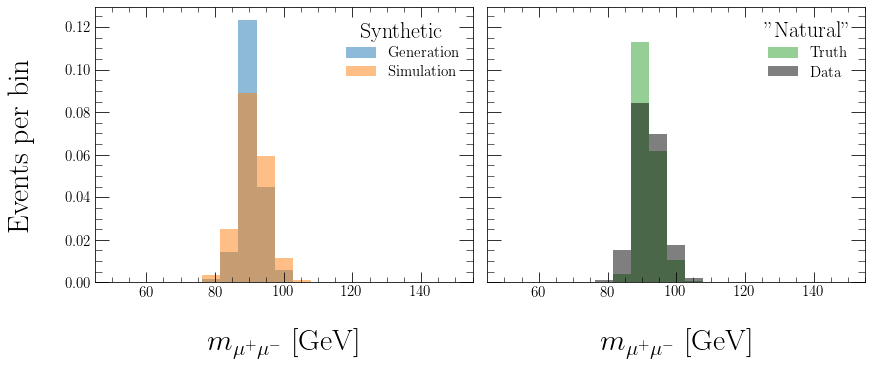

In [65]:
bins = np.linspace(50, 150, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Events per bin')
hG0, _, _ = ax[0].hist(m_ll_0_G,
                       bins=bins,
                       label='Generation',
                       **plot_style_2,
                       color='C0')
hS0, _, _ = ax[0].hist(m_ll_0_S,
                       bins=bins,
                       label='Simulation',
                       **plot_style_2,
                       color='C1')
legend = ax[0].legend(title='Synthetic', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[1].hist(m_ll_unknown_G,
                       weights=weights_m_ll_stress,
                       bins=bins,
                       label='Truth',
                       **plot_style_2,
                       color='C2')
hS1, _, _ = ax[1].hist(m_ll_unknown_S,
                       weights=weights_m_ll_stress,
                       bins=bins,
                       label='Data',
                       **plot_style_2,
                       color='k')
legend = ax[1].legend(title='"Natural"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-UniFold-m_ll-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

In [66]:
nTracks_0_G, nTracks_unknown_G, nTracks_0_S, nTracks_unknown_S = train_test_split(np.array(ntrack_0_Gen),
                                                                      np.array(ntrack_0_Sim), 
                                                                      test_size=0.5)

In [67]:
scaler_nTracks = preprocessing.StandardScaler()

scaler_nTracks.fit(np.concatenate((nTracks_0_G, nTracks_unknown_G)).reshape(-1,1))

weight_nTracks_seed = np.squeeze(scaler_nTracks.transform(nTracks_unknown_G.reshape(-1,1)))

In [68]:
weights_nTracks_stress = [abs(np.random.normal(0, sigmoid(std))) for std in weight_nTracks_seed]
weights_nTracks_stress = np.array(weights_nTracks_stress)
weights_nTracks_stress = weights_nTracks_stress/np.mean(weights_nTracks_stress)

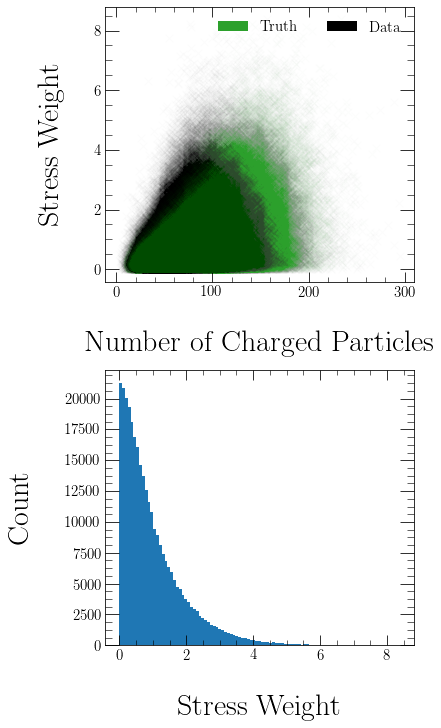

In [69]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10), constrained_layout=True)

ax[0].plot(nTracks_unknown_S, weights_nTracks_stress,
           'x',
           alpha=0.01,
           label='Data',
           color='k')
ax[0].plot(nTracks_unknown_G, weights_nTracks_stress,
           'x',
           alpha=0.01,
           label='Truth',
           color='C2')

ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Stress Weight')
handles = [Patch(facecolor='C2'), Patch(facecolor='k')]
labels = ['Truth', 'Data']
ax[0].legend(handles, labels, ncol=2)

ax[1].hist(weights_nTracks_stress,
           bins=np.linspace(np.min(weights_nTracks_stress),
                            np.max(weights_nTracks_stress), 100))
ax[1].set_xlabel('Stress Weight')
ax[1].set_ylabel('Count')

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-UniFold-nTracks-StressWeights.png',
#     bbox_inches='tight')

fig.show()

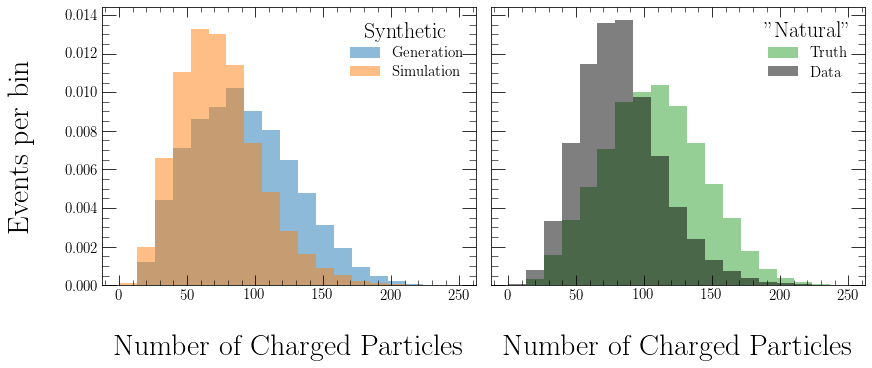

In [70]:
bins = np.linspace(0, 250, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Events per bin')
hG0, _, _ = ax[0].hist(nTracks_0_G,
                       bins=bins,
                       label='Generation',
                       **plot_style_2,
                       color='C0')
hS0, _, _ = ax[0].hist(nTracks_0_S,
                       bins=bins,
                       label='Simulation',
                       **plot_style_2,
                       color='C1')
legend = ax[0].legend(title='Synthetic', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1].hist(nTracks_unknown_G,
                       weights=weights_nTracks_stress,
                       bins=bins,
                       label='Truth',
                       **plot_style_2,
                       color='C2')
hS1, _, _ = ax[1].hist(nTracks_unknown_S,
                       weights=weights_nTracks_stress,
                       bins=bins,
                       label='Data',
                       **plot_style_2,
                       color='k')
legend = ax[1].legend(title='"Natural"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-UniFold-nTracks-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

### Unfold $m_{\mu^+\mu^-}$

In [71]:
# z-score standardization

scaler_G = preprocessing.StandardScaler()
scaler_S = preprocessing.StandardScaler()

scaler_G.fit(m_ll_0_G.reshape(-1,1))
scaler_S.fit(np.concatenate((m_ll_0_S, m_ll_unknown_S)).reshape(-1,1))

theta_0_G = np.squeeze(scaler_G.transform(m_ll_0_G.reshape(-1,1)))
theta_0_S = np.squeeze(scaler_S.transform(m_ll_0_S.reshape(-1,1)))
theta_unknown_S = np.squeeze(scaler_S.transform(m_ll_unknown_S.reshape(-1,1)))

In [72]:
weights, _ = unifold(iterations=10,
                     theta_0_G=theta_0_G,
                     theta_0_S=theta_0_S,
                     theta_unknown_S=theta_unknown_S,
                     weightsMC_unknown=weights_m_ll_stress)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6847 - acc: 0.5000 - val_loss: 0.6847 - val_acc: 0.4986
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6842 - acc: 0.4998 - val_loss: 0.6849 - val_acc: 0.4987
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6842 - acc: 0.5002 - val_loss: 0.6848 - val_acc: 0.4989
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6842 - acc: 0.5001 - val_loss: 0.6847 - val_acc: 0.4987
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6842 - acc: 0.5000 - val_loss: 0.6848 - val_acc: 0.4989
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6842 - acc: 0.5001 - val_loss: 0.6847 - val_acc: 0.4991
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6842 - a

466582/466582 [==============================] - 1s 2us/step - loss: 0.6899 - acc: 0.4998 - val_loss: 0.6898 - val_acc: 0.5013
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6900 - acc: 0.4995 - val_loss: 0.6897 - val_acc: 0.5013
Epoch 13/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6900 - acc: 0.4991 - val_loss: 0.6897 - val_acc: 0.5010
Epoch 14/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6899 - acc: 0.4993 - val_loss: 0.6898 - val_acc: 0.5013
Epoch 15/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6899 - acc: 0.4994 - val_loss: 0.6898 - val_acc: 0.5010
Epoch 16/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6899 - acc: 0.4999 - val_loss: 0.6898 - val_acc: 0.5009
Epoch 17/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6899 - acc: 0.4993 - val_loss: 0.6898 - val_acc: 0.5009
Epoch 18/200
466582/466582 [=====

466582/466582 [==============================] - 1s 2us/step - loss: 0.6946 - acc: 0.4989 - val_loss: 0.6963 - val_acc: 0.5016
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6946 - acc: 0.4992 - val_loss: 0.6963 - val_acc: 0.5010
Epoch 13/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6946 - acc: 0.4991 - val_loss: 0.6963 - val_acc: 0.5014
Restoring model weights from the end of the best epoch
Epoch 00013: early stopping

STEP 2

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6797 - acc: 0.4995 - val_loss: 0.6778 - val_acc: 0.5012
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6780 - acc: 0.4994 - val_loss: 0.6777 - val_acc: 0.5013
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6780 - acc: 0.4994 - val_loss: 0.6777 - val_acc: 0.5012
Epoch 4/200
466582/466582 [=====

466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.4994 - val_loss: 0.6925 - val_acc: 0.4998
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6926 - val_acc: 0.4999
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6925 - val_acc: 0.5000
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.4994 - val_loss: 0.6926 - val_acc: 0.5005
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6925 - val_acc: 0.4995
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.4992 - val_loss: 0.6926 - val_acc: 0.5003
Epoch 13/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6926 - val_acc: 0.4999
Epoch 14/200
466582/466582 [=======

466582/466582 [==============================] - 1s 2us/step - loss: 0.6730 - acc: 0.5000 - val_loss: 0.6727 - val_acc: 0.4995
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6730 - acc: 0.5002 - val_loss: 0.6727 - val_acc: 0.4994
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6731 - acc: 0.5003 - val_loss: 0.6727 - val_acc: 0.4995
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6731 - acc: 0.5002 - val_loss: 0.6727 - val_acc: 0.4995
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6731 - acc: 0.5002 - val_loss: 0.6727 - val_acc: 0.4996
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6730 - acc: 0.5002 - val_loss: 0.6728 - val_acc: 0.4996
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6730 - acc: 0.5000 - val_loss: 0.6728 - val_acc: 0.4993
Epoch 12/200
466582/466582 [=========

466582/466582 [==============================] - 1s 2us/step - loss: 0.6915 - acc: 0.4992 - val_loss: 0.6926 - val_acc: 0.5000
Epoch 22/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6915 - acc: 0.4996 - val_loss: 0.6926 - val_acc: 0.5000
Epoch 23/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6915 - acc: 0.5000 - val_loss: 0.6926 - val_acc: 0.5001
Epoch 24/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6916 - acc: 0.5007 - val_loss: 0.6927 - val_acc: 0.5001
Restoring model weights from the end of the best epoch
Epoch 00024: early stopping

STEP 2

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 4s 9us/step - loss: 0.6788 - acc: 0.4997 - val_loss: 0.6731 - val_acc: 0.5000
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6728 - acc: 0.5001 - val_loss: 0.6729 - val_acc: 0.5002
Epoch 3/200
466582/466582 [====

466582/466582 [==============================] - 1s 2us/step - loss: 0.6891 - acc: 0.4995 - val_loss: 0.6905 - val_acc: 0.4995
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6891 - acc: 0.5002 - val_loss: 0.6905 - val_acc: 0.5000
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6891 - acc: 0.4997 - val_loss: 0.6905 - val_acc: 0.4991
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6891 - acc: 0.4997 - val_loss: 0.6905 - val_acc: 0.5005
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6891 - acc: 0.4995 - val_loss: 0.6905 - val_acc: 0.4998
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6891 - acc: 0.5003 - val_loss: 0.6905 - val_acc: 0.4999
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6891 - acc: 0.4994 - val_loss: 0.6905 - val_acc: 0.4997
Epoch 9/200
466582/466582 [============

466582/466582 [==============================] - 1s 2us/step - loss: 0.6720 - acc: 0.4998 - val_loss: 0.6728 - val_acc: 0.5004
Epoch 13/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6720 - acc: 0.4998 - val_loss: 0.6728 - val_acc: 0.5007
Epoch 14/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6720 - acc: 0.4997 - val_loss: 0.6728 - val_acc: 0.5007
Epoch 15/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6720 - acc: 0.4999 - val_loss: 0.6728 - val_acc: 0.5005
Restoring model weights from the end of the best epoch
Epoch 00015: early stopping


#### Results 

ITERATION 1:


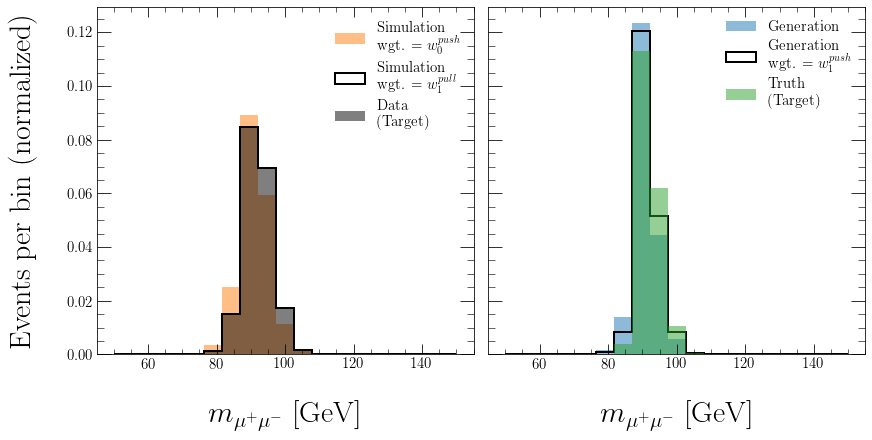

ITERATION 2:


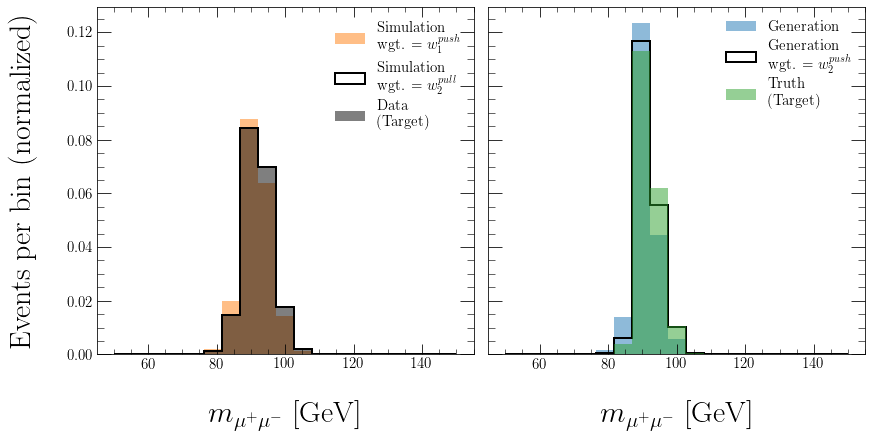

ITERATION 3:


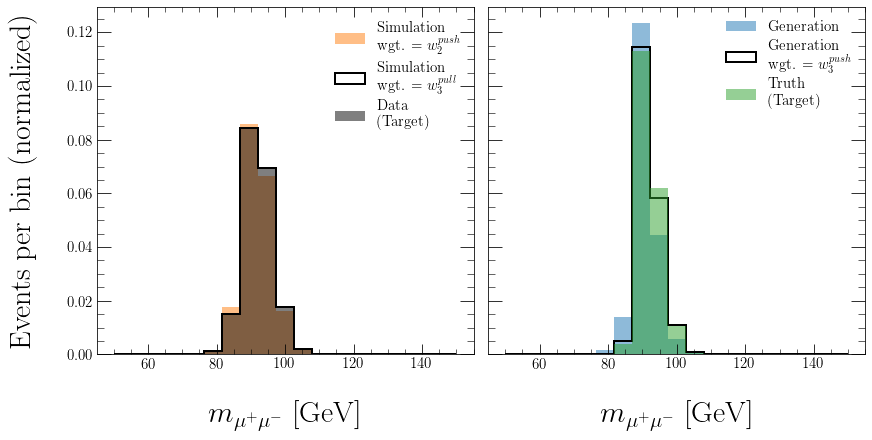

ITERATION 4:


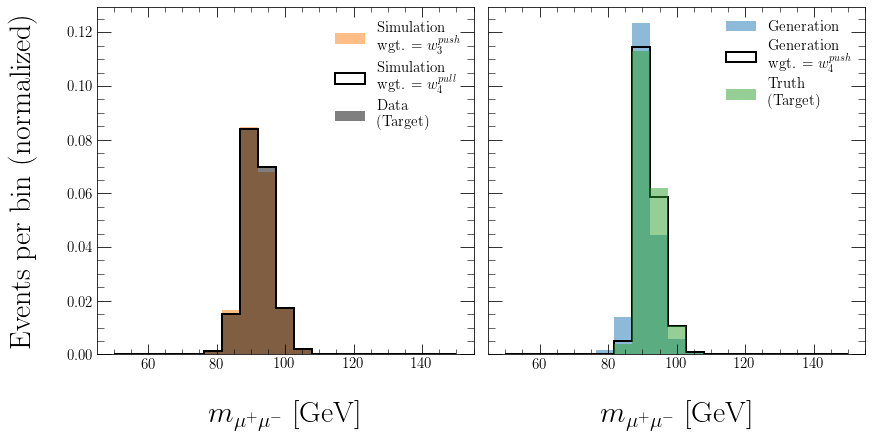

ITERATION 5:


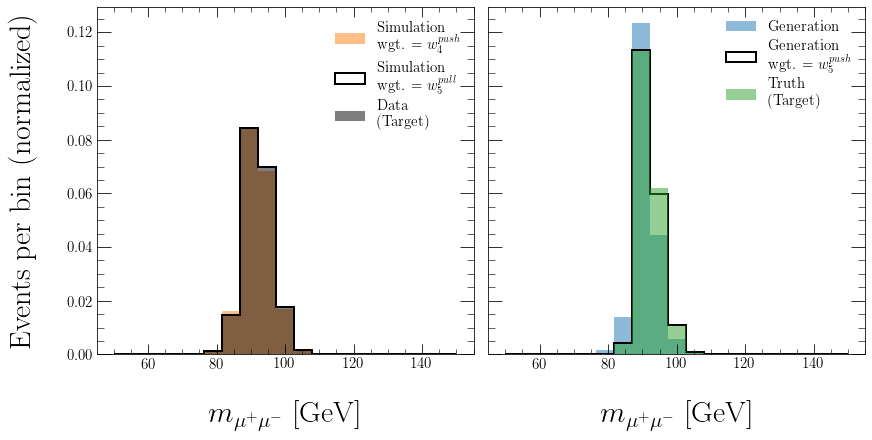

ITERATION 6:


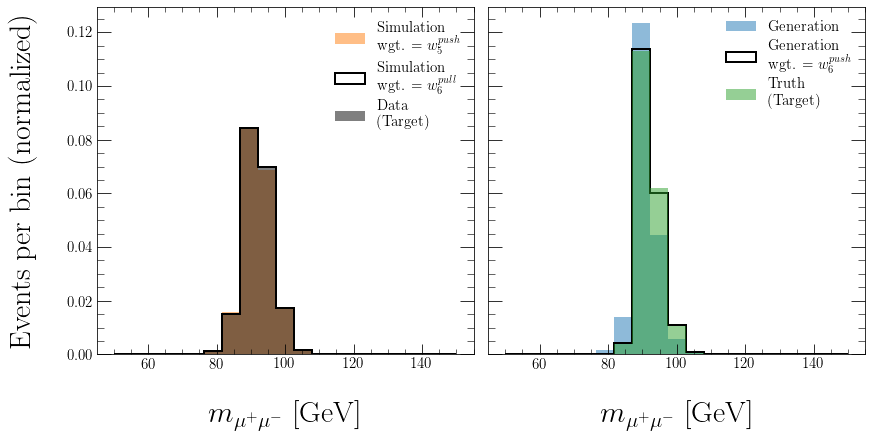

ITERATION 7:


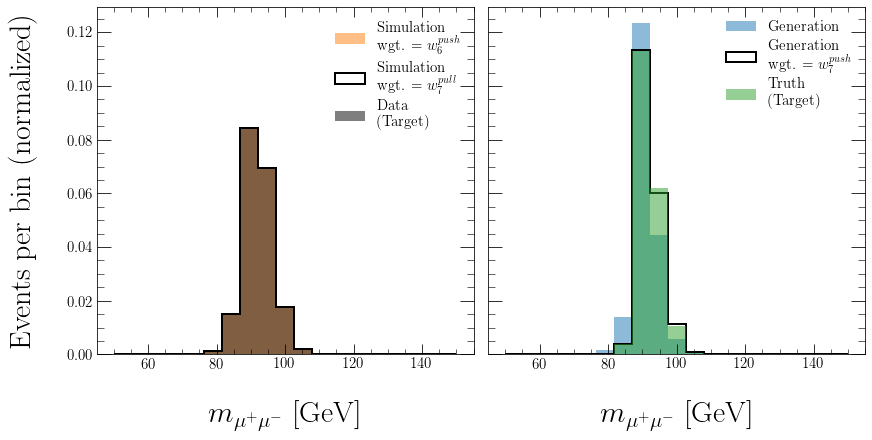

ITERATION 8:


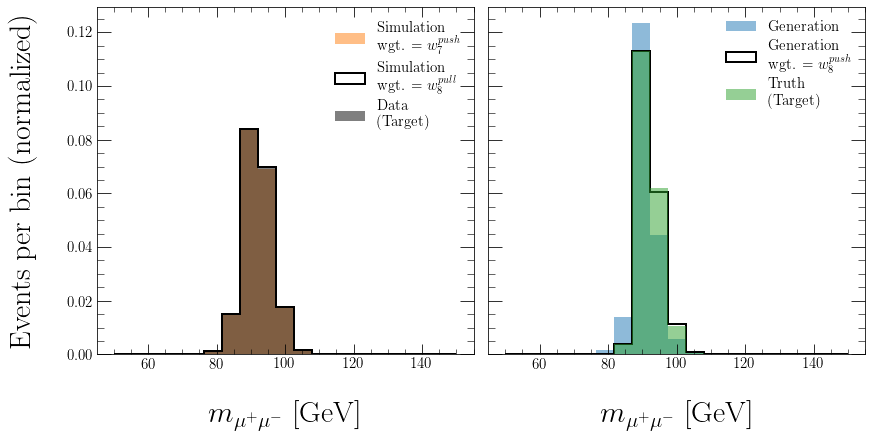

ITERATION 9:


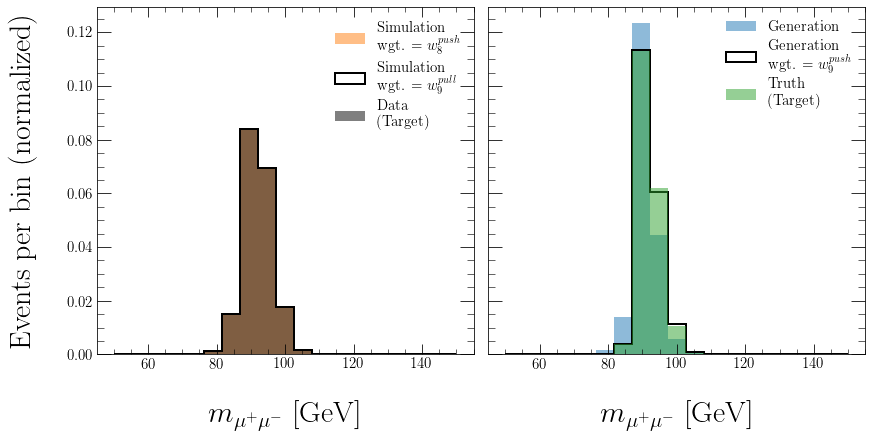

ITERATION 10:


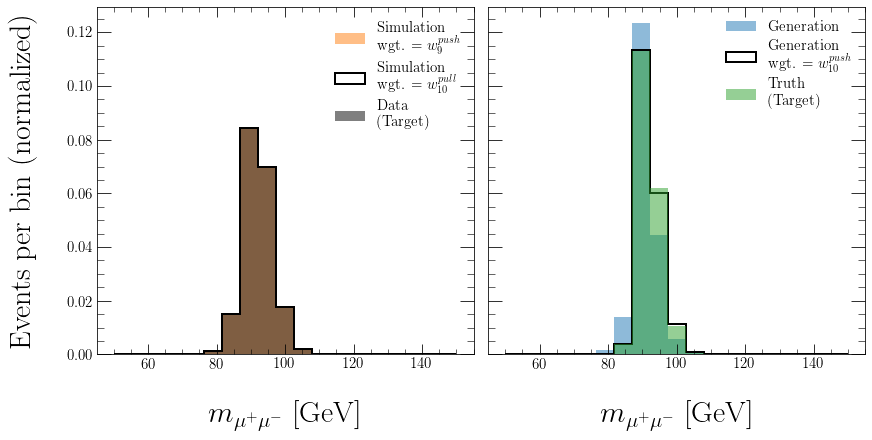

In [73]:
bins = np.linspace(50, 150, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = np.ones(len(m_ll_0_S))
    else:
        weights_init = weights[i - 1, 1, :]

    ax[0].hist(m_ll_0_S,
               weights=weights_init,
               bins=bins,
               label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) +
                                                                 '}'),
               **plot_style_2,
               color='C1')

    ax[0].hist(
        m_ll_0_S,
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        weights=weights[i, 0, :],
        **plot_style_1)
    ax[0].hist(m_ll_unknown_S,
               weights=weights_m_ll_stress,
               bins=bins,
               label='Data\n(Target)',
               **plot_style_2,
               color='k')
    ax[0].set_xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend()
    ax[1].hist(m_ll_0_G, bins=bins, label=r'Generation', **plot_style_2)

    ax[1].hist(
        m_ll_0_G,
        bins=bins,
        label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
        weights=weights[i, 1, :],
        **plot_style_1)
    ax[1].hist(m_ll_unknown_G,
               weights=weights_m_ll_stress,
               bins=bins,
               label='Truth\n(Target)',
               **plot_style_2,
               color='C2')
    ax[1].legend()
    ax[1].set_xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")

    fig.show()
#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-UniFold-m_ll-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    plt.show()

### Unfold Number of Charged Particles

In [74]:
# z-score standardization

scaler_G = preprocessing.StandardScaler()
scaler_S = preprocessing.StandardScaler()

scaler_G.fit(nTracks_0_G.reshape(-1,1))
scaler_S.fit(np.concatenate((nTracks_0_S, nTracks_unknown_S)).reshape(-1,1))

theta_0_G = np.squeeze(scaler_G.transform(nTracks_0_G.reshape(-1,1)))
theta_0_S = np.squeeze(scaler_S.transform(nTracks_0_S.reshape(-1,1)))
theta_unknown_S = np.squeeze(scaler_S.transform(nTracks_unknown_S.reshape(-1,1)))

In [75]:
weights, _ = unifold(iterations=10,
                     theta_0_G=theta_0_G,
                     theta_0_S=theta_0_S,
                     theta_unknown_S=theta_unknown_S,
                     weightsMC_unknown=weights_nTracks_stress)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 4s 10us/step - loss: 0.6827 - acc: 0.5003 - val_loss: 0.6801 - val_acc: 0.5010
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6799 - acc: 0.5003 - val_loss: 0.6801 - val_acc: 0.5007
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6799 - acc: 0.5004 - val_loss: 0.6801 - val_acc: 0.5007
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6799 - acc: 0.5002 - val_loss: 0.6802 - val_acc: 0.5008
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6799 - acc: 0.5002 - val_loss: 0.6801 - val_acc: 0.5008
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6799 - acc: 0.5003 - val_loss: 0.6801 - val_acc: 0.5007
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6799 - 

Epoch 19/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6958 - acc: 0.5004 - val_loss: 0.6947 - val_acc: 0.5013
Epoch 20/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6958 - acc: 0.5004 - val_loss: 0.6947 - val_acc: 0.5013
Epoch 21/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6957 - acc: 0.5004 - val_loss: 0.6947 - val_acc: 0.5013
Epoch 22/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6957 - acc: 0.5005 - val_loss: 0.6947 - val_acc: 0.5013
Restoring model weights from the end of the best epoch
Epoch 00022: early stopping

STEP 2

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6823 - acc: 0.4999 - val_loss: 0.6819 - val_acc: 0.5006
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6818 - acc: 0.4999 - val_loss: 0.6819 - val_acc: 0.5003
Epoch 3/200
46658

466582/466582 [==============================] - 1s 2us/step - loss: 0.6926 - acc: 0.5010 - val_loss: 0.6914 - val_acc: 0.4991
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6926 - acc: 0.5011 - val_loss: 0.6914 - val_acc: 0.4989
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6926 - acc: 0.5009 - val_loss: 0.6914 - val_acc: 0.4998
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6926 - acc: 0.5010 - val_loss: 0.6914 - val_acc: 0.4991
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6926 - acc: 0.5010 - val_loss: 0.6914 - val_acc: 0.4991
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6926 - acc: 0.5008 - val_loss: 0.6914 - val_acc: 0.4993
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6926 - acc: 0.5008 - val_loss: 0.6914 - val_acc: 0.4991
Epoch 13/200
466582/466582 [========

466582/466582 [==============================] - 1s 2us/step - loss: 0.6668 - acc: 0.5007 - val_loss: 0.6672 - val_acc: 0.4981
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6668 - acc: 0.5006 - val_loss: 0.6672 - val_acc: 0.4980
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6668 - acc: 0.5007 - val_loss: 0.6672 - val_acc: 0.4980
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6668 - acc: 0.5006 - val_loss: 0.6673 - val_acc: 0.4980
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6668 - acc: 0.5007 - val_loss: 0.6674 - val_acc: 0.4981
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6668 - acc: 0.5007 - val_loss: 0.6673 - val_acc: 0.4980
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6668 - acc: 0.5007 - val_loss: 0.6673 - val_acc: 0.4980
Epoch 10/200
466582/466582 [===========

466582/466582 [==============================] - 1s 2us/step - loss: 0.6868 - acc: 0.5001 - val_loss: 0.6882 - val_acc: 0.4989
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6868 - acc: 0.5004 - val_loss: 0.6882 - val_acc: 0.4998
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6868 - acc: 0.5001 - val_loss: 0.6881 - val_acc: 0.4995
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6868 - acc: 0.5003 - val_loss: 0.6882 - val_acc: 0.4993
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6868 - acc: 0.4998 - val_loss: 0.6882 - val_acc: 0.5000
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6868 - acc: 0.4998 - val_loss: 0.6882 - val_acc: 0.5000
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6868 - acc: 0.5002 - val_loss: 0.6882 - val_acc: 0.4993
Epoch 12/200
466582/466582 [=========

466582/466582 [==============================] - 1s 2us/step - loss: 0.6688 - acc: 0.5000 - val_loss: 0.6684 - val_acc: 0.5004
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6688 - acc: 0.4999 - val_loss: 0.6685 - val_acc: 0.5005
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6688 - acc: 0.4999 - val_loss: 0.6685 - val_acc: 0.5005
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6688 - acc: 0.4996 - val_loss: 0.6684 - val_acc: 0.5005
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6688 - acc: 0.4998 - val_loss: 0.6685 - val_acc: 0.5005
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6688 - acc: 0.4999 - val_loss: 0.6685 - val_acc: 0.5005
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6688 - acc: 0.4998 - val_loss: 0.6684 - val_acc: 0.5005
Epoch 9/200
466582/466582 [============

466582/466582 [==============================] - 6s 12us/step - loss: 0.6979 - acc: 0.5003 - val_loss: 0.6944 - val_acc: 0.4996
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6928 - acc: 0.4994 - val_loss: 0.6944 - val_acc: 0.5016
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6928 - acc: 0.5000 - val_loss: 0.6944 - val_acc: 0.5009
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6928 - acc: 0.5000 - val_loss: 0.6944 - val_acc: 0.4993
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6928 - acc: 0.5002 - val_loss: 0.6944 - val_acc: 0.5003
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6928 - acc: 0.4991 - val_loss: 0.6944 - val_acc: 0.4998
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6928 - acc: 0.5012 - val_loss: 0.6944 - val_acc: 0.4999
Epoch 8/200
466582/466582 [===========

#### Results

ITERATION 1:


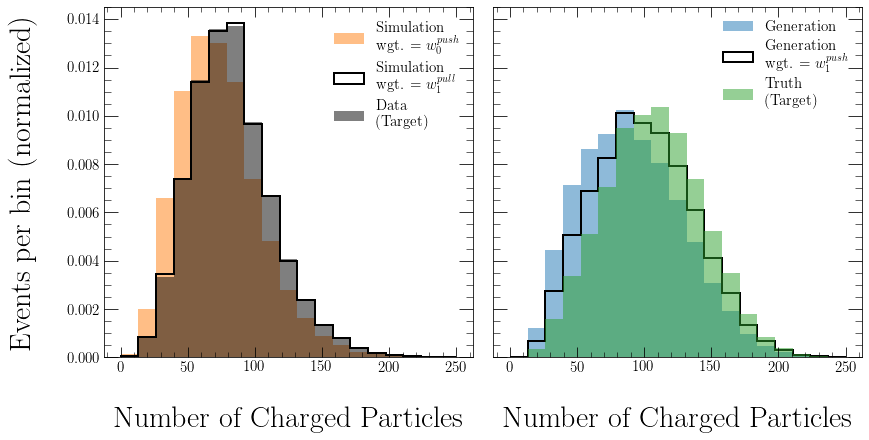

ITERATION 2:


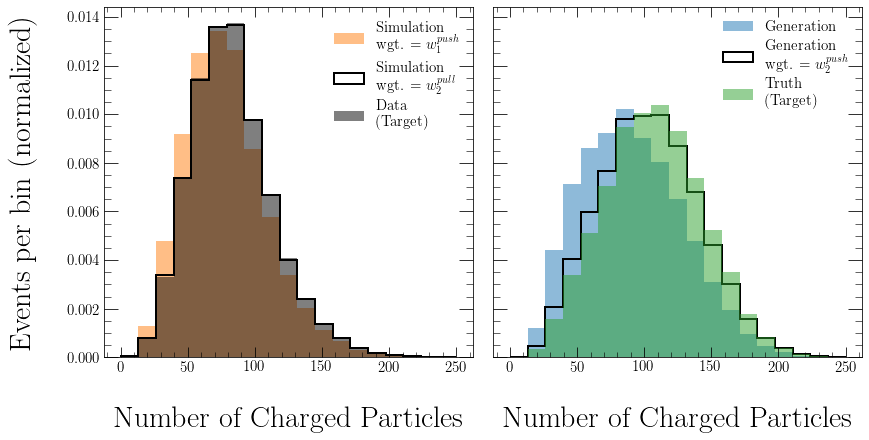

ITERATION 3:


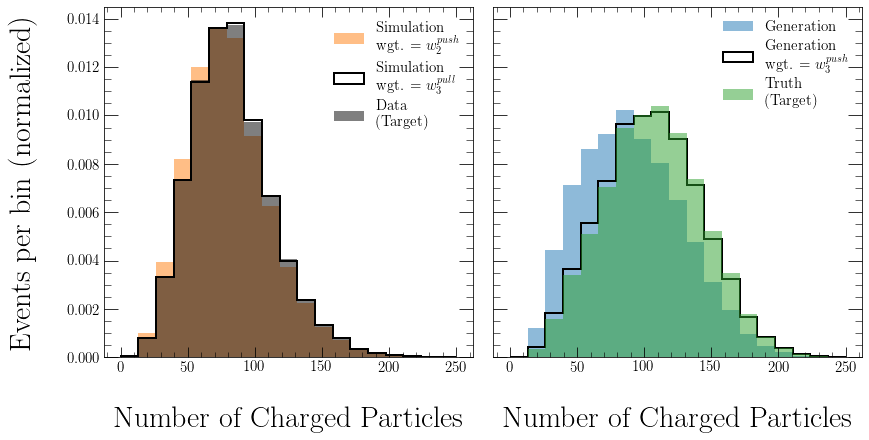

ITERATION 4:


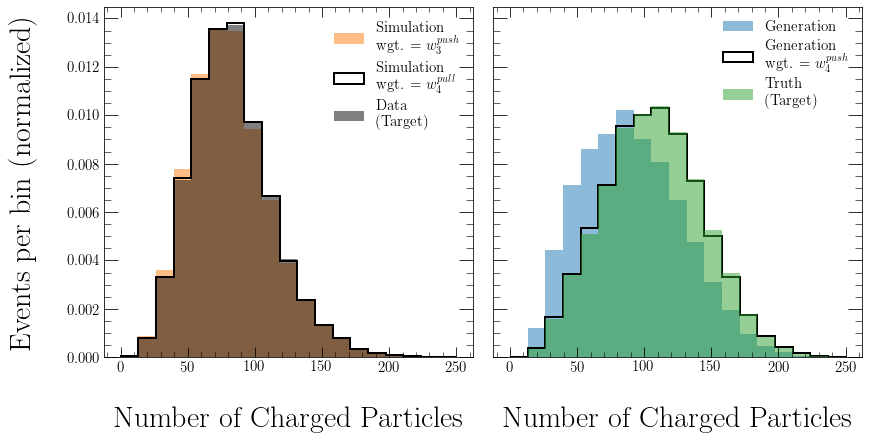

ITERATION 5:


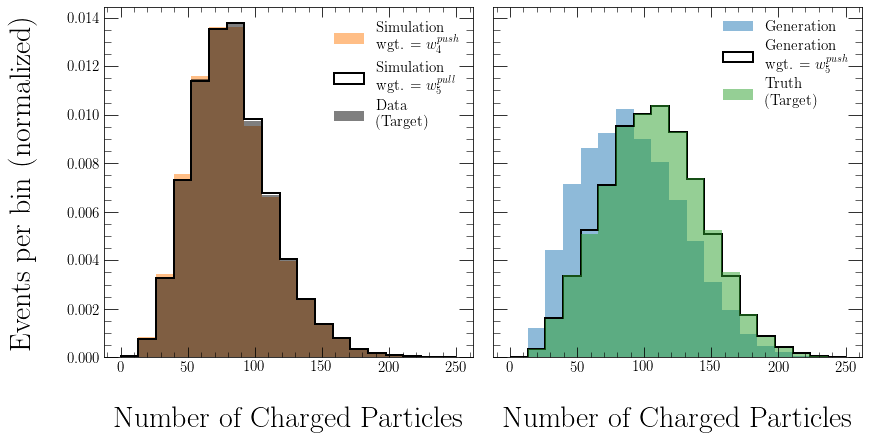

ITERATION 6:


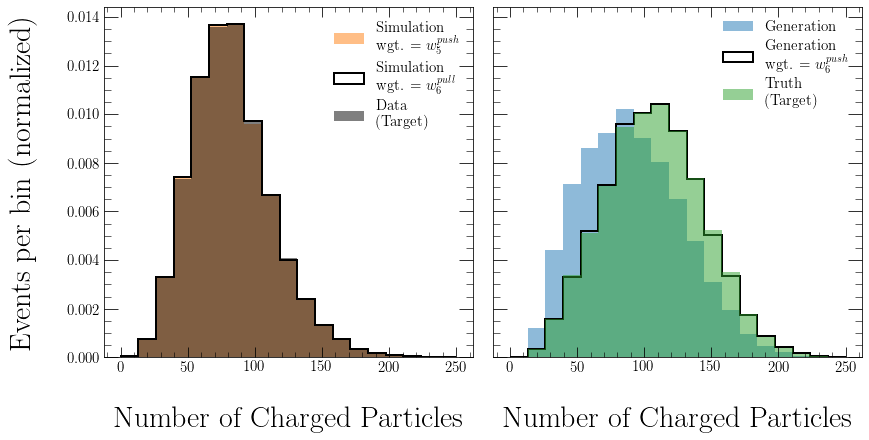

ITERATION 7:


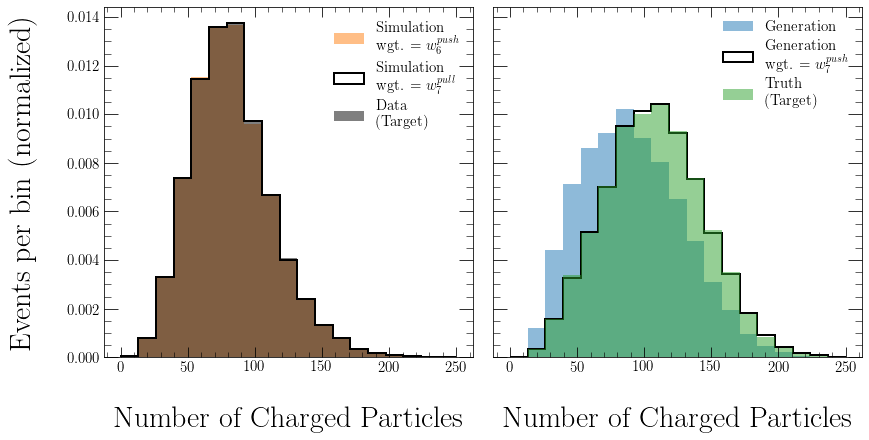

ITERATION 8:


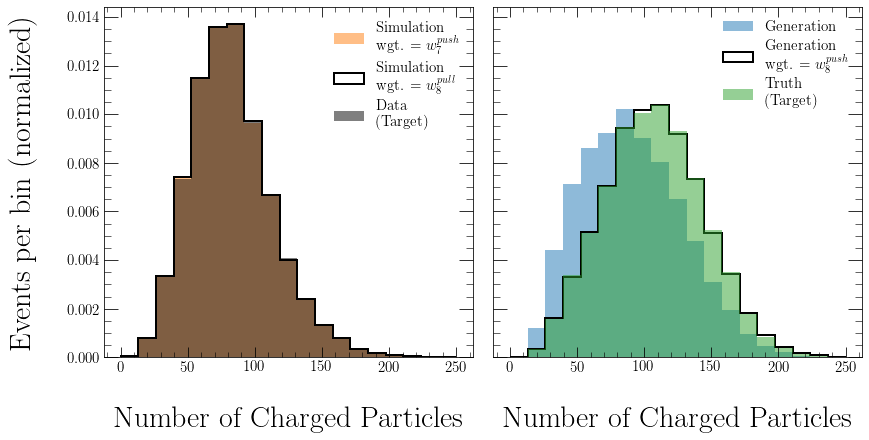

ITERATION 9:


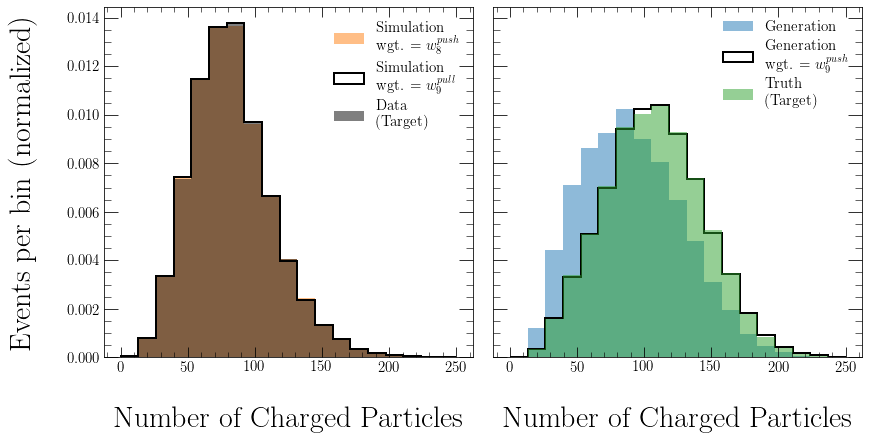

ITERATION 10:


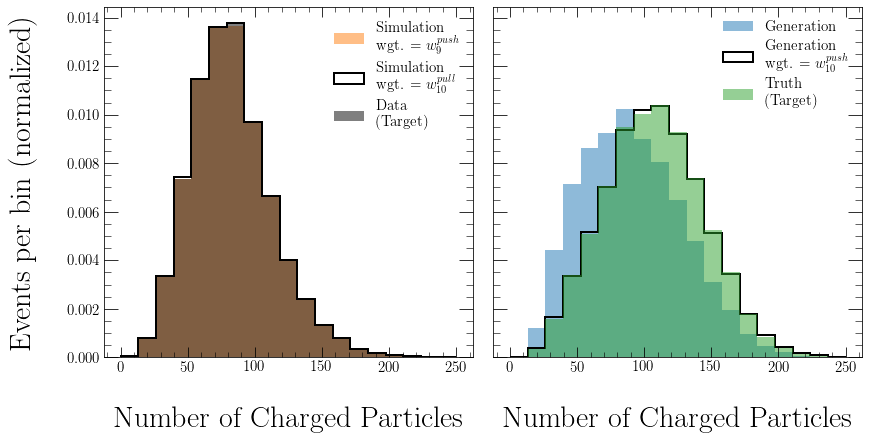

In [76]:
bins = np.linspace(0, 250, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = np.ones(len(nTracks_0_S))
    else:
        weights_init = weights[i - 1, 1, :]

    ax[0].hist(nTracks_0_S,
               weights=weights_init,
               bins=bins,
               label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) +
                                                                 '}'),
               **plot_style_2,
               color='C1')

    ax[0].hist(
        nTracks_0_S,
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        weights=weights[i, 0, :],
        **plot_style_1)
    ax[0].hist(nTracks_unknown_S,
               weights=weights_nTracks_stress,
               bins=bins,
               label='Data\n(Target)',
               **plot_style_2,
               color='k')
    ax[0].set_xlabel(r"Number of Charged Particles")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend()
    ax[1].hist(nTracks_0_G, bins=bins, label=r'Generation', **plot_style_2)

    ax[1].hist(
        nTracks_0_G,
        bins=bins,
        label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
        weights=weights[i, 1, :],
        **plot_style_1)
    ax[1].hist(nTracks_unknown_G,
               weights=weights_nTracks_stress,
               bins=bins,
               label='Truth\n(Target)',
               **plot_style_2,
               color='C2')
    ax[1].legend()
    ax[1].set_xlabel(r"Number of Charged Particles")

    fig.show()
#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-UniFold-nTracks-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    plt.show()

## Multifold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles simultaneously.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the synthetic dataset, and the other half as the unknown "natural" dataset.

In [77]:
K.clear_session()

### Setup datasets

In [78]:
m_ll_0_G, m_ll_unknown_G, m_ll_0_S, m_ll_unknown_S, nTracks_0_G, nTracks_unknown_G, nTracks_0_S, nTracks_unknown_S = train_test_split(
    Events_0.events['truth_m_ll'][mypass_0],
    Events_0.events['m_ll'][mypass_0],
    np.array(ntrack_0_Gen),
    np.array(ntrack_0_Sim),
    test_size=0.5)

In [79]:
scaler_m_ll = preprocessing.StandardScaler()
scaler_m_ll.fit(np.concatenate((m_ll_0_G, m_ll_unknown_G)).reshape(-1,1))

scaler_nTracks = preprocessing.StandardScaler()
scaler_nTracks.fit(np.concatenate((nTracks_0_G, nTracks_unknown_G)).reshape(-1,1))

weight_m_ll_seed = np.squeeze(scaler_m_ll.transform(m_ll_unknown_G.reshape(-1,1)))
weight_nTracks_seed = np.squeeze(scaler_nTracks.transform(nTracks_unknown_G.reshape(-1,1)))

weight_seed = weight_m_ll_seed + weight_nTracks_seed

In [80]:
weights_stress = [
    abs(np.random.normal(0, sigmoid(std))) for std in weight_seed
]
weights_stress = np.array(weights_stress)
weights_stress = weights_stress / np.mean(weights_stress)

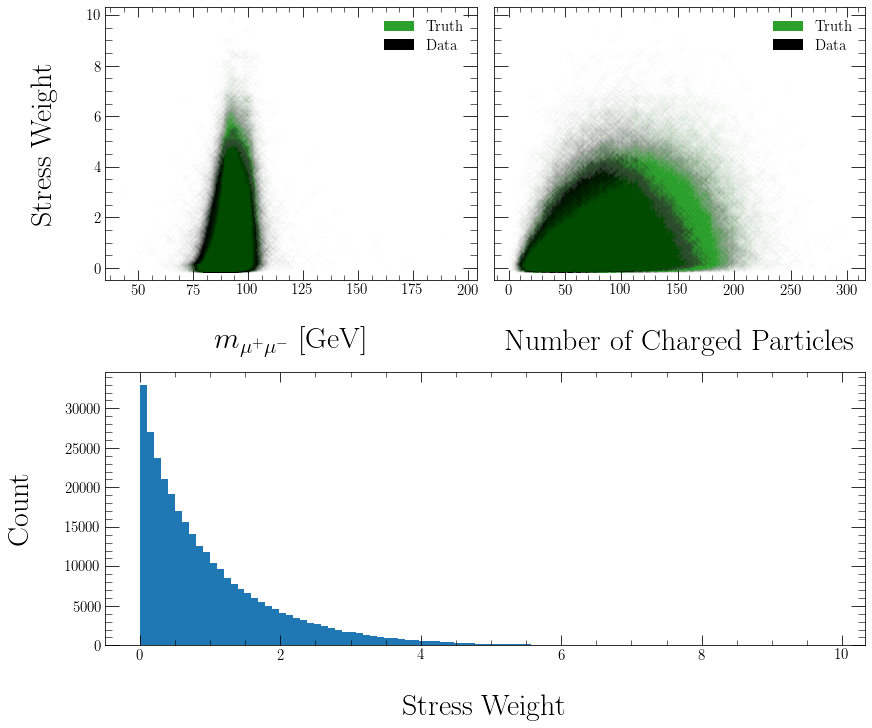

In [81]:
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(m_ll_unknown_S,
         weights_stress,
         'x',
         alpha=0.01,
         color='k',
         label='Data')
ax0.plot(m_ll_unknown_G,
         weights_stress,
         'x',
         alpha=0.01,
         color='C2',
         label='Truth')
ax0.set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax0.set_ylabel('Stress Weight')

ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
plt.setp(ax1.get_yticklabels(), visible=False)
ax1.plot(nTracks_unknown_S,
         weights_stress,
         'x',
         alpha=0.01,
         color='k',
         label='Data')
ax1.plot(nTracks_unknown_G,
         weights_stress,
         'x',
         alpha=0.01,
         color='C2',
         label='Truth')
ax1.set_xlabel('Number of Charged Particles')

handles = [Patch(facecolor='C2'), Patch(facecolor='k')]
labels = ['Truth', 'Data']
ax0.legend(handles, labels)
ax1.legend(handles, labels)

ax2 = fig.add_subplot(gs[1, :])
ax2.hist(weights_stress,
         bins=np.linspace(np.min(weights_stress), np.max(weights_stress), 100))
ax2.set_xlabel('Stress Weight')
ax2.set_ylabel('Count')

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-MultiFold-StressWeights.png',
#     bbox_inches='tight')

fig.show()

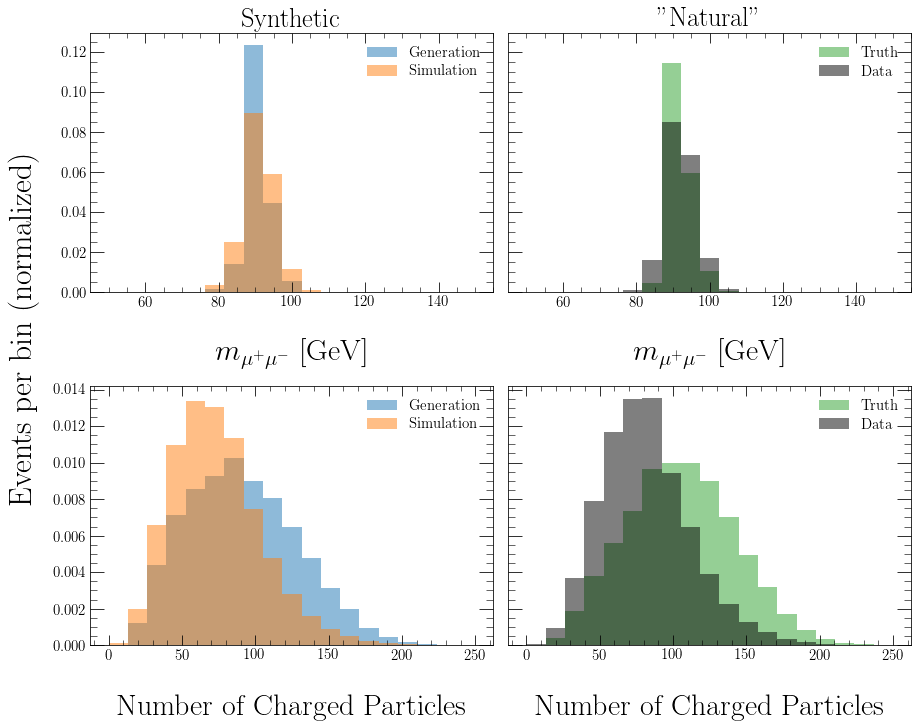

In [82]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 10),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(50, 150, 20)

ax[0, 0].set_title('Synthetic')
ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG0, _, _ = ax[0, 0].hist(m_ll_0_G,
                          bins=bins,
                          label='Generation',
                          **plot_style_2, color='C0')
hS0, _, _ = ax[0, 0].hist(m_ll_0_S,
                          bins=bins,
                          label='Simulation',
                          **plot_style_2, color='C1')
legend = ax[0, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Natural"')
ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[0, 1].hist(m_ll_unknown_G,
                          weights=weights_stress,
                          bins=bins,
                          label='Truth',
                          **plot_style_2, color='C2')
hS1, _, _ = ax[0, 1].hist(m_ll_unknown_S,
                          weights=weights_stress,
                          bins=bins,
                          label='Data',
                          **plot_style_2, color='k')
legend = ax[0, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

bins = np.linspace(0, 250, 20)

ax[1, 0].set_xlabel('Number of Charged Particles')
hG0, _, _ = ax[1, 0].hist(nTracks_0_G,
                          bins=bins,
                          label='Generation',
                          **plot_style_2, color='C0')
hS0, _, _ = ax[1, 0].hist(nTracks_0_S,
                          bins=bins,
                          label='Simulation',
                          **plot_style_2, color='C1')
legend = ax[1, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1, 1].hist(nTracks_unknown_G,
                          weights=weights_stress,
                          bins=bins,
                          label='Truth',
                          **plot_style_2, color='C2')
hS1, _, _ = ax[1, 1].hist(nTracks_unknown_S,
                          weights=weights_stress,
                          bins=bins,
                          label='Data',
                          **plot_style_2, color='k')
legend = ax[1, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.text(-0.05, 0.55,'Events per bin (normalized)', va='center', rotation='vertical', fontsize='x-large')
# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-MultiFold-Distributions.pdf', 
#     bbox_inches='tight')
fig.show()

### Unfold $m_{\mu^+\mu^-}$ and Number of Charged Particles Simultaneously

In [83]:
# z-score standardization

num_observables = 2

scaler_m_ll_G = preprocessing.StandardScaler()
scaler_m_ll_S = preprocessing.StandardScaler()

scaler_m_ll_G.fit(m_ll_0_G.reshape(-1,1))
scaler_m_ll_S.fit(np.concatenate((m_ll_0_S, m_ll_unknown_S)).reshape(-1,1))

scaler_nTracks_G = preprocessing.StandardScaler()
scaler_nTracks_S = preprocessing.StandardScaler()

scaler_nTracks_G.fit(nTracks_0_G.reshape(-1,1))
scaler_nTracks_S.fit(np.concatenate((nTracks_0_S, nTracks_unknown_S)).reshape(-1,1))

theta_0_G = (np.squeeze(scaler_m_ll_G.transform(m_ll_0_G.reshape(-1,1))),
             np.squeeze(scaler_nTracks_G.transform(nTracks_0_G.reshape(-1,1))))

theta_0_S = (np.squeeze(scaler_m_ll_S.transform(m_ll_0_S.reshape(-1,1))),
             np.squeeze(scaler_nTracks_S.transform(nTracks_0_S.reshape(-1,1))))

theta_unknown_S = (np.squeeze(scaler_m_ll_S.transform(m_ll_unknown_S.reshape(-1,1))),
                   np.squeeze(scaler_nTracks_S.transform(nTracks_unknown_S.reshape(-1,1))))

In [84]:
weights, _ = multifold(num_observables=num_observables,
                       iterations=10,
                       theta_0_G=theta_0_G,
                       theta_0_S=theta_0_S,
                       theta_unknown_S=theta_unknown_S,
                       weightsMC_unknown=weights_stress)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 2s 4us/step - loss: 0.6800 - acc: 0.5022 - val_loss: 0.6753 - val_acc: 0.5012
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6749 - acc: 0.5006 - val_loss: 0.6750 - val_acc: 0.5019
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6748 - acc: 0.5007 - val_loss: 0.6749 - val_acc: 0.5015
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6747 - acc: 0.5007 - val_loss: 0.6750 - val_acc: 0.5016
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6747 - acc: 0.5008 - val_loss: 0.6749 - val_acc: 0.5019
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6746 - acc: 0.5007 - val_loss: 0.6748 - val_acc: 0.5017
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6746 - a

466582/466582 [==============================] - 1s 2us/step - loss: 0.6851 - acc: 0.5005 - val_loss: 0.6850 - val_acc: 0.4979
Epoch 21/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6851 - acc: 0.5008 - val_loss: 0.6850 - val_acc: 0.4984
Epoch 22/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6851 - acc: 0.5005 - val_loss: 0.6850 - val_acc: 0.4980
Restoring model weights from the end of the best epoch
Epoch 00022: early stopping

ITERATION: 2

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6883 - acc: 0.5012 - val_loss: 0.6886 - val_acc: 0.5021
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6882 - acc: 0.5014 - val_loss: 0.6886 - val_acc: 0.5024
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6882 - acc: 0.5015 - val_loss: 0.6887 - val_acc: 0.5020
Epoch 4/200
466582

466582/466582 [==============================] - 1s 2us/step - loss: 0.6662 - acc: 0.4997 - val_loss: 0.6662 - val_acc: 0.5011
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6662 - acc: 0.4996 - val_loss: 0.6661 - val_acc: 0.5011
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6662 - acc: 0.4997 - val_loss: 0.6661 - val_acc: 0.5012
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6662 - acc: 0.4996 - val_loss: 0.6662 - val_acc: 0.5010
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6662 - acc: 0.4999 - val_loss: 0.6661 - val_acc: 0.5009
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6662 - acc: 0.4995 - val_loss: 0.6661 - val_acc: 0.5011
Restoring model weights from the end of the best epoch
Epoch 00012: early stopping

ITERATION: 4

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
46658

466582/466582 [==============================] - 1s 2us/step - loss: 0.6953 - acc: 0.5019 - val_loss: 0.6958 - val_acc: 0.5017
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6953 - acc: 0.5020 - val_loss: 0.6959 - val_acc: 0.5009
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6953 - acc: 0.5024 - val_loss: 0.6959 - val_acc: 0.5024
Epoch 13/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6953 - acc: 0.5017 - val_loss: 0.6958 - val_acc: 0.5030
Epoch 14/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6953 - acc: 0.5024 - val_loss: 0.6959 - val_acc: 0.5023
Epoch 15/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6953 - acc: 0.5022 - val_loss: 0.6959 - val_acc: 0.5025
Epoch 16/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6953 - acc: 0.5024 - val_loss: 0.6959 - val_acc: 0.5021
Epoch 17/200
466582/466582 [=====

466582/466582 [==============================] - 1s 2us/step - loss: 0.6968 - acc: 0.5022 - val_loss: 0.6957 - val_acc: 0.5015
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6968 - acc: 0.5021 - val_loss: 0.6957 - val_acc: 0.5017
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6968 - acc: 0.5024 - val_loss: 0.6957 - val_acc: 0.5031
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6968 - acc: 0.5027 - val_loss: 0.6957 - val_acc: 0.5021
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6968 - acc: 0.5027 - val_loss: 0.6957 - val_acc: 0.5012
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6968 - acc: 0.5019 - val_loss: 0.6957 - val_acc: 0.5028
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6968 - acc: 0.5032 - val_loss: 0.6956 - val_acc: 0.5021
Epoch 11/200
466582/466582 [==========

466582/466582 [==============================] - 1s 2us/step - loss: 0.7005 - acc: 0.5012 - val_loss: 0.7017 - val_acc: 0.5016
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.7005 - acc: 0.5016 - val_loss: 0.7017 - val_acc: 0.5006
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.7005 - acc: 0.5019 - val_loss: 0.7017 - val_acc: 0.5021
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.7005 - acc: 0.5009 - val_loss: 0.7017 - val_acc: 0.5017
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.7005 - acc: 0.5014 - val_loss: 0.7018 - val_acc: 0.5009
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.7005 - acc: 0.5012 - val_loss: 0.7017 - val_acc: 0.5006
Epoch 13/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.7005 - acc: 0.5021 - val_loss: 0.7018 - val_acc: 0.5013
Epoch 14/200
466582/466582 [=======

#### Results

ITERATION: 1


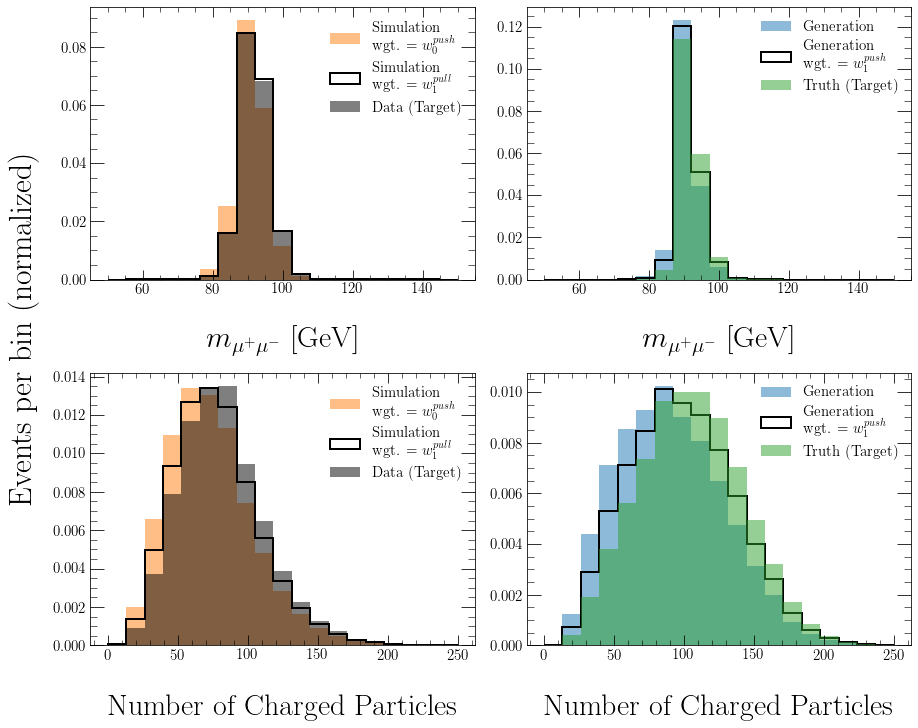

ITERATION: 2


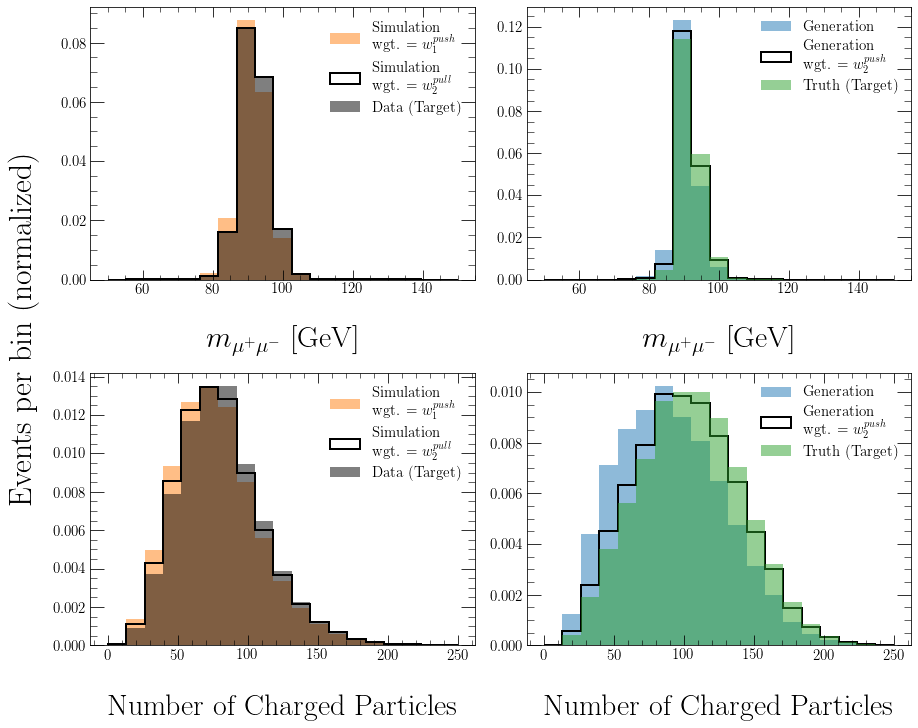

ITERATION: 3


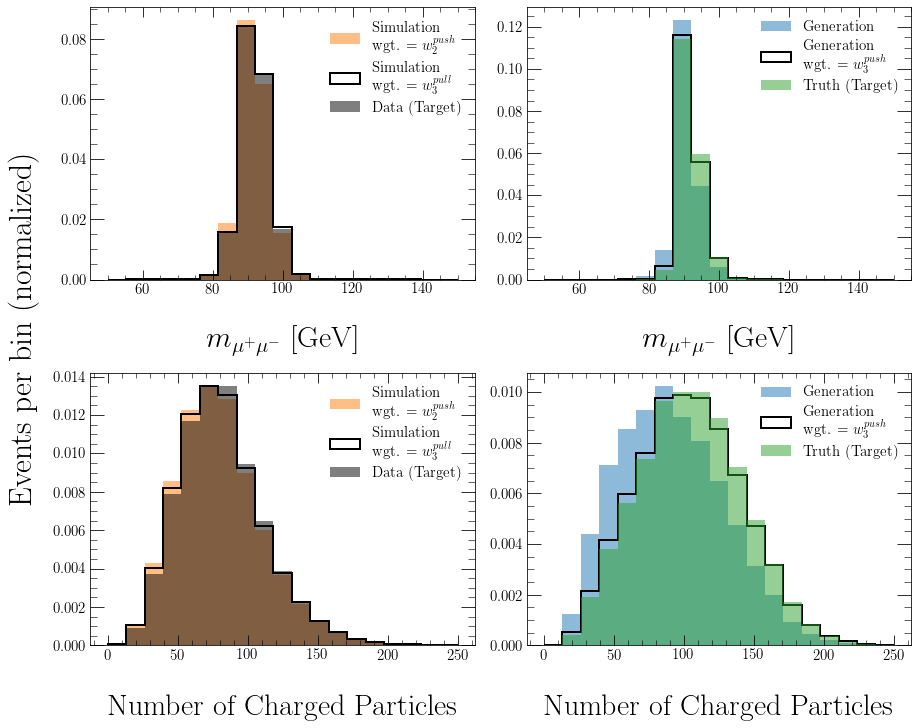

ITERATION: 4


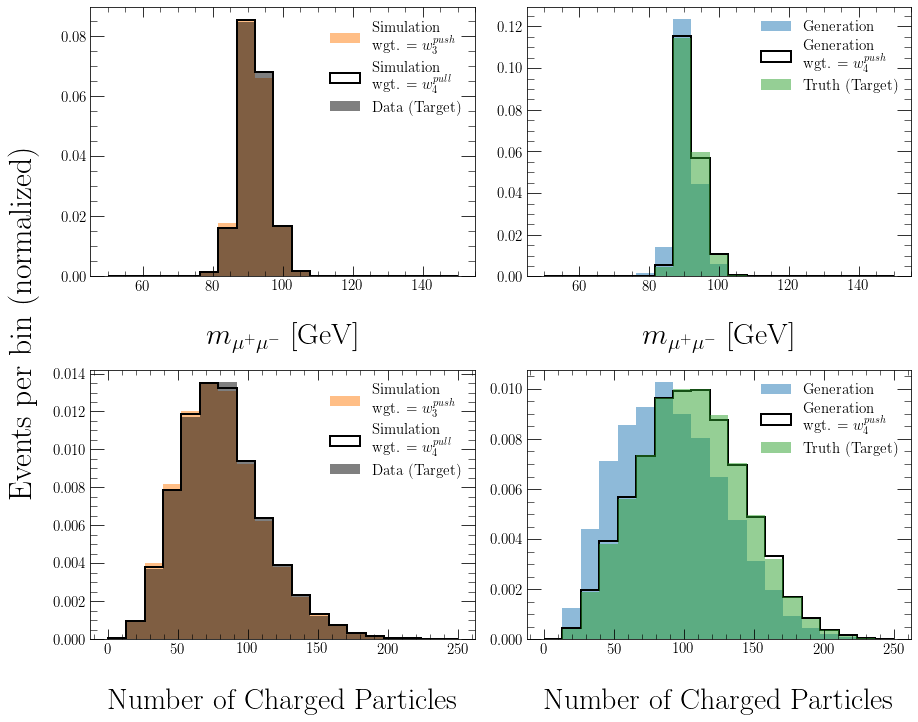

ITERATION: 5


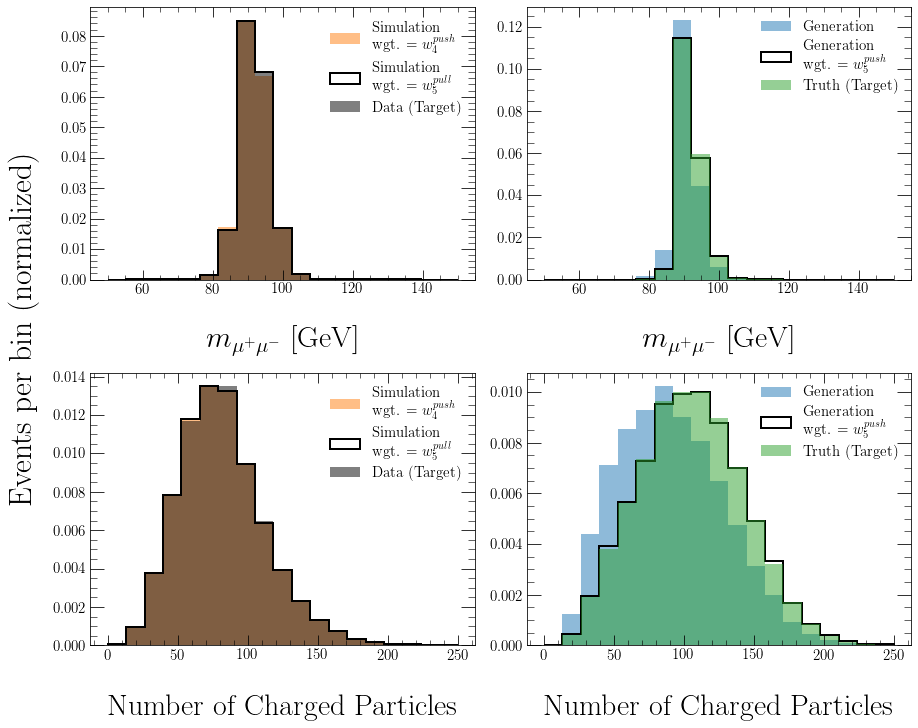

ITERATION: 6


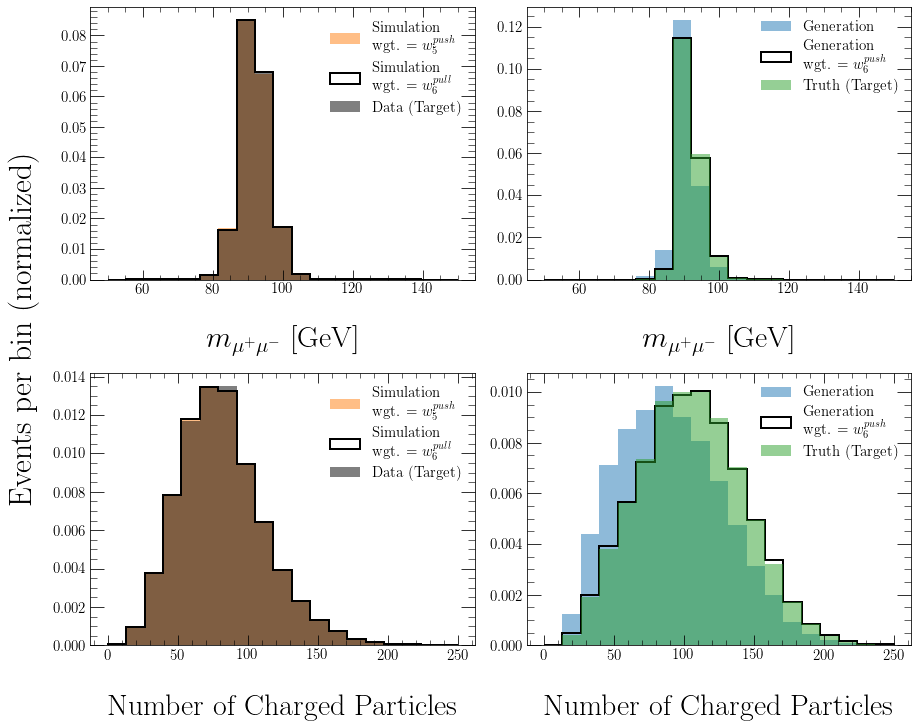

ITERATION: 7


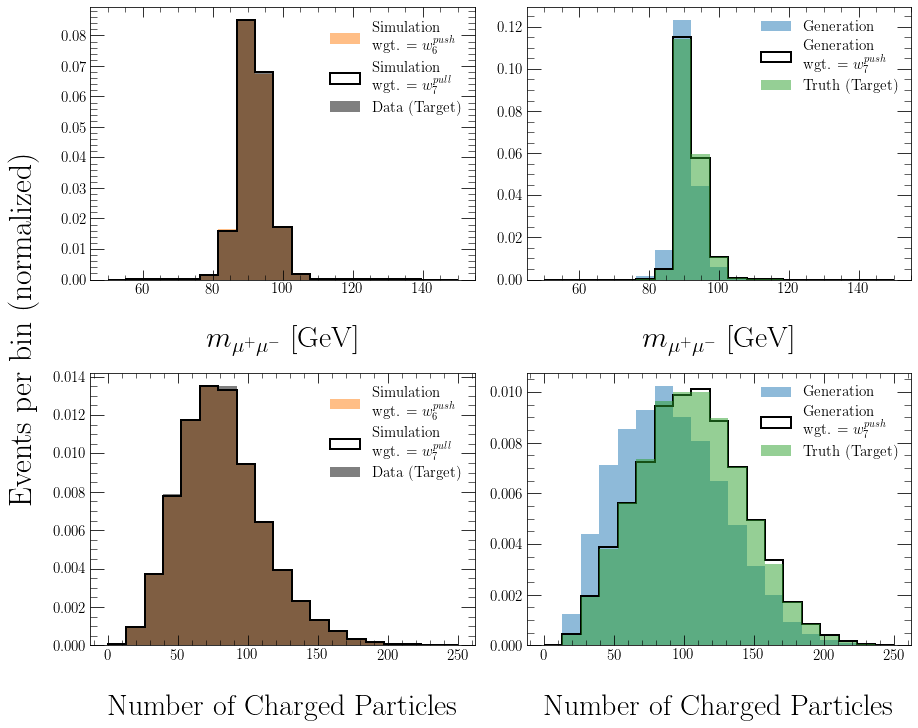

ITERATION: 8


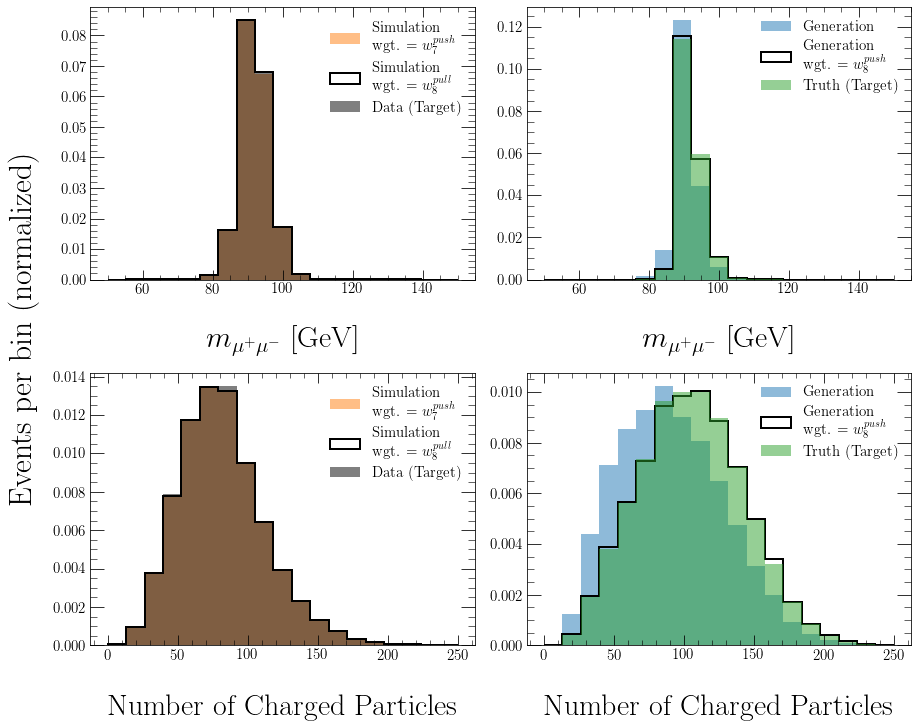

ITERATION: 9


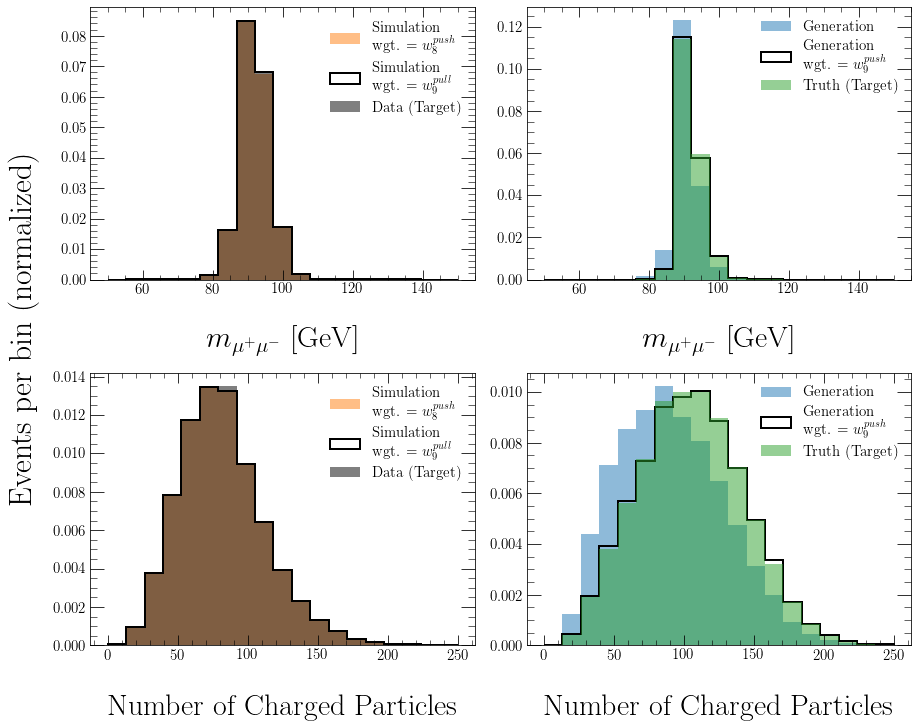

ITERATION: 10


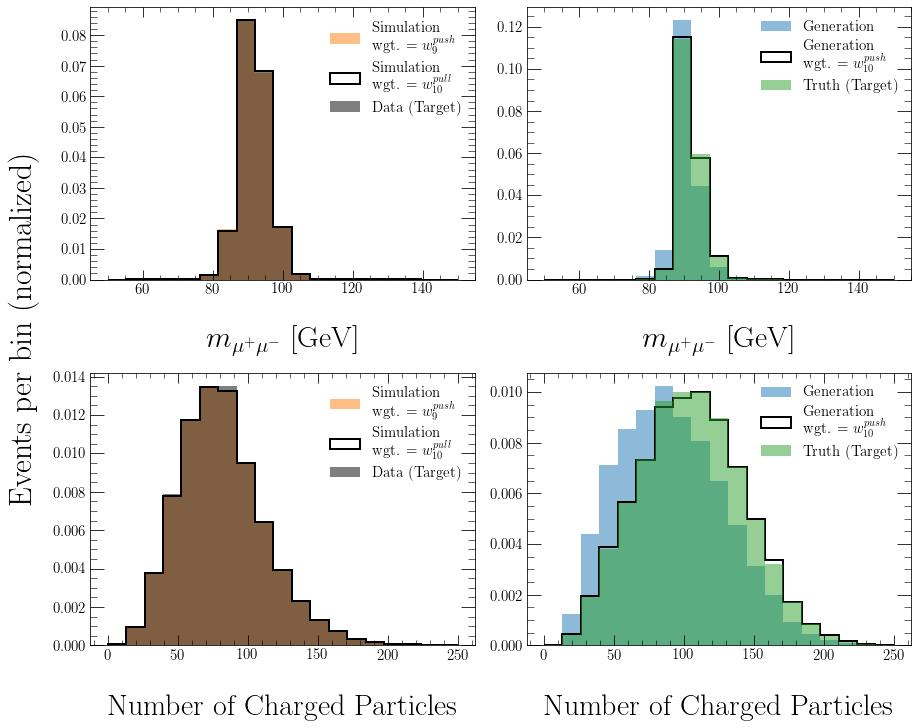

In [85]:
for i in range(len(weights)):
    if i == 0:
        weights_init = np.ones(len(weights[i - 1, 1, :]))
    else:
        weights_init = weights[i - 1, 1, :]

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(50, 150, 20)

    fig, ax = plt.subplots(num_observables,
                           2,
                           figsize=(12, 10),
                           constrained_layout=True)

    ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0, 0].hist(
        m_ll_0_S,
        weights=weights_init,
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) + '}'),
        **plot_style_2,
        color='C1')
    ax[0, 0].hist(
        m_ll_0_S,
        bins=bins,
        weights=weights[i, 0, :],
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)

    ax[0, 0].hist(m_ll_unknown_S,
                  weights=weights_stress,
                  bins=bins,
                  label=r'Data (Target)',
                  **plot_style_2,
                  color='k')
    ax[0, 0].legend(frameon=False)

    ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0, 1].hist(m_ll_0_G,
                  bins=bins,
                  label=r'Generation',
                  **plot_style_2,
                  color='C0')
    ax[0, 1].hist(
        m_ll_0_G,
        bins=bins,
        weights=weights[i, 1, :],
        label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)

    ax[0, 1].hist(m_ll_unknown_G,
                  bins=bins,
                  weights=weights_stress,
                  label=r'Truth (Target)',
                  **plot_style_2,
                  color='C2')
    ax[0, 1].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1, 0].set_xlabel('Number of Charged Particles')
    ax[1, 0].hist(
        nTracks_0_S,
        weights=weights_init,
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) + '}'),
        **plot_style_2,
        color='C1')
    ax[1, 0].hist(
        nTracks_0_S,
        bins=bins,
        weights=weights[i, 1, :],
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)
    ax[1, 0].hist(nTracks_unknown_S,
                  weights=weights_stress,
                  bins=bins,
                  label=r'Data (Target)',
                  **plot_style_2,
                  color='k')
    ax[1, 0].legend(frameon=False)

    ax[1, 1].set_xlabel('Number of Charged Particles')
    ax[1, 1].hist(nTracks_0_G,
                  bins=bins,
                  label=r'Generation',
                  **plot_style_2,
                  color='C0')
    ax[1, 1].hist(
        nTracks_0_G,
        bins=bins,
        weights=weights[i, 1, :],
        label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)
    ax[1, 1].hist(nTracks_unknown_G,
                  weights=weights_stress,
                  bins=bins,
                  label=r'Truth (Target)',
                  **plot_style_2,
                  color='C2')
    ax[1, 1].legend(frameon=False)

    fig.text(-0.05,
             0.55,
             'Events per bin (normalized)',
             va='center',
             rotation='vertical',
             fontsize='x-large')

#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-MultiFold-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    fig.show()
    plt.show()